# 1 Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16, ResNet50, InceptionResNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 as cv
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import tqdm
from skimage import feature
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score, validation_curve, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, log_loss, make_scorer)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight, resample
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import ParameterSampler
from keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import RandomSearch
import tensorflow_addons as tfa


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul  5 08:53:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
else:
    print("GPU is not available")


GPU is available


In [ ]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!ls /content/drive/MyDrive

'Colab Notebooks'
 data_svm.csv
'Fashion Product Images (Large).ipynb'
'Fashion Product Images (Large).ipynb（副本）'
'Fashion Product Images (Small).ipynb'
 file_images.npy
 images_svm.npy
 kaggle.json
 labels_cleaned2.npy
 labels_df.csv
 labels_svm.csv
 MSIN0097_CW_XNMZ6.ipynb
 predictive_individual-Copy1.ipynb
 processed_df2.csv
 processed_df.csv
 processed_images2.npy
 processed_images.npy
'ResNet50-Fashion Product Images (Small).ipynb'
'Week 4-Networks'


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
 !pip install kaggle
 !kaggle datasets download -d paramaggarwal/fashion-product-images-dataset


100% 23.1G/23.1G [02:29<00:00, 187MB/s]
100% 23.1G/23.1G [02:29<00:00, 166MB/s]


In [ ]:
!unzip fashion-product-images-dataset.zip


In [ ]:
# load the images
data = np.load('/content/drive/My Drive/processed_images2.npy')

In [ ]:
# Load the label file
labels = np.load('/content/drive/My Drive/labels_cleaned2.npy')



In [ ]:
# Load the df file
processed_df = pd.read_csv('/content/drive/My Drive/processed_df2.csv')

In [ ]:
#number of examples we are left with
len(processed_df)
len(labels)

16873

In [ ]:
processed_df.head()

Unnamed: 0     id gender masterCategory subCategory articleType baseColour  \
0           0  15970    Men        Apparel     Topwear      Shirts  Navy Blue   
1           1  39386    Men        Apparel  Bottomwear       Jeans       Blue   
2           4  53759    Men        Apparel     Topwear     Tshirts       Grey   
3           5   1855    Men        Apparel     Topwear     Tshirts       Grey   
4           6  30805    Men        Apparel     Topwear      Shirts      Green   

   season    year   usage                    productDisplayName      image  
0    Fall  2011.0  Casual      Turtle Check Men Navy Blue Shirt  15970.jpg  
1  Summer  2012.0  Casual    Peter England Men Party Blue Jeans  39386.jpg  
2  Summer  2012.0  Casual                 Puma Men Grey T-shirt  53759.jpg  
3  Summer  2011.0  Casual  Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
4  Summer  2012.0  Ethnic      Fabindia Men Striped Green Shirt  30805.jpg

In [ ]:
# Define your class names
class_names = ["Briefs", "Dresses", "Jeans", "Kurtas", "Shirts", "Shorts", "Tops", "Trousers", "Tshirts"]

# 1 EDA

## 1.1 EDA before cleaning

In [ ]:
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [ ]:
# Descriptive Statistics
print(df.describe(include='all'))

                  id gender masterCategory subCategory articleType baseColour  \
count   44424.000000  44424          44424       44424       44424      44409   
unique           NaN      5              7          45         143         46   
top              NaN    Men        Apparel     Topwear     Tshirts      Black   
freq             NaN  22147          21397       15402        7067       9728   
mean    29696.334301    NaN            NaN         NaN         NaN        NaN   
std     17049.490518    NaN            NaN         NaN         NaN        NaN   
min      1163.000000    NaN            NaN         NaN         NaN        NaN   
25%     14768.750000    NaN            NaN         NaN         NaN        NaN   
50%     28618.500000    NaN            NaN         NaN         NaN        NaN   
75%     44683.250000    NaN            NaN         NaN         NaN        NaN   
max     60000.000000    NaN            NaN         NaN         NaN        NaN   

        season          yea

In [ ]:
# Checking for Missing Values
print(df.isnull().sum())


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


In [ ]:
print(df['masterCategory'].value_counts())


Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64


In [ ]:


# Set the display option to show all rows
pd.set_option('display.max_rows', None)

# Print the count of each type in the 'articleType' column
article_type_counts = df['articleType'].value_counts()
print(article_type_counts)


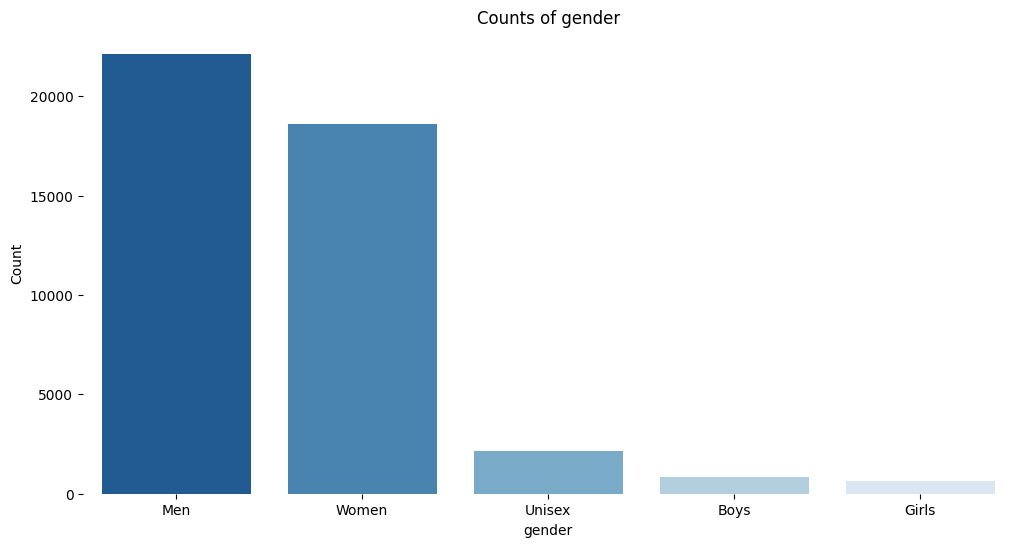

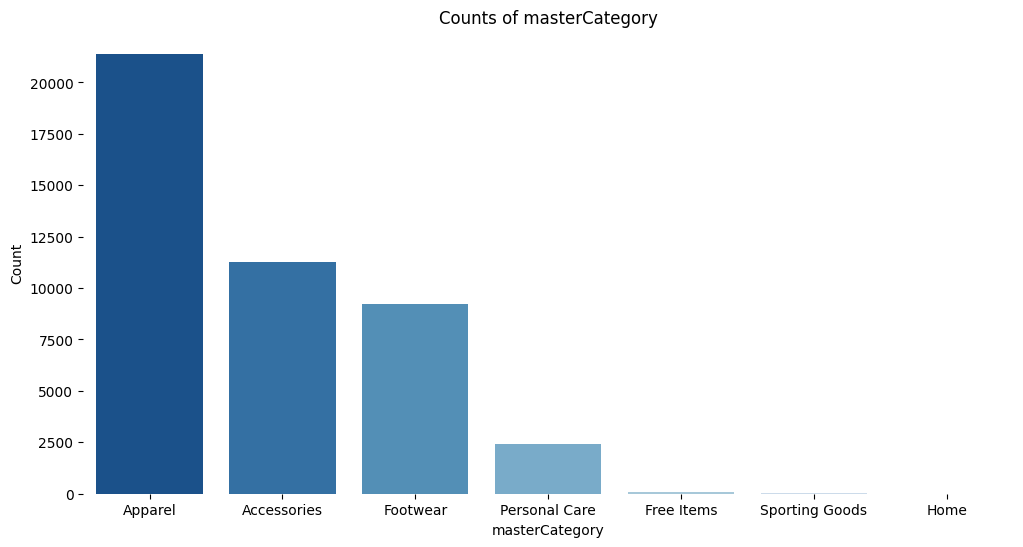

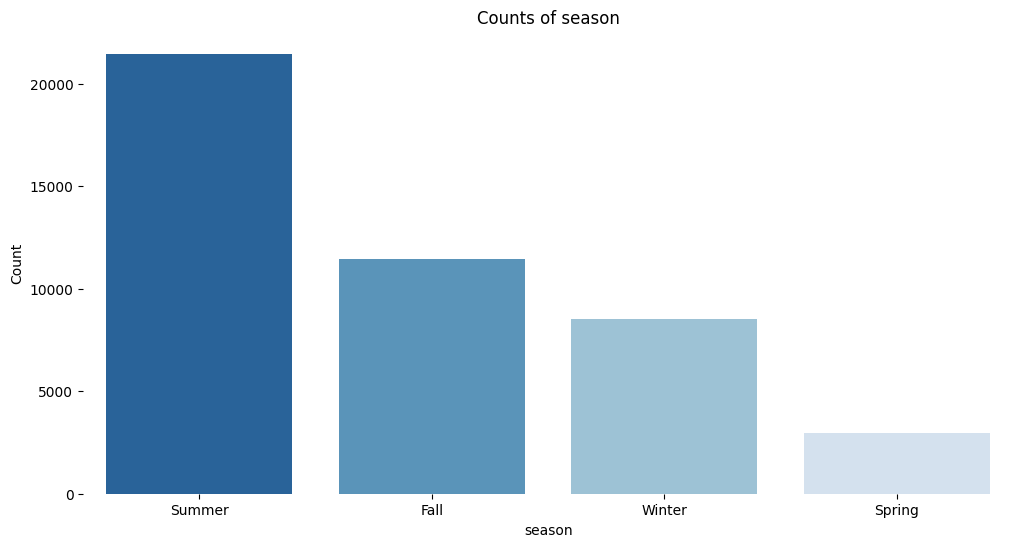

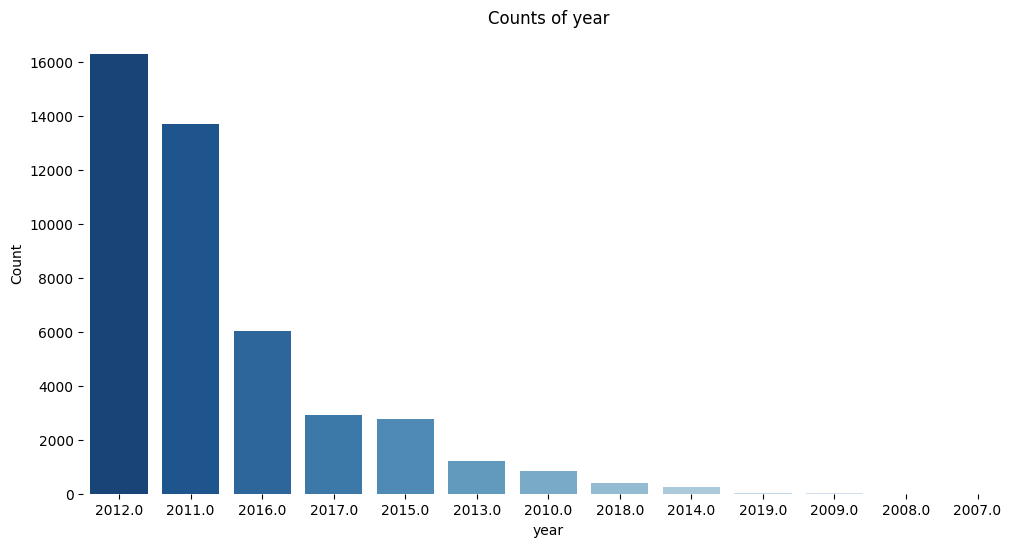

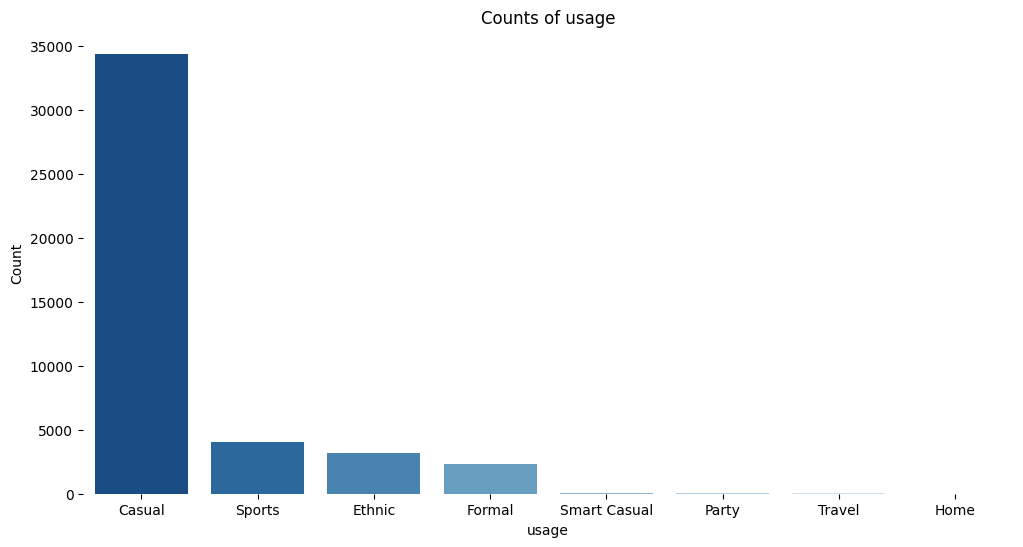

In [ ]:
def plot_value_counts(df, cols):
    for col in cols:
        plt.figure(figsize=(12, 6))
        ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Blues_r")
        plt.title(f'Counts of {col}')
        plt.xlabel(col)  # Set x-label as column name
        plt.ylabel('Count')  # Set y-label as 'Count'

        # Remove the black box line around the plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        plt.show()

# Columns to plot
cols_to_plot = ['gender', 'masterCategory', 'season', 'year', 'usage']

plot_value_counts(df, cols_to_plot)




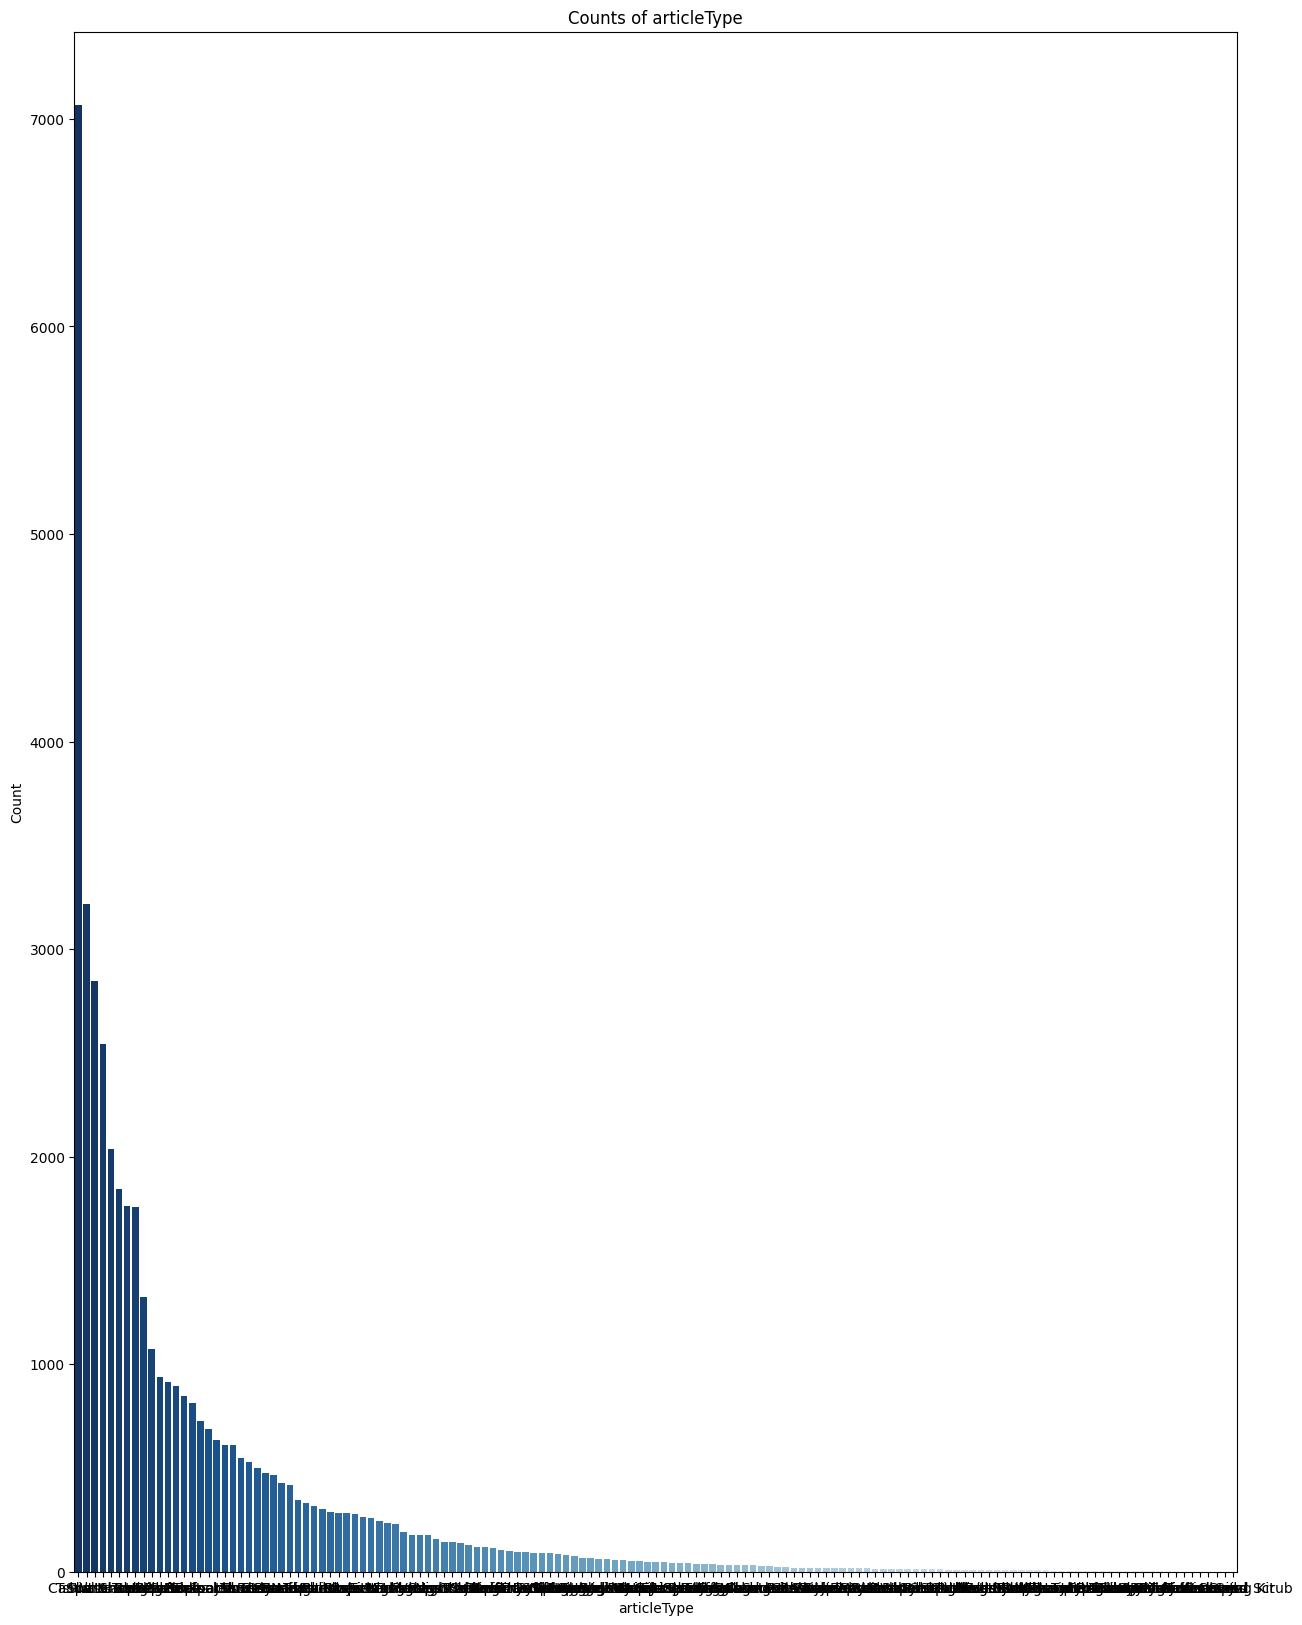

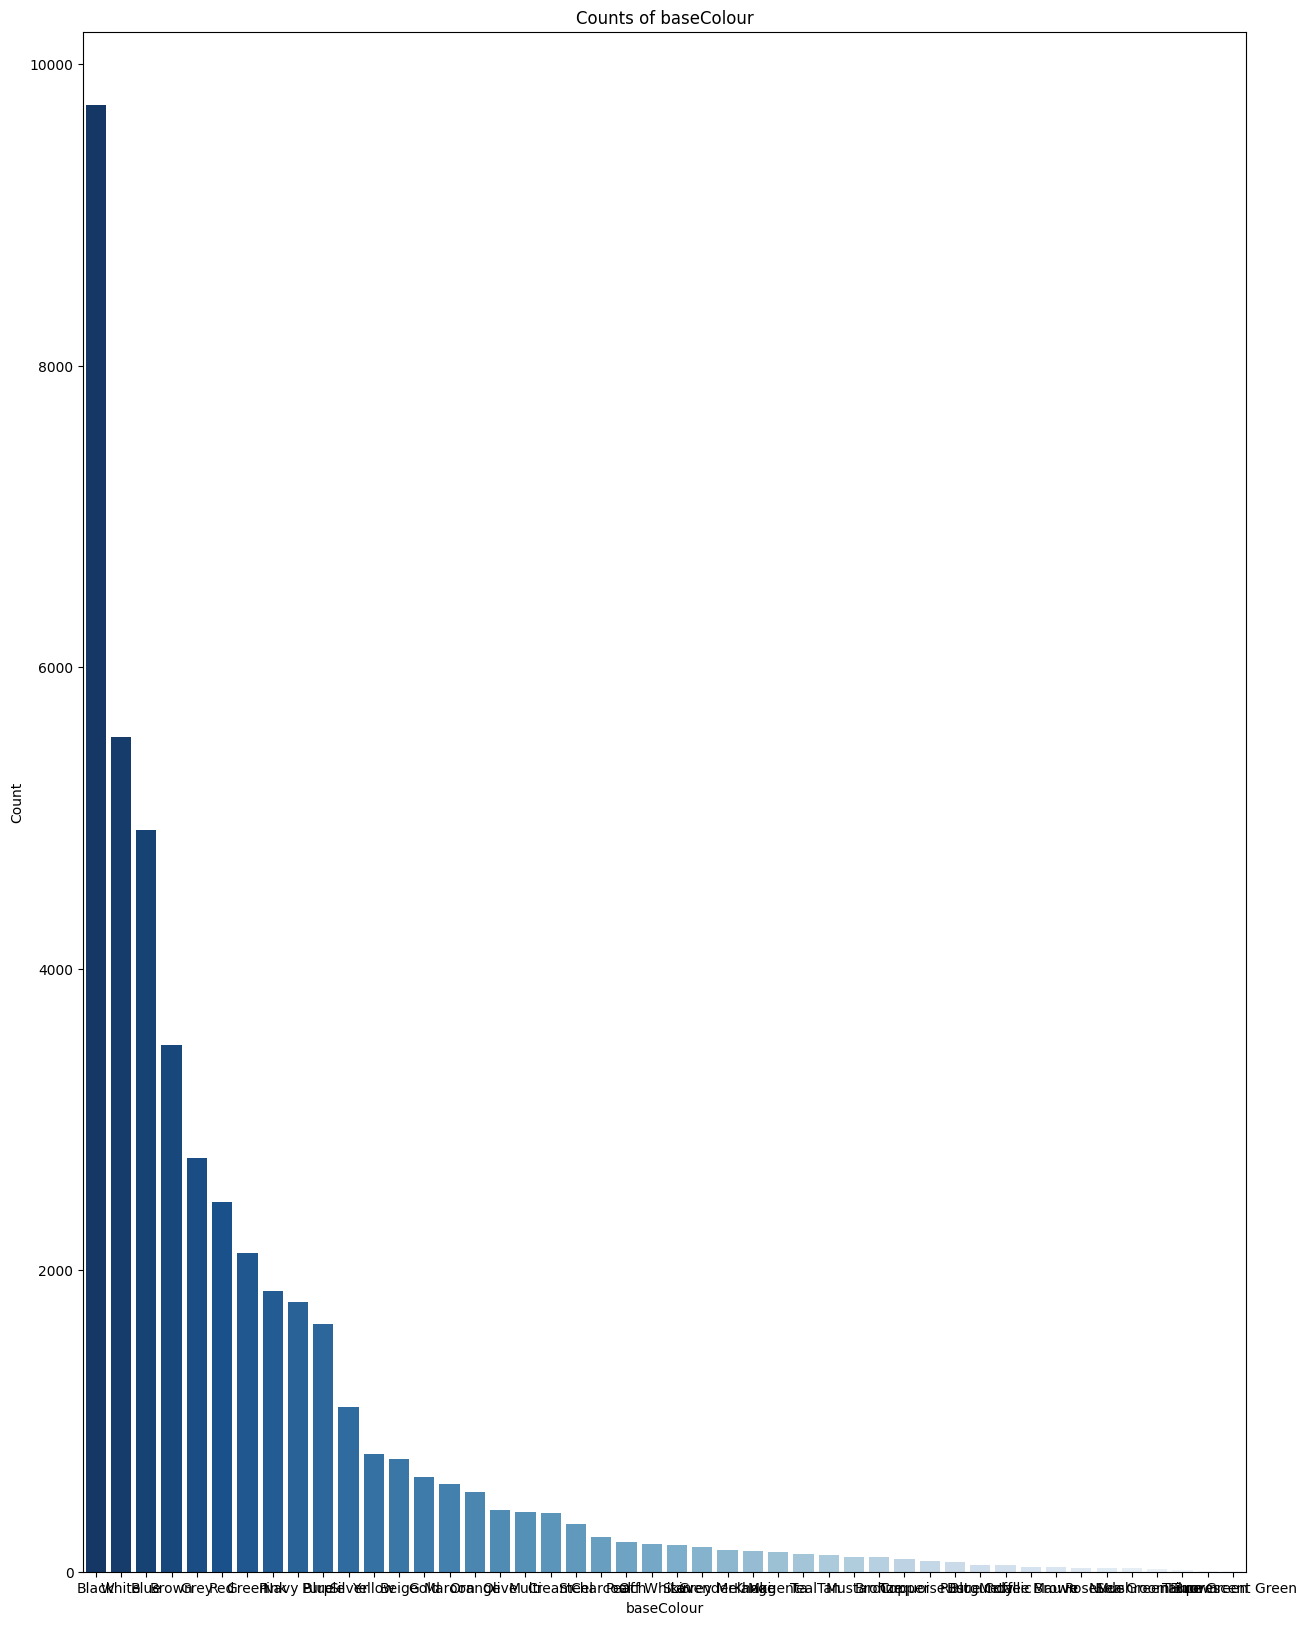

In [ ]:
def plot_value_counts(df, cols):
    for col in cols:
        plt.figure(figsize=(15, 20))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Blues_r")  # Reversed x and y axes
        plt.title(f'Counts of {col}')
        plt.xlabel(col)  # Set x-label as column name
        plt.ylabel('Count')  # Set y-label as 'Count'
        plt.show()

# Columns to plot
cols_to_plot = ['articleType', 'baseColour']

plot_value_counts(df, cols_to_plot)


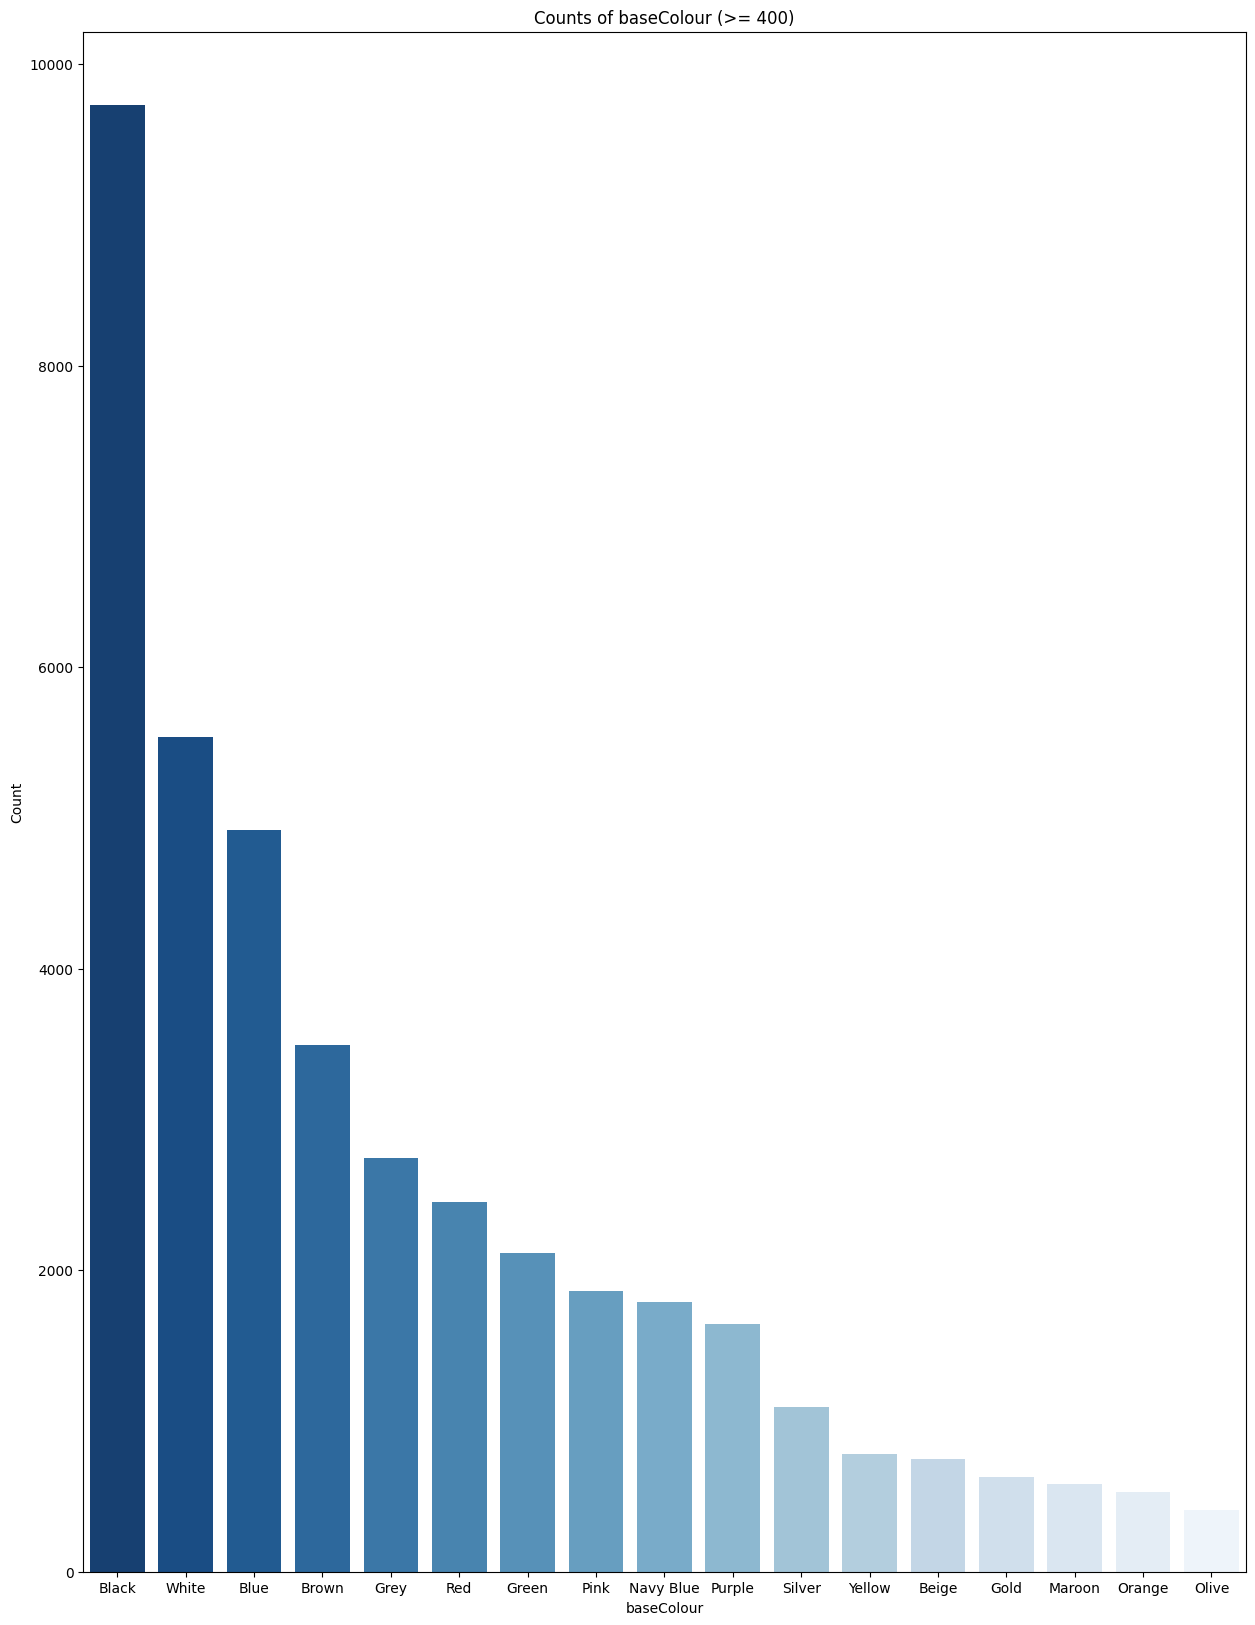

In [ ]:
def plot_value_counts(df, cols, threshold=400):
    for col in cols:
        counts = df[col].value_counts()
        counts = counts[counts >= threshold]
        if counts.empty:  # If there are no values above the threshold, skip this column
            print(f"No values with count >= {threshold} in column {col}")
            continue
        plt.figure(figsize=(15, 20))
        sns.countplot(data=df, x=col, order=counts.index, palette="Blues_r")  # Reversed x and y axes
        plt.title(f'Counts of {col} (>= {threshold})')
        plt.xlabel(col)  # Set x-label as column name
        plt.ylabel('Count')  # Set y-label as 'Count'
        plt.show()

# Columns to plot
cols_to_plot = ['baseColour']

plot_value_counts(df, cols_to_plot)


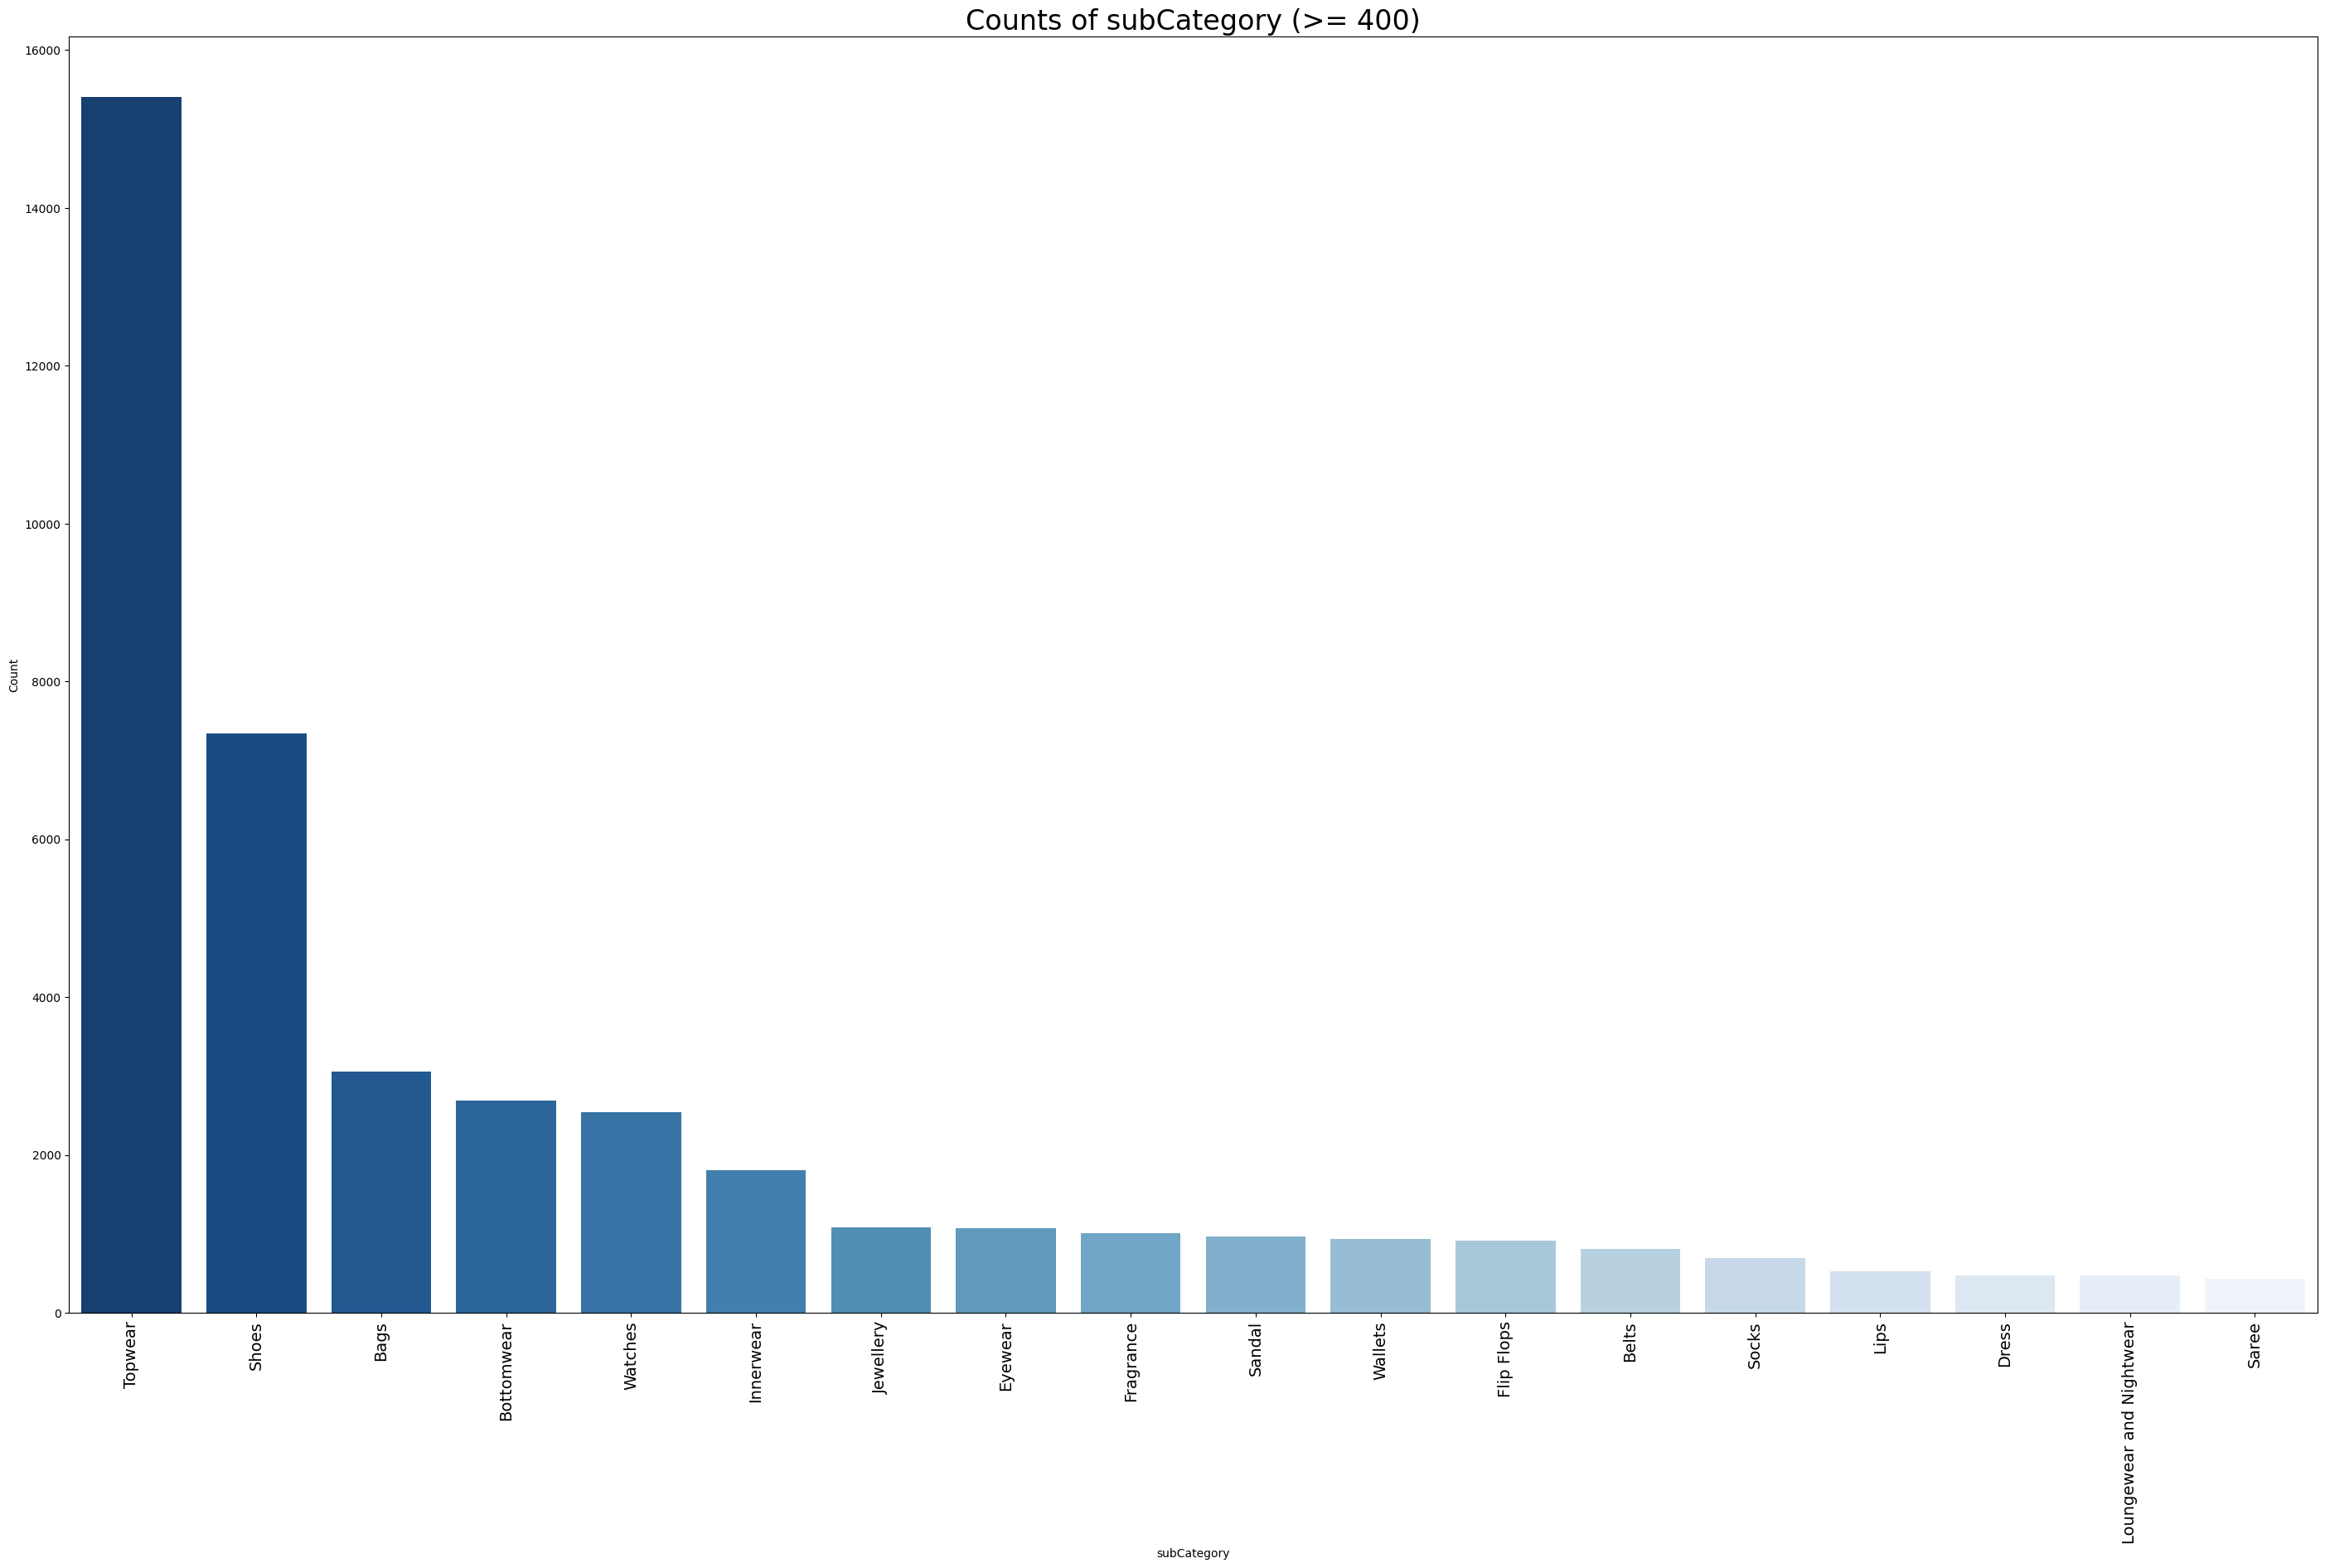

In [ ]:
import matplotlib.pyplot as plt

def plot_value_counts(df, cols, threshold=400):
    for col in cols:
        counts = df[col].value_counts()
        counts = counts[counts >= threshold]
        if counts.empty:  # If there are no values above the threshold, skip this column
            print(f"No values with count >= {threshold} in column {col}")
            continue
        plt.figure(figsize=(35, 20))
        ax = sns.countplot(data=df, x=col, order=counts.index, palette="Blues_r")  # Reversed x and y axes
        plt.title(f'Counts of {col} (>= {threshold})', fontsize=24)  # Increase title font size
        plt.xlabel(col)  # Set x-label as column name
        plt.ylabel('Count')  # Set y-label as 'Count'

        # Rotate x-axis labels vertically and increase font size
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)

        plt.show()

# Columns to plot
cols_to_plot = ['subCategory', 'articleType']

plot_value_counts(df, cols_to_plot)



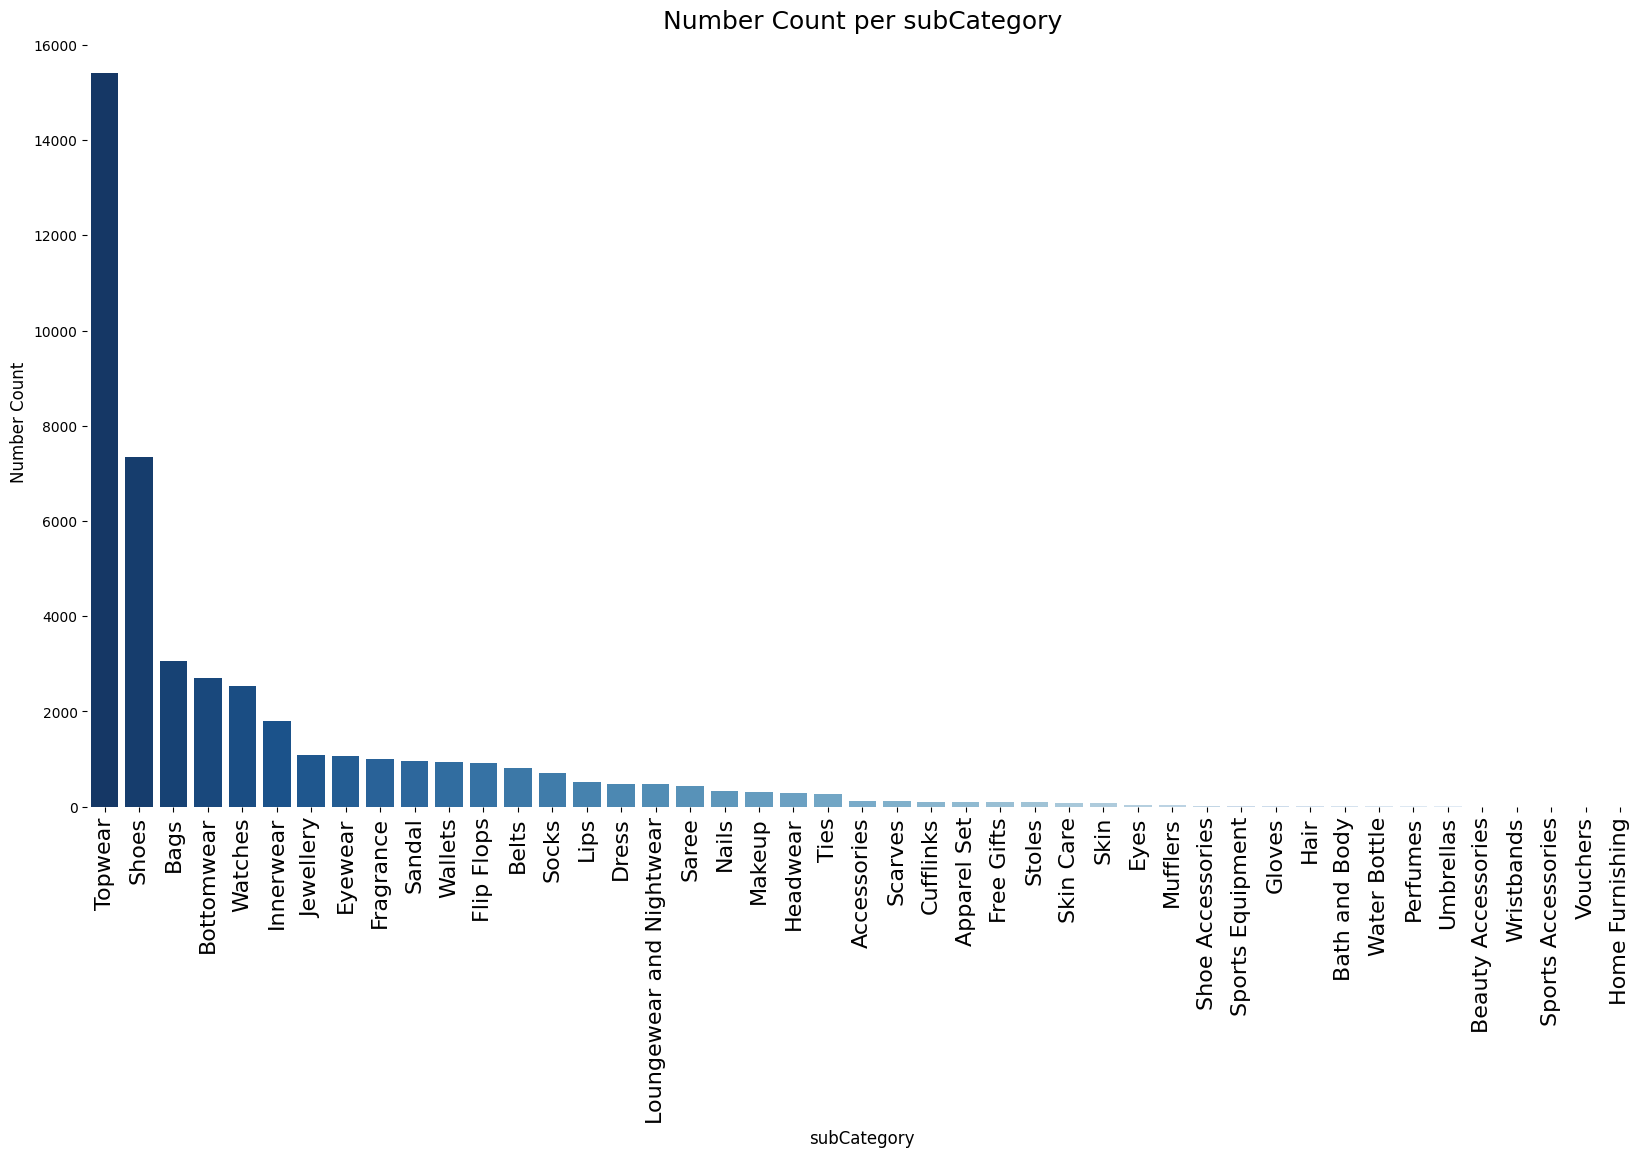

In [ ]:

def plot_value_counts(df, col):
    plt.figure(figsize=(20, 10))
    sorted_df = df.sort_values('num_count', ascending=False)  # Sort the DataFrame by 'num_count' column
    ax = sns.barplot(data=sorted_df, x=col, y='num_count', palette="Blues_r")
    plt.title(f'Number Count per {col}', fontsize=18)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Number Count', fontsize=12)
    plt.xticks(rotation=90, fontsize=16)  # Rotate x-axis labels and adjust font size

    # Remove the black box line around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.show()

# Group by subCategory and calculate number count
df_subCategory_count = df.groupby('subCategory').size().reset_index(name='num_count')

# Plotting the number count for each subCategory in descending order
plot_value_counts(df_subCategory_count, 'subCategory')


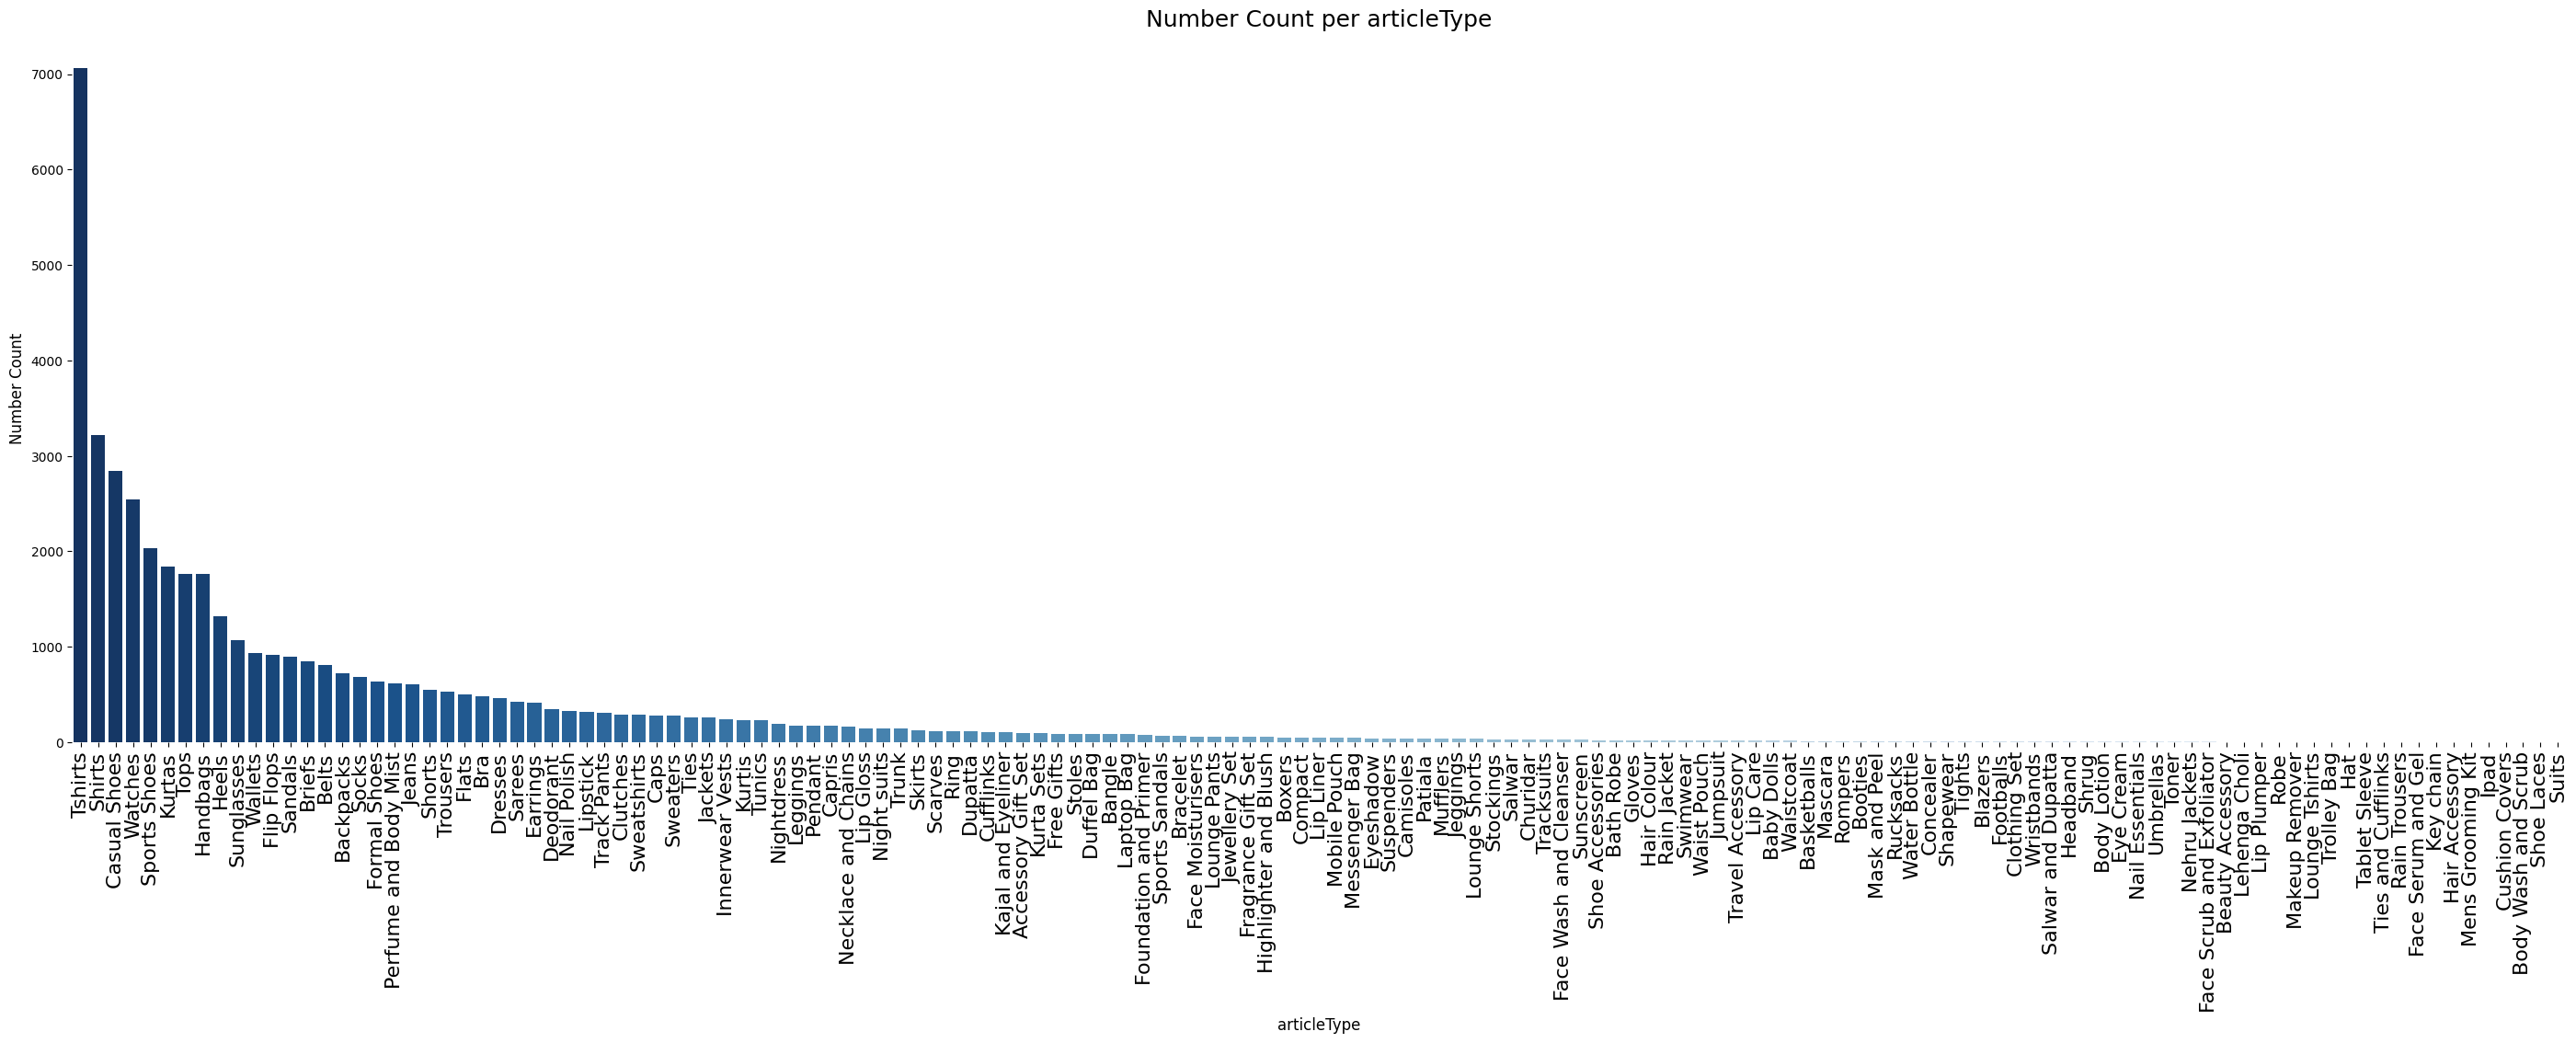

In [ ]:

def plot_value_counts(df, col):
    plt.figure(figsize=(35, 10))
    sorted_df = df.sort_values('num_count', ascending=False)  # Sort the DataFrame by 'num_count' column
    ax = sns.barplot(data=sorted_df, x=col, y='num_count', palette="Blues_r")
    plt.title(f'Number Count per {col}', fontsize=18)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Number Count', fontsize=12)
    plt.xticks(rotation=90, fontsize=16)  # Rotate x-axis labels and adjust font size

    # Remove the black box line around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.show()

# Group by articleType and calculate number count
df_articleType_count = df.groupby('articleType').size().reset_index(name='num_count')

# Plotting the number count for each subCategory in descending order
plot_value_counts(df_articleType_count, 'articleType')


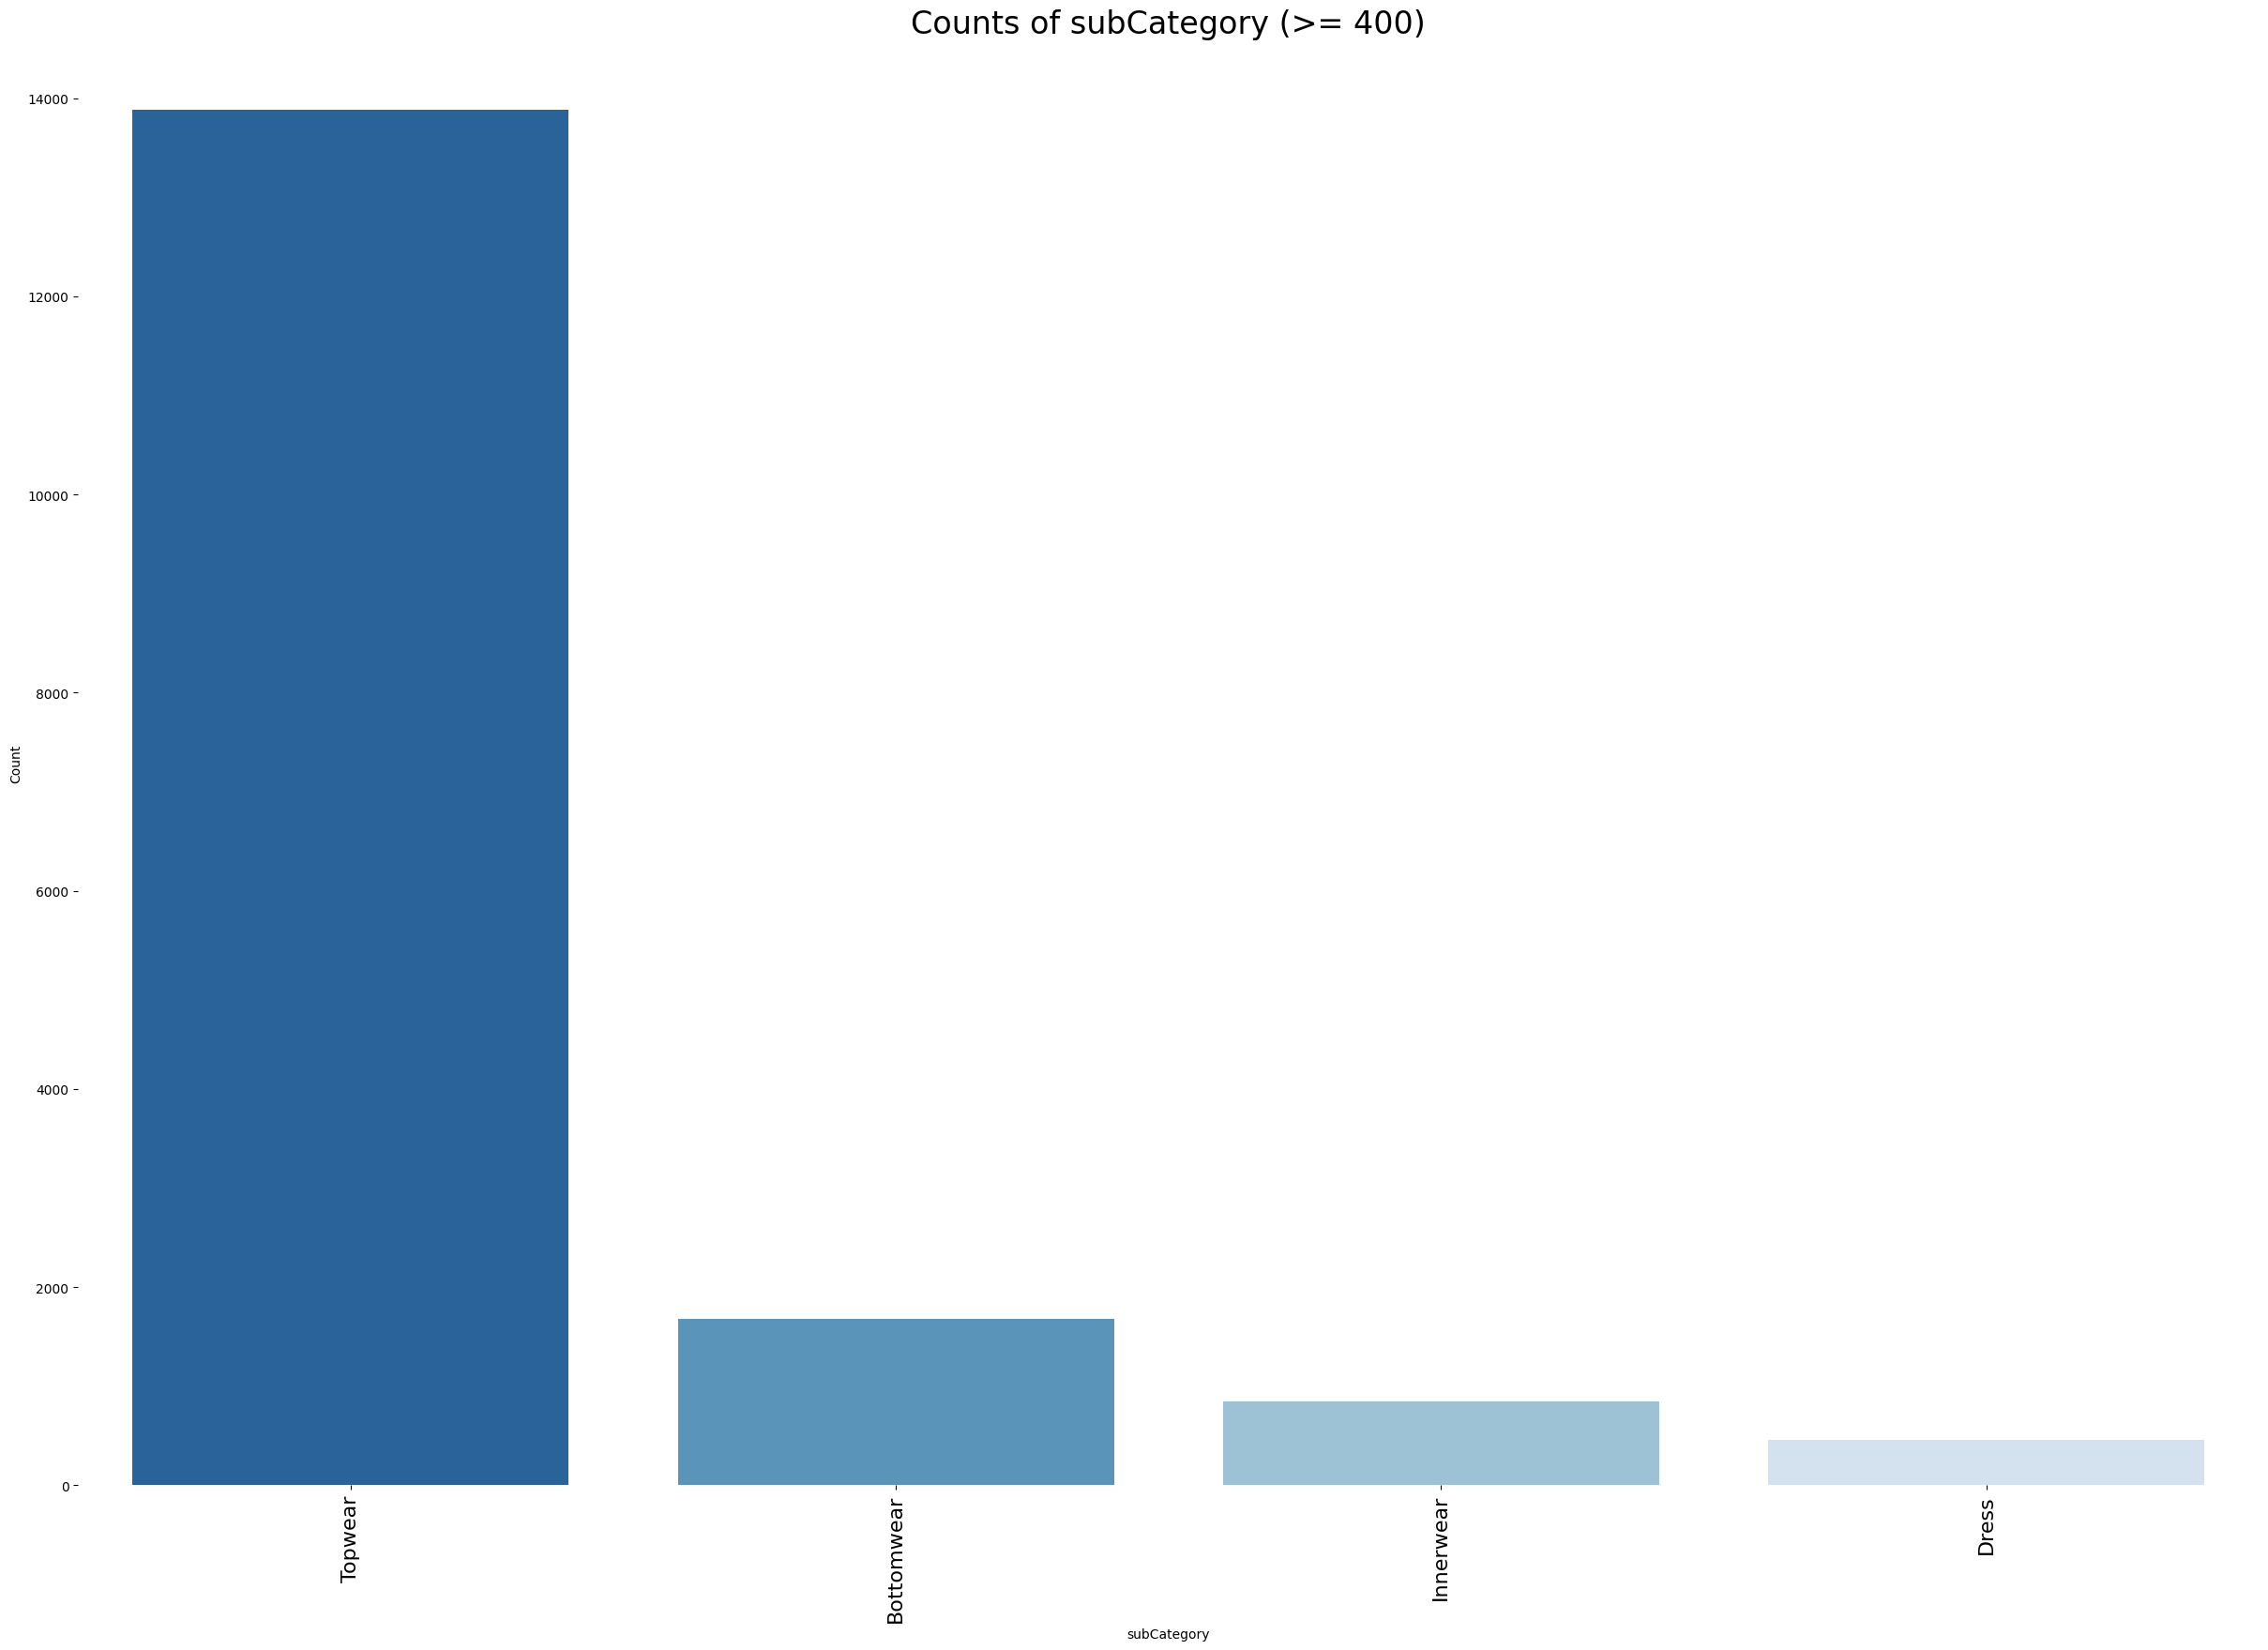

In [ ]:


def plot_value_counts(df, cols, threshold=400):
    for col in cols:
        counts = df[col].value_counts()
        counts = counts[counts >= threshold]
        if counts.empty:  # If there are no values above the threshold, skip this column
            print(f"No values with count >= {threshold} in column {col}")
            continue
        plt.figure(figsize=(30, 20))
        ax = sns.countplot(data=df, x=col, order=counts.index, palette="Blues_r")  # Reversed x and y axes
        plt.title(f'Counts of {col} (>= {threshold})', fontsize=24)  # Increase title font size
        plt.xlabel(col)  # Set x-label as column name
        plt.ylabel('Count')  # Set y-label as 'Count'

        # Rotate x-axis labels vertically and increase font size
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
        # Remove the black box line around the plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        plt.show()

# Columns to plot
cols_to_plot = ['subCategory']

plot_value_counts(processed_df, cols_to_plot)


In [ ]:

def plot_value_counts(df, cols, threshold=400):
    for col in cols:
        counts = df[col].value_counts()
        counts = counts[counts >= threshold]
        if counts.empty:  # If there are no values above the threshold, skip this column
            print(f"No values with count >= {threshold} in column {col}")
            continue
        plt.figure(figsize=(30, 20))
        ax = sns.countplot(data=df, x=col, order=counts.index, palette="Blues_r")  # Reversed x and y axes
        plt.title(f'Counts of {col} (>= {threshold})', fontsize=24)  # Increase title font size
        plt.xlabel(col)  # Set x-label as column name
        plt.ylabel('Count')  # Set y-label as 'Count'

        # Rotate x-axis labels vertically and increase font size
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16)
        # Remove the black box line around the plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        plt.show()

# Columns to plot
cols_to_plot = ['articleType']

plot_value_counts(processed_df, cols_to_plot)


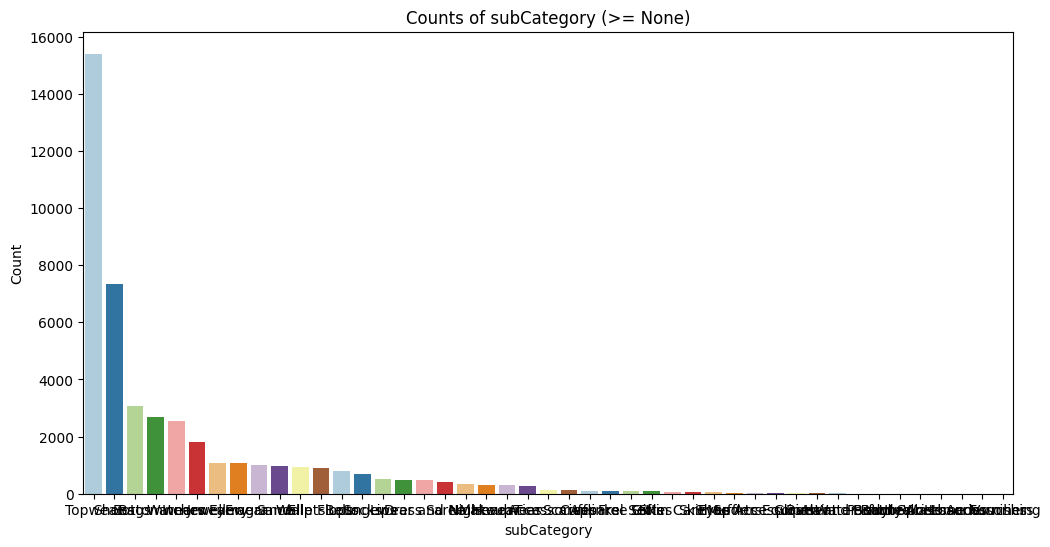

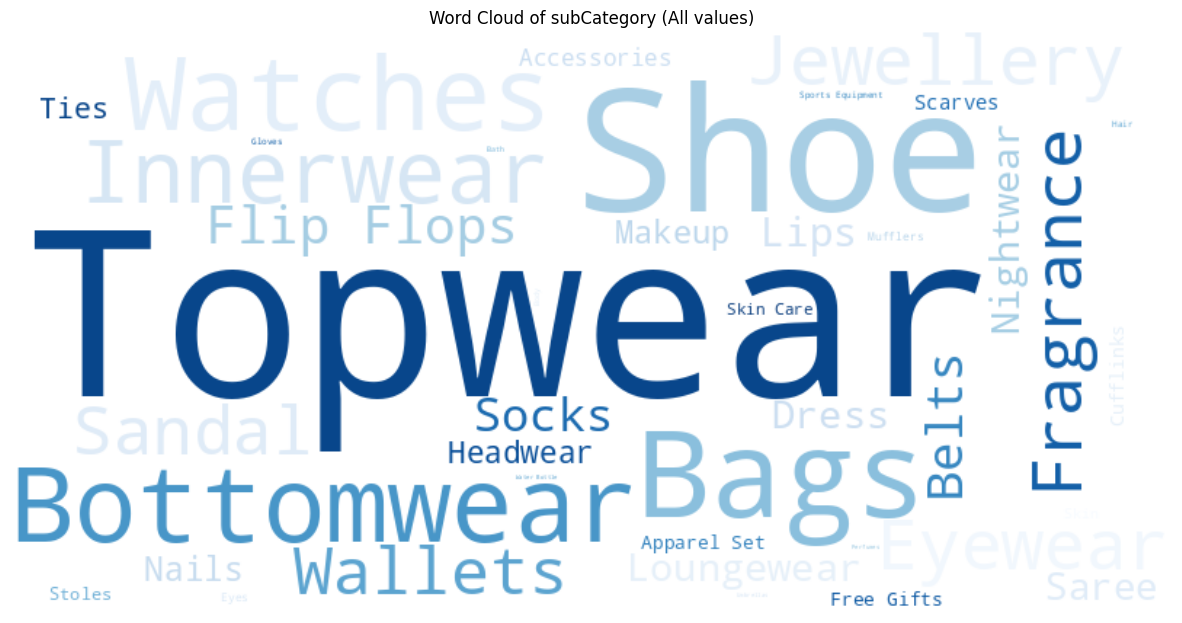

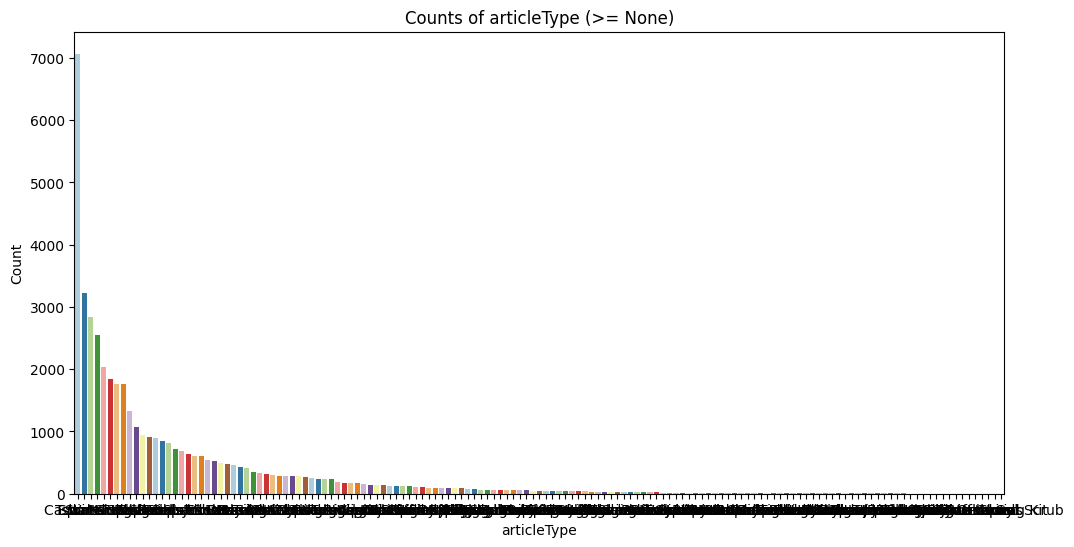

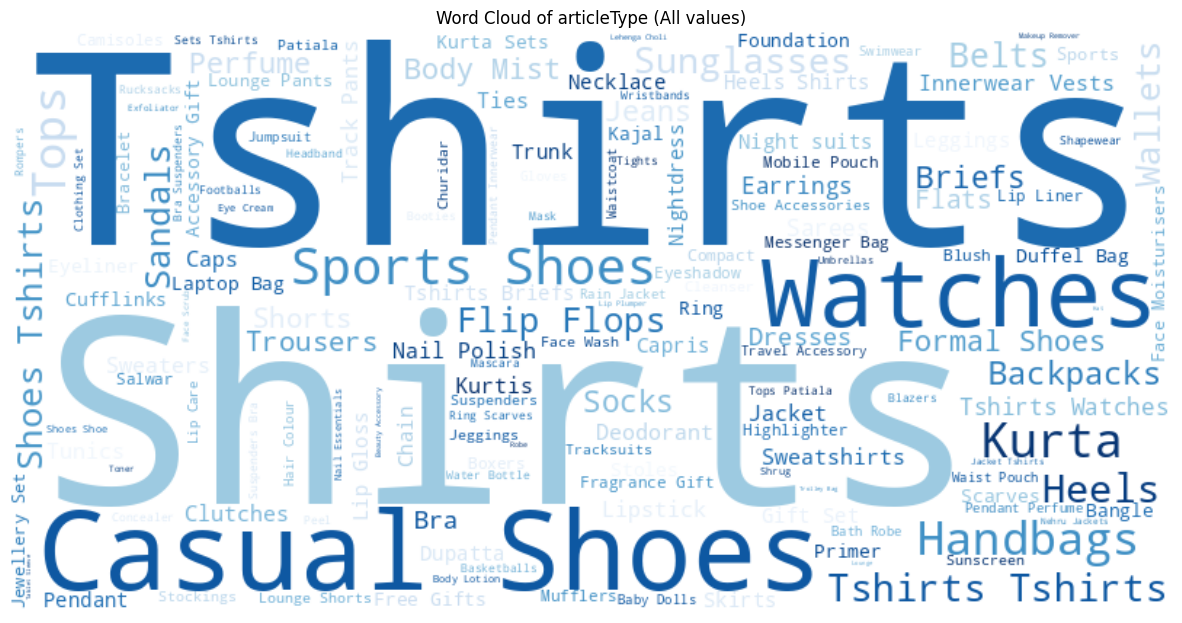

In [ ]:

# Function to plot word cloud
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Function to plot value counts and word cloud
def plot_value_counts(df, cols, threshold=400):
    for col in cols:
        counts = df[col].value_counts()
        if threshold is not None:
            counts = counts[counts >= threshold]
        if counts.empty:  # If there are no values above the threshold, skip this column
            print(f"No values with count >= {threshold} in column {col}")
            continue
        # Set custom color palette
        sns.set_palette('Paired')

        # Plotting value counts
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x=col, order=counts.index, palette='Paired')
        plt.title(f'Counts of {col} (>= {threshold})')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

        # Creating text for word cloud
        text = ' '.join(df[col].astype(str).tolist())
        # Plotting word cloud
        plot_word_cloud(text, f'Word Cloud of {col} (All values)')

# Columns to plot
cols_to_plot = ['subCategory', 'articleType']

# Plotting value counts and word clouds without threshold
plot_value_counts(df, cols_to_plot, threshold=None)

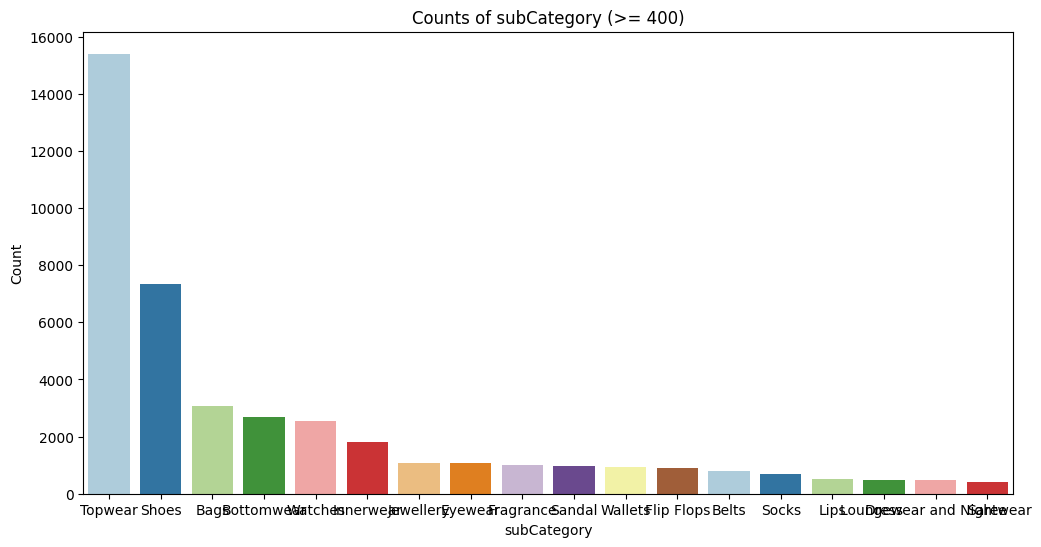

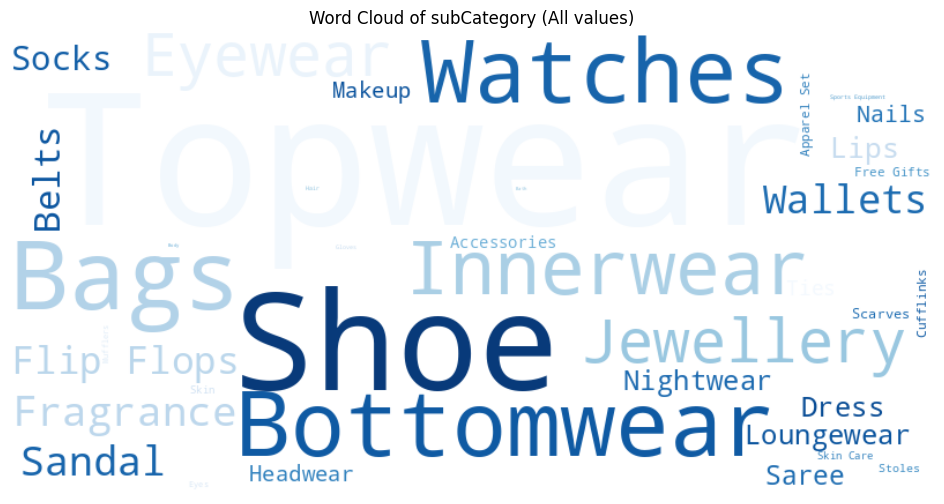

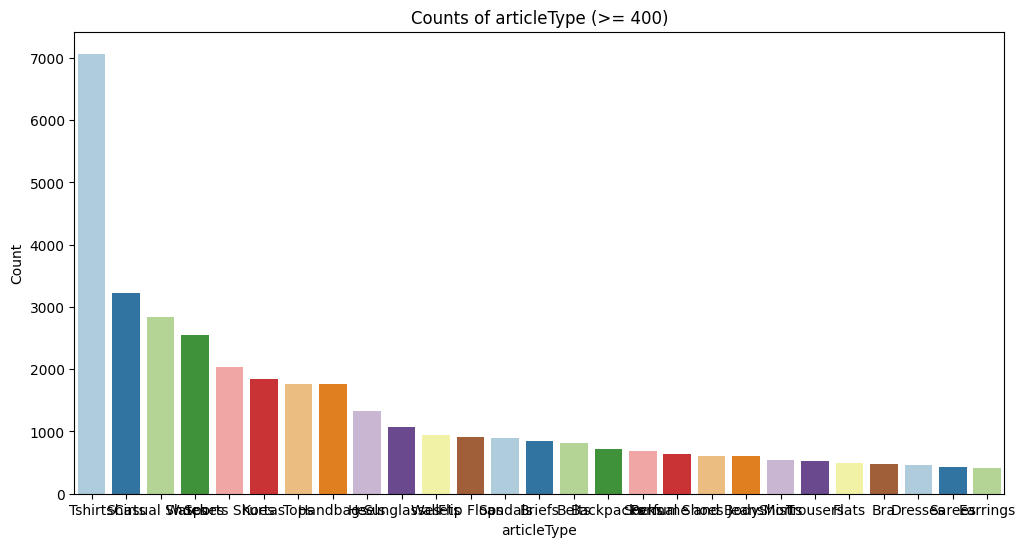

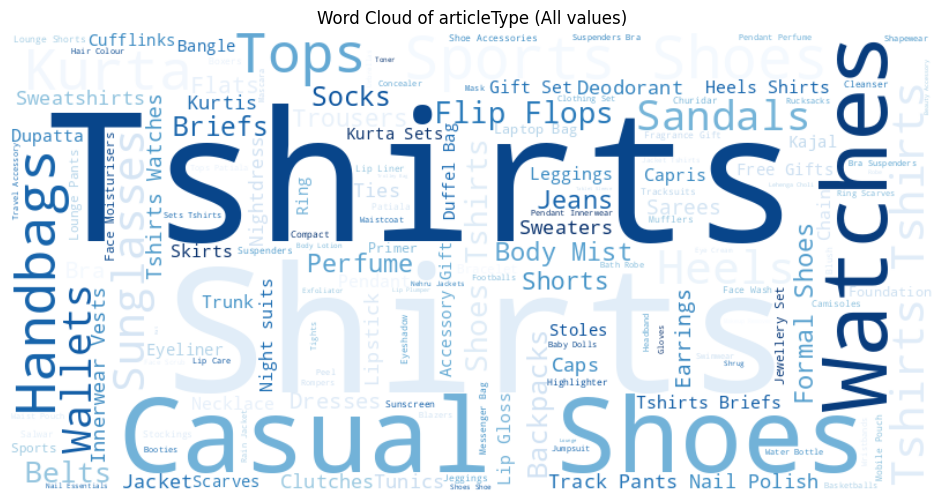

In [ ]:
# Plotting value counts and word clouds with threshold 400
plot_value_counts(df, cols_to_plot, threshold=400)

In [ ]:
fig = px.bar(df.groupby('subCategory').count().reset_index(), x='subCategory', y='id', color='id', color_continuous_scale=['#D0E0FF', '#0047AB'])
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'}, plot_bgcolor='#F5F5F5', coloraxis_showscale=False, yaxis_title='num_count', title={'text': 'Count per Product Sub-category', 'x': 0.5, 'font': {'family': 'Times New Roman', 'size': 24}})
fig.update_xaxes(title_font={'family': 'Times New Roman', 'size': 18})
fig.update_yaxes(title_font={'family': 'Times New Roman', 'size': 18})




In [ ]:


# Define the color palette suitable for SCI papers
sci_color_palette = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 'rgb(148, 103, 189)', 'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

fig = px.bar(df.groupby('articleType').count().reset_index(), x='articleType', y='id', title='Count per Product Article Type', color='articleType', color_discrete_sequence=sci_color_palette)
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'}, plot_bgcolor='white', coloraxis_showscale=False)

# Customizing the y-axis scale
fig.update_yaxes(tickformat='k', range=[0, 5000])  # Use 'k' for thousands and set the range according to your data


fig.show()


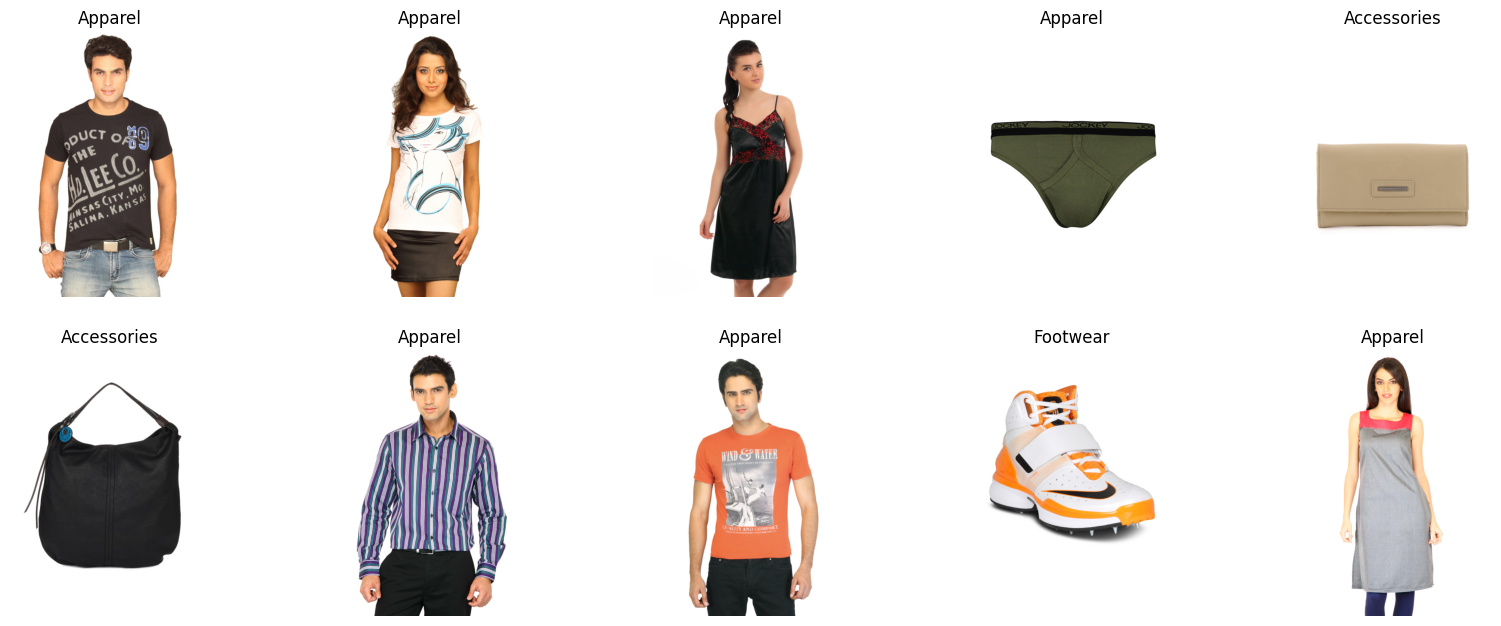

In [ ]:

def display_images(df, num_images):
    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        plt.subplot(5, 5, i+1)

        random_image = df.sample(1)
        img_path = '/content/fashion-dataset/images/' + str(random_image['id'].values[0]) + '.jpg'
        img = Image.open(img_path)

        plt.imshow(img)
        plt.title(random_image['masterCategory'].values[0])
        plt.axis('off')

    plt.show()

# Call the function
display_images(df, 10)


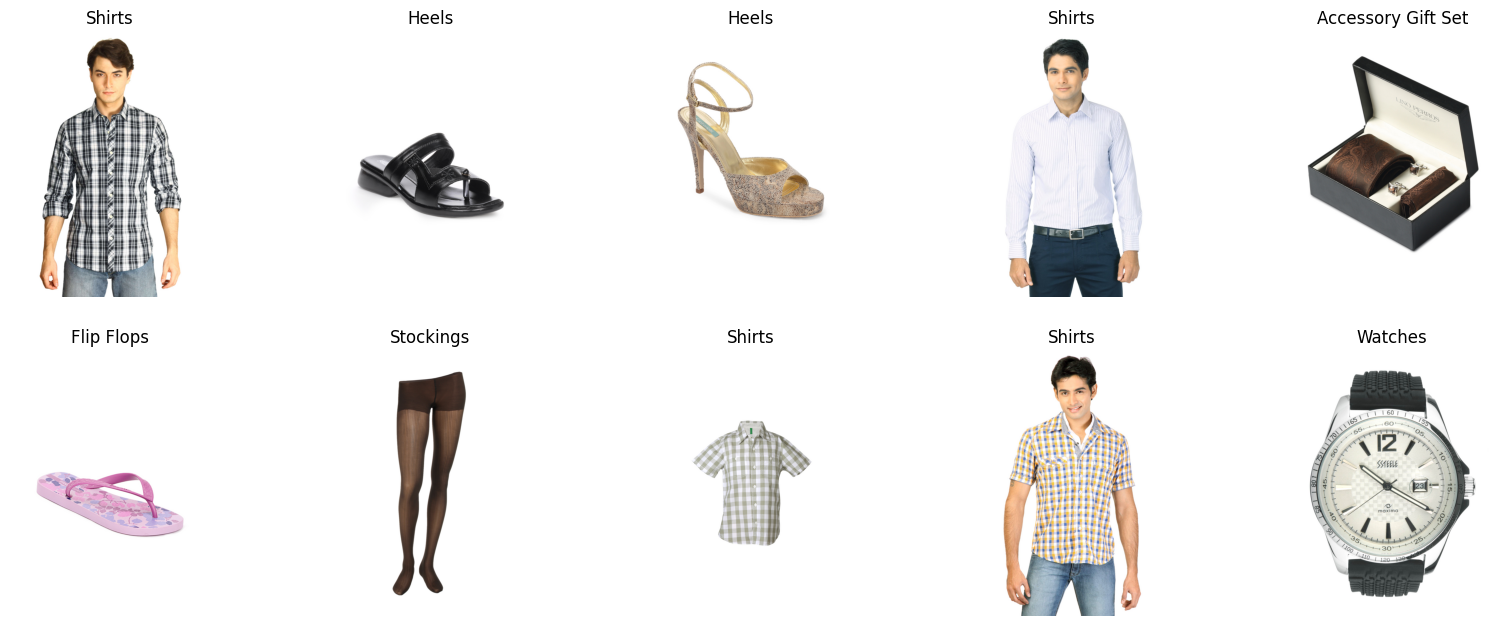

In [ ]:
# Visualization of Image Data


def display_images(df, num_images):
    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        plt.subplot(5, 5, i+1)

        random_image = df.sample(1)
        img_path = '/content/fashion-dataset/images/' + str(random_image['id'].values[0]) + '.jpg'
        img = Image.open(img_path)

        plt.imshow(img)
        plt.title(random_image['articleType'].values[0])
        plt.axis('off')

    plt.show()

# Call the function
display_images(df, 10)

## 1.2 Data Cleaning

In [ ]:
df = df.dropna()
df.nunique()
df.columns

df['image'] = df['id'].map(lambda x: str(x) + '.jpg')
df['image']

# Looking at all the unique labels in all categorical columns
cat_columns = ['gender', 'masterCategory', 'subCategory', 'articleType','baseColour', 'season', 'year', 'usage']

for col in cat_columns:
    print(col)
    print(df[col].unique())
    print('-------------------------')


gender
['Men' 'Women' 'Boys' 'Girls' 'Unisex']
-------------------------
masterCategory
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
-------------------------
subCategory
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
-------------------------
articleType
['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lips

<ipython-input-25-e2e45fa06e4d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['id'].map(lambda x: str(x) + '.jpg')


In [ ]:
# Filter the DataFrame
df_apparel = df[df['masterCategory'] == 'Apparel']
df_apparel


id gender masterCategory subCategory  articleType baseColour  \
0      15970    Men        Apparel     Topwear       Shirts  Navy Blue   
1      39386    Men        Apparel  Bottomwear        Jeans       Blue   
3      21379    Men        Apparel  Bottomwear  Track Pants      Black   
4      53759    Men        Apparel     Topwear      Tshirts       Grey   
5       1855    Men        Apparel     Topwear      Tshirts       Grey   
...      ...    ...            ...         ...          ...        ...   
44414  30614    Men        Apparel     Topwear      Tshirts      Black   
44415  13496    Men        Apparel     Topwear      Tshirts       Blue   
44417  12544  Women        Apparel     Topwear      Tshirts      Peach   
44418  42234  Women        Apparel     Topwear         Tops       Blue   
44421  18842    Men        Apparel     Topwear      Tshirts       Blue   

       season    year   usage                             productDisplayName  \
0        Fall  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1      Summer  2012.0  Casual             Peter England Men Party Blue Jeans   
3        Fall  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4      Summer  2012.0  Casual                          Puma Men Grey T-shirt   
5      Summer  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt   
...       ...     ...     ...                                            ...   
44414  Summer  2012.0  Sports                  Nike Men Striped Black Jersey   
44415    Fall  2011.0  Casual          Chimp Men Teja Main Hoon Blue Tshirts   
44417    Fall  2011.0  Casual             Tantra Women Printed Peach T-shirt   
44418  Summer  2012.0  Casual                   Sepia Women Blue Printed Top   
44421    Fall  2011.0  Casual           Puma Men Graphic Stellar Blue Tshirt   

           image  
0      15970.jpg  
1      39386.jpg  
3      21379.jpg  
4      53759.jpg  
5       1855.jpg  
...          ...  
44414  30614.jpg  
44415  13496.jpg  
44417  12544.jpg  
44418  42234.jpg  
44421  18842.jpg  

[21366 rows x 11 columns]

In [ ]:

# Get unique values in the 'articleType' column
article_counts = df_apparel['articleType'].value_counts().reset_index()
article_counts.columns = ['Article Type', 'Count']
print(article_counts)


          Article Type  Count
0              Tshirts   7065
1               Shirts   3214
2               Kurtas   1844
3                 Tops   1762
4               Briefs    847
5                Jeans    603
6               Shorts    547
7             Trousers    530
8                  Bra    477
9              Dresses    464
10              Sarees    427
11         Track Pants    304
12         Sweatshirts    285
13            Sweaters    277
14             Jackets    258
15     Innerwear Vests    242
16              Kurtis    234
17              Tunics    229
18          Nightdress    188
19            Leggings    177
20              Capris    175
21         Night suits    141
22               Trunk    140
23              Skirts    128
24             Dupatta    116
25          Kurta Sets     94
26        Lounge Pants     61
27              Boxers     52
28          Suspenders     40
29           Camisoles     39
30             Patiala     38
31       Lounge Shorts     34
32        

In [ ]:

# Select apparel with count >= 400 and exclude 'Sarees' and 'Bra'
filtered_article_counts = article_counts[(article_counts['Count'] >= 400)
                                         & (article_counts['Article Type'] != 'Sarees')
                                         & (article_counts['Article Type'] != 'Bra')]
print(filtered_article_counts)


  Article Type  Count
0      Tshirts   7065
1       Shirts   3214
2       Kurtas   1844
3         Tops   1762
4       Briefs    847
5        Jeans    603
6       Shorts    547
7     Trousers    530
9      Dresses    464


In [ ]:

filtered_article_types = filtered_article_counts['Article Type'].values

df = df[df['articleType'].isin(filtered_article_types)]

# Now df_apparel_filtered only contains rows where articleType is in filtered_article_types


In [ ]:
df.head(5)

id gender masterCategory subCategory articleType baseColour  season  \
0  15970    Men        Apparel     Topwear      Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear       Jeans       Blue  Summer   
4  53759    Men        Apparel     Topwear     Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear     Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear      Shirts      Green  Summer   

     year   usage                    productDisplayName      image  
0  2011.0  Casual      Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual    Peter England Men Party Blue Jeans  39386.jpg  
4  2012.0  Casual                 Puma Men Grey T-shirt  53759.jpg  
5  2011.0  Casual  Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012.0  Ethnic      Fabindia Men Striped Green Shirt  30805.jpg

In [ ]:
#number of examples we are left with
len(df)

16877

In [ ]:
# save to the Google Drive
df.to_csv('/content/drive/My Drive/processed_df2.csv')



In [ ]:
# load from the Google Drive
df = pd.read_csv('/content/drive/My Drive/processed_df2.csv')

## 1.3 EDA after data cleaning

In [ ]:
print(df['subCategory'].value_counts())

Topwear                     13887
Bottomwear                   1678
Innerwear                     847
Dress                         462
Loungewear and Nightwear        2
Belts                           1
Name: subCategory, dtype: int64


In [ ]:
print(df['articleType'].value_counts())

Tshirts     7066
Shirts      3214
Kurtas      1844
Tops        1762
Briefs       847
Jeans        603
Shorts       547
Trousers     530
Dresses      464
Name: articleType, dtype: int64


In [ ]:
# Define the color palette suitable for SCI papers
sci_color_palette = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 'rgb(148, 103, 189)', 'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

fig = px.bar(df.groupby('subCategory').count().reset_index(), x='subCategory', y='id', title='Count per Product Sub-category', color='subCategory', color_discrete_sequence=sci_color_palette)
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'}, plot_bgcolor='white', coloraxis_showscale=False)
fig.show()


In [ ]:

# Define the color palette suitable for SCI papers
sci_color_palette = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 'rgb(148, 103, 189)', 'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

fig = px.bar(df.groupby('articleType').count().reset_index(), x='articleType', y='id', title='Count per Product Article Type', color='articleType', color_discrete_sequence=sci_color_palette)
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'}, plot_bgcolor='white', coloraxis_showscale=False)

# Customizing the y-axis scale
fig.update_yaxes(tickformat='k', range=[0, 5000])  # Use 'k' for thousands and set the range according to your data


fig.show()

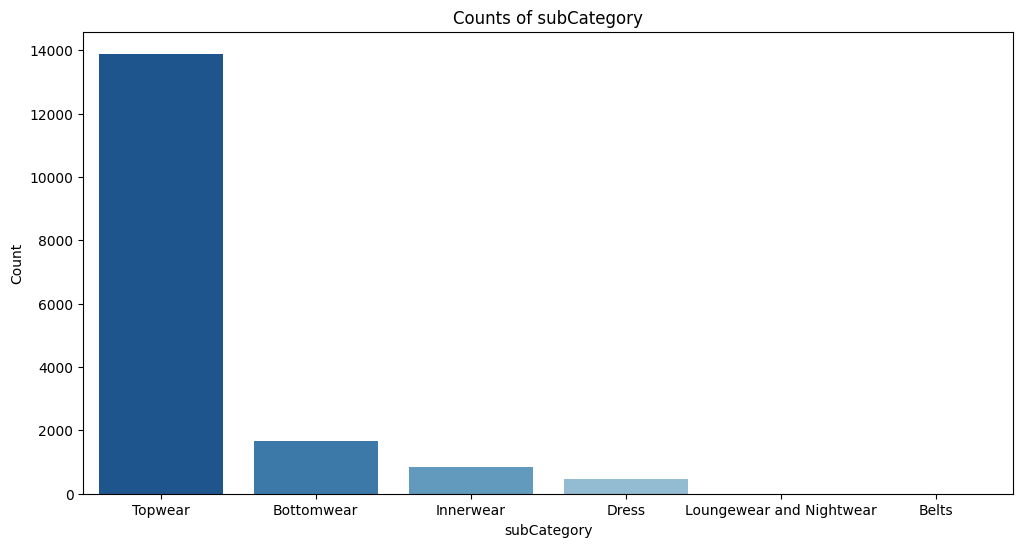

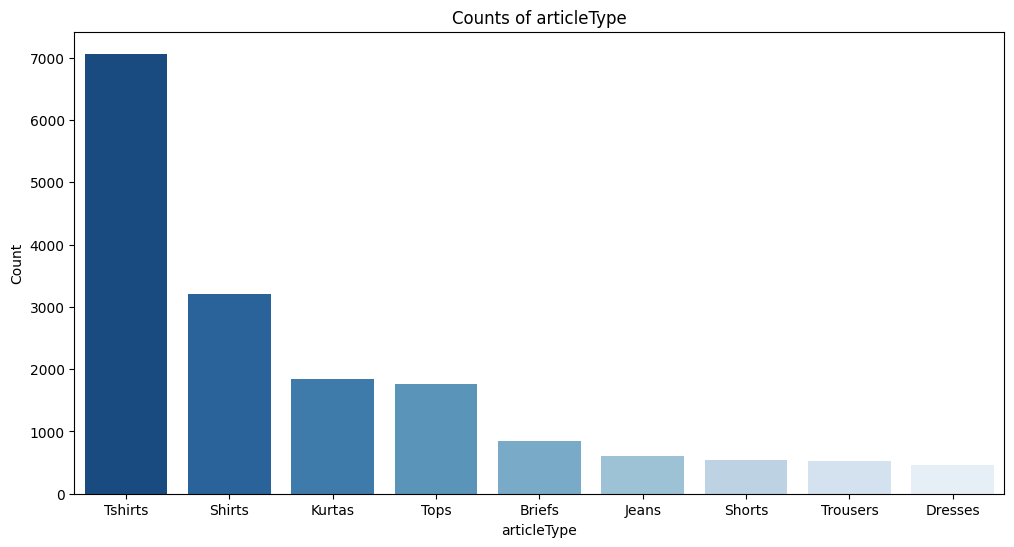

In [ ]:
# Value Counts
def plot_value_counts(df, cols):
    for col in cols:
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Blues_r")  # Reversed x and y axes
        plt.title(f'Counts of {col}')
        plt.xlabel(col)  # Set x-label as column name
        plt.ylabel('Count')  # Set y-label as 'Count'
        plt.show()

# Columns to plot
cols_to_plot = ['subCategory', 'articleType']

plot_value_counts(df, cols_to_plot)



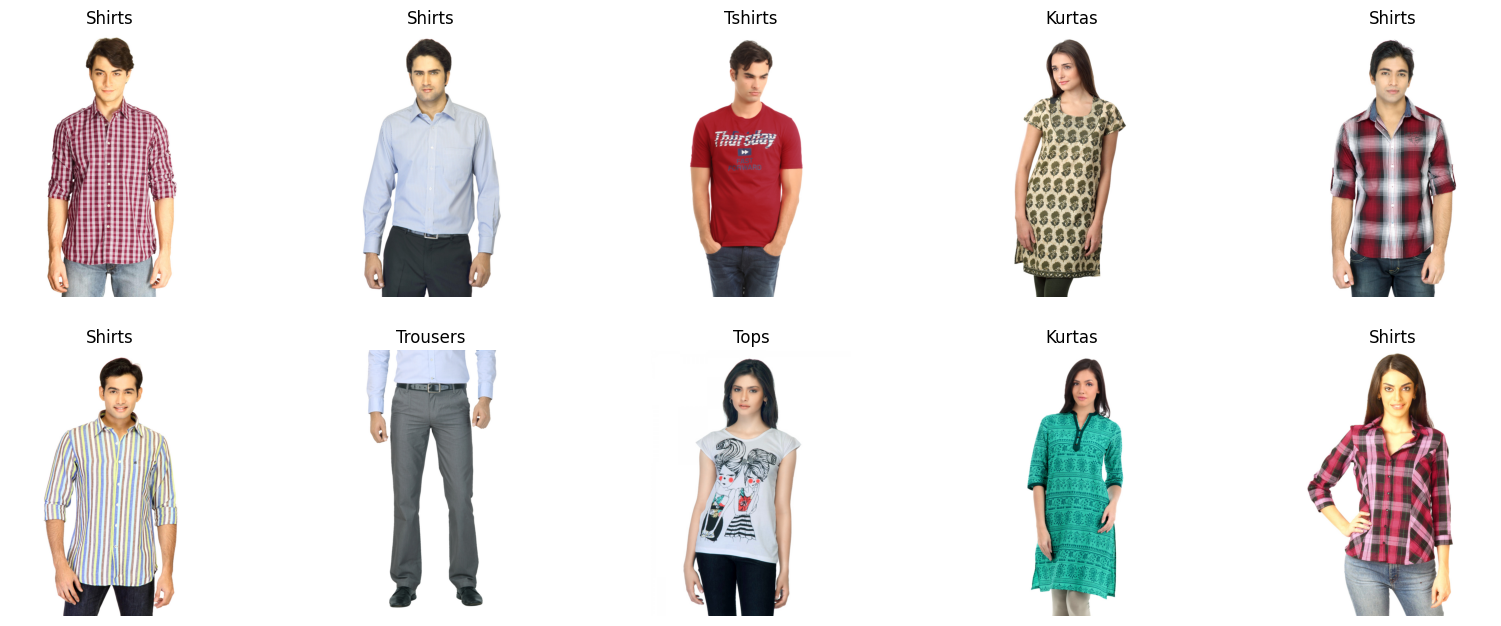

In [ ]:
# Call the function
display_images(df, 10)

## 1.4 image data cleaning

In [ ]:
# Load in all the images from the remaining rows and convert them to numpy arrays with img_to_array function in Keras
data = []
labels = []
# Reading all the images and processing the data in them


IX = 80
IY = 60

invalid_ids = []

for name in df.id:
    try:
        image = cv2.imread('/content/fashion-dataset/images/' + str(name) + '.jpg')
        if image is not None:  # Check if the image loaded successfully
            image = cv2.resize(image, (IX, IY))
            image = img_to_array(image)
            data.append(image)

            # Fetch the label for this image
            label = df[df['id'] == name]['articleType'].values[0]
            labels.append(label)
        else:
            invalid_ids.append(name)
    except FileNotFoundError:
        # Images for certain IDs are missing, so they are not added to the dataset
        invalid_ids.append(name)

print("Invalid IDs:")
print(invalid_ids)
count_invalid_ids = len(invalid_ids)
print("Number of invalid IDs:", count_invalid_ids)

Invalid IDs:
[39403, 39410, 39401, 39425]
Number of invalid IDs: 4


In [ ]:
# create binary vectors as the outputs of the model,making labels suitable for multi-label classification tasks.



# creating a binary vector for the input labels

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

print(mlb.classes_)
print(labels[0])


AttributeError: ignored

In [ ]:
print(mlb.classes_)

[0 1]


In [ ]:
# Convert data and labels to numpy arrays
data = np.array(data, dtype="float") / 255.0  # Normalize pixel values to [0, 1]
labels = np.array(labels)

print("Shape of data:", data.shape)
print("Shape of labels:", labels.shape)


Shape of data: (16873, 60, 80, 3)
Shape of labels: (16873, 9)


In [ ]:
np.save('/content/drive/My Drive/processed_images2.npy', data)

In [ ]:
# Save the labels
np.save('/content/drive/My Drive/labels_cleaned2.npy', labels)


In [ ]:
print("Shape of data:", data.shape)
print("Shape of labels:", labels.shape)


Shape of data: (16873, 60, 80, 3)
Shape of labels: (16873, 9)


# 2 Modeling

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data, labels, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

In [ ]:
import time
import numpy as np
from sklearn.metrics import classification_report

## 2.1 VGG16

### 2.1.1 Baseline Model

In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=10, batch_size=32)

score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")


Epoch 1/10
422/422 [==============================] - 5s 10ms/step - loss: 0.1484 - accuracy: 0.7288 - val_loss: 0.1049 - val_accuracy: 0.8050
Epoch 2/10
422/422 [==============================] - 4s 9ms/step - loss: 0.1058 - accuracy: 0.8087 - val_loss: 0.0930 - val_accuracy: 0.8210
Epoch 3/10
422/422 [==============================] - 4s 9ms/step - loss: 0.0957 - accuracy: 0.8253 - val_loss: 0.0884 - val_accuracy: 0.8299
Epoch 4/10
422/422 [==============================] - 4s 9ms/step - loss: 0.0895 - accuracy: 0.8414 - val_loss: 0.0852 - val_accuracy: 0.8405
Epoch 5/10
422/422 [==============================] - 4s 9ms/step - loss: 0.0843 - accuracy: 0.8498 - val_loss: 0.0845 - val_accuracy: 0.8400
Epoch 6/10
422/422 [==============================] - 4s 9ms/step - loss: 0.0811 - accuracy: 0.8552 - val_loss: 0.0796 - val_accuracy: 0.8435
Epoch 7/10
422/422 [==============================] - 4s 9ms/step - loss: 0.0777 - accuracy: 0.8603 - val_loss: 0.0808 - val_accuracy: 0.8500
Epoch

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Create a dictionary with the classification report metrics
classification_report = {
    'Class': ['Briefs', 'Dresses', 'Jeans', 'Kurtas', 'Shirts', 'Shorts', 'Tops', 'Trousers', 'Tshirts'],
    'Precision': [1.00, 0.77, 0.96, 0.89, 0.95, 0.94, 0.63, 0.93, 0.89],
    'Recall': [0.98, 0.53, 0.80, 0.79, 0.79, 0.98, 0.49, 0.86, 0.92],
    'F1-score': [0.99, 0.62, 0.87, 0.84, 0.86, 0.96, 0.55, 0.90, 0.91],
    'Support': [83, 57, 54, 194, 315, 46, 165, 50, 724]
}

# Create a pandas DataFrame from the classification report dictionary
df = pd.DataFrame(classification_report)

# Print the DataFrame
print(df)


      Class  Precision  Recall  F1-score  Support
0    Briefs       1.00    0.98      0.99       83
1   Dresses       0.77    0.53      0.62       57
2     Jeans       0.96    0.80      0.87       54
3    Kurtas       0.89    0.79      0.84      194
4    Shirts       0.95    0.79      0.86      315
5    Shorts       0.94    0.98      0.96       46
6      Tops       0.63    0.49      0.55      165
7  Trousers       0.93    0.86      0.90       50
8   Tshirts       0.89    0.92      0.91      724


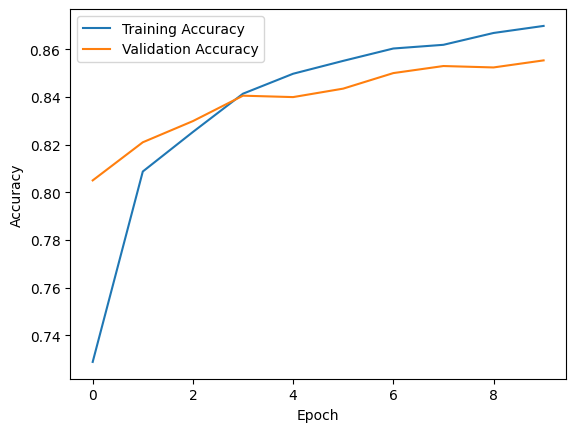

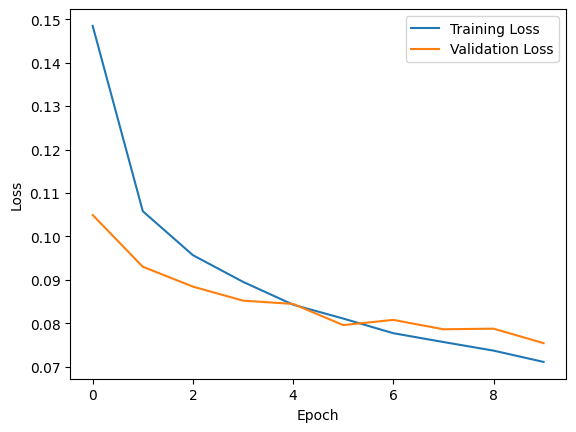

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.1.2 Model 2 - add the data augmentation

In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# add the data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(trainX, trainY, batch_size=32)
validation_generator = datagen_val.flow(valX, valY, batch_size=32)

history = model.fit(
    train_generator,
    steps_per_epoch = len(trainX) // 32,
    validation_data = validation_generator,
    validation_steps = len(valX) // 32,
    epochs = 10)




Epoch 1/10
421/421 [==============================] - 18s 40ms/step - loss: 0.1865 - accuracy: 0.6487 - val_loss: 0.1305 - val_accuracy: 0.7350
Epoch 2/10
421/421 [==============================] - 17s 39ms/step - loss: 0.1433 - accuracy: 0.7328 - val_loss: 0.1157 - val_accuracy: 0.7782
Epoch 3/10
421/421 [==============================] - 17s 40ms/step - loss: 0.1330 - accuracy: 0.7469 - val_loss: 0.1187 - val_accuracy: 0.7644
Epoch 4/10
421/421 [==============================] - 17s 40ms/step - loss: 0.1267 - accuracy: 0.7595 - val_loss: 0.1164 - val_accuracy: 0.7710
Epoch 5/10
421/421 [==============================] - 17s 39ms/step - loss: 0.1219 - accuracy: 0.7685 - val_loss: 0.1081 - val_accuracy: 0.7891
Epoch 6/10
421/421 [==============================] - 17s 39ms/step - loss: 0.1188 - accuracy: 0.7736 - val_loss: 0.1059 - val_accuracy: 0.7927
Epoch 7/10
421/421 [==============================] - 17s 40ms/step - loss: 0.1174 - accuracy: 0.7786 - val_loss: 0.1118 - val_accuracy:

In [ ]:

score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.1062 - accuracy: 0.7860
Validation Loss: 0.10624698549509048
Validation Accuracy: 0.7860106825828552
Test loss: 0.1051173284649849
Test accuracy: 0.7962085604667664
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.94      0.97        83
     Dresses       1.00      0.18      0.30        57
       Jeans       0.95      0.67      0.78        54
      Kurtas       0.89      0.57      0.69       194
      Shirts       0.94      0.69      0.80       315
      Shorts       0.89      0.74      0.81        46
        Tops       0.50      0.38      0.43       165
    Trousers       0.86      0.76      0.81        50
     Tshirts       0.82      0.93      0.87       724

   micro avg       0.83      0.74      0.79      1688
   macro avg       0.87      0.65      0.72      1688
weighted avg       0.84      0.74      0.77      1688
 samples avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.1.3 Model 3 - Unfreezing the last 4 layers of the base model and using a smaller learning rate during this fine-tuning process

In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)


# Use a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),  # smaller learning rate
              metrics=['accuracy'])

# Fine-tune the model
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=10, batch_size=32)


Epoch 1/10
422/422 [==============================] - 16s 23ms/step - loss: 0.1751 - accuracy: 0.7093 - val_loss: 0.0837 - val_accuracy: 0.8394
Epoch 2/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0874 - accuracy: 0.8612 - val_loss: 0.0652 - val_accuracy: 0.8832
Epoch 3/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0703 - accuracy: 0.8921 - val_loss: 0.0630 - val_accuracy: 0.8892
Epoch 4/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0585 - accuracy: 0.9109 - val_loss: 0.0543 - val_accuracy: 0.9046
Epoch 5/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0512 - accuracy: 0.9199 - val_loss: 0.0515 - val_accuracy: 0.9129
Epoch 6/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0443 - accuracy: 0.9308 - val_loss: 0.0516 - val_accuracy: 0.9087
Epoch 7/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0379 - accuracy: 0.9436 - val_loss: 0.0548 - val_accuracy: 0.908

In [ ]:

score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.9289
Validation Loss: 0.0494927316904068
Validation Accuracy: 0.9288678169250488
Test loss: 0.050130363553762436
Test accuracy: 0.920616090297699
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.70      0.89      0.78        57
       Jeans       0.94      0.89      0.91        54
      Kurtas       0.98      0.88      0.93       194
      Shirts       0.94      0.97      0.95       315
      Shorts       1.00      0.98      0.99        46
        Tops       0.80      0.59      0.68       165
    Trousers       0.94      0.90      0.92        50
     Tshirts       0.95      0.95      0.95       724

   micro avg       0.93      0.91      0.92      1688
   macro avg       0.92      0.89      0.90      1688
weighted avg       0.93      0.91      0.92      1688
 samples avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


add earlystopping on the model above.

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Use a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),  # smaller learning rate
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fine-tune the model
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
422/422 [==============================] - 14s 22ms/step - loss: 0.1604 - accuracy: 0.7299 - val_loss: 0.0884 - val_accuracy: 0.8394
Epoch 2/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0824 - accuracy: 0.8677 - val_loss: 0.0661 - val_accuracy: 0.8820
Epoch 3/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0657 - accuracy: 0.8960 - val_loss: 0.0605 - val_accuracy: 0.8838
Epoch 4/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0560 - accuracy: 0.9109 - val_loss: 0.0558 - val_accuracy: 0.8927
Epoch 5/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0480 - accuracy: 0.9227 - val_loss: 0.0565 - val_accuracy: 0.9057
Epoch 6/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0428 - accuracy: 0.9310 - val_loss: 0.0536 - val_accuracy: 0.9004
Epoch 7/10
422/422 [==============================] - 9s 21ms/step - loss: 0.0356 - accuracy: 0.9450 - val_loss: 0.0480 - val_accuracy: 0.913

In [ ]:

score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 0.9235
Validation Loss: 0.04806926101446152
Validation Accuracy: 0.9235329031944275
Test loss: 0.0415622778236866
Test accuracy: 0.9283175468444824
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.87      0.72      0.79        57
       Jeans       0.94      0.93      0.93        54
      Kurtas       0.96      0.94      0.95       194
      Shirts       0.97      0.94      0.96       315
      Shorts       0.98      0.98      0.98        46
        Tops       0.70      0.81      0.75       165
    Trousers       0.96      0.88      0.92        50
     Tshirts       0.97      0.94      0.96       724

   micro avg       0.94      0.92      0.93      1688
   macro avg       0.93      0.90      0.91      1688
weighted avg       0.94      0.92      0.93      1688
 samples avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt

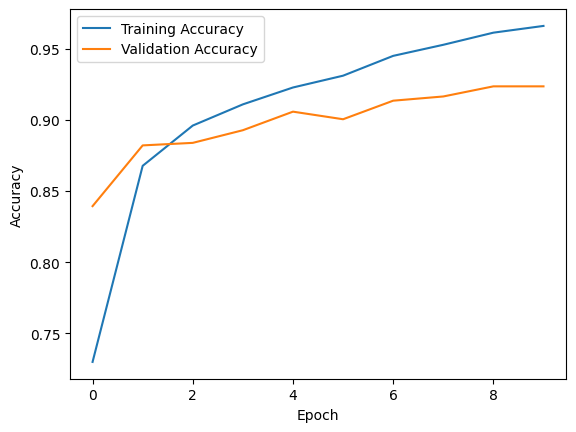

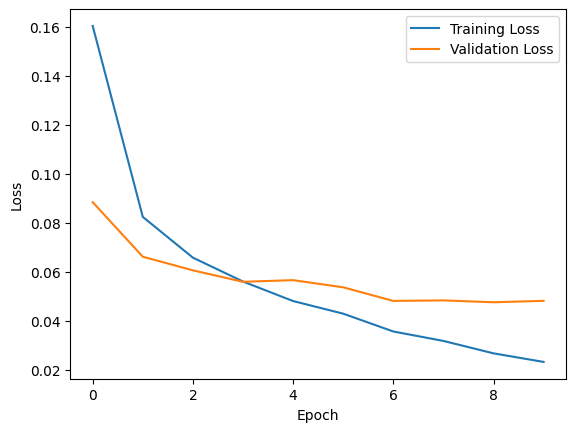

In [ ]:


# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 2.1.4 Model 4 - add data augmentation

In [ ]:
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Use a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),  # smaller learning rate
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# Fine-tune the model
history = model.fit(datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(valX, valY),
                    epochs=10,
                    callbacks=[early_stopping])



Epoch 1/10
422/422 [==============================] - 23s 42ms/step - loss: 0.1959 - accuracy: 0.6636 - val_loss: 0.0972 - val_accuracy: 0.8287
Epoch 2/10
422/422 [==============================] - 18s 42ms/step - loss: 0.1021 - accuracy: 0.8311 - val_loss: 0.0807 - val_accuracy: 0.8483
Epoch 3/10
422/422 [==============================] - 17s 41ms/step - loss: 0.0833 - accuracy: 0.8654 - val_loss: 0.0705 - val_accuracy: 0.8749
Epoch 4/10
422/422 [==============================] - 17s 41ms/step - loss: 0.0752 - accuracy: 0.8767 - val_loss: 0.0724 - val_accuracy: 0.8708
Epoch 5/10
422/422 [==============================] - 17s 41ms/step - loss: 0.0673 - accuracy: 0.8880 - val_loss: 0.0626 - val_accuracy: 0.8886
Epoch 6/10
422/422 [==============================] - 17s 41ms/step - loss: 0.0629 - accuracy: 0.8966 - val_loss: 0.0564 - val_accuracy: 0.8998
Epoch 7/10
422/422 [==============================] - 17s 41ms/step - loss: 0.0567 - accuracy: 0.9056 - val_loss: 0.0536 - val_accuracy:

In [ ]:

score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.0520 - accuracy: 0.9105
Validation Loss: 0.051993388682603836
Validation Accuracy: 0.9104920029640198
Test loss: 0.049451325088739395
Test accuracy: 0.9182464480400085
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.94      0.54      0.69        57
       Jeans       0.94      0.93      0.93        54
      Kurtas       0.91      0.95      0.93       194
      Shirts       0.97      0.94      0.95       315
      Shorts       1.00      0.96      0.98        46
        Tops       0.75      0.62      0.68       165
    Trousers       0.94      0.88      0.91        50
     Tshirts       0.94      0.96      0.95       724

   micro avg       0.93      0.91      0.92      1688
   macro avg       0.93      0.86      0.89      1688
weighted avg       0.93      0.91      0.91      1688
 samples avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


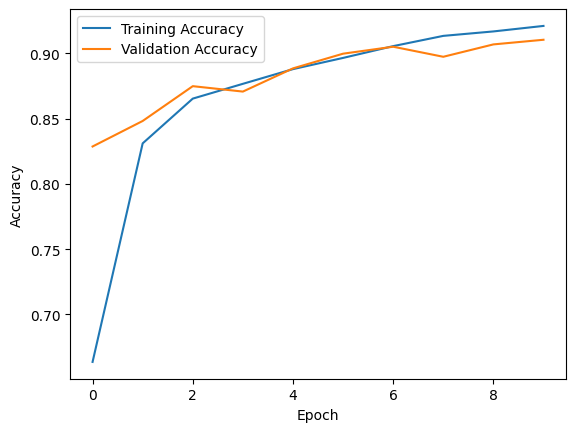

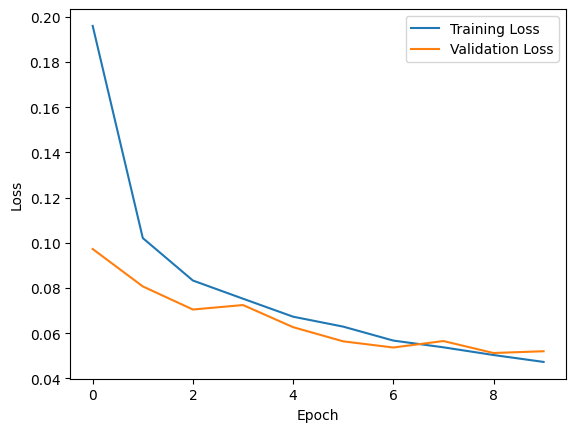

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The accuracy on the type 'Top' and 'Dresses' is lower than the model with unfreezed last 4 layers and earlystopping.

### 2.1.5 Model 5 - Try using another optimizer

In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [ ]:

start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Use a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-5, momentum=0.9),  # SGD optimizer with momentum
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fine-tune the model
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=10, batch_size=32, callbacks=[early_stopping])




/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
422/422 [==============================] - 27s 61ms/step - loss: 0.6414 - accuracy: 0.1486 - val_loss: 0.4110 - val_accuracy: 0.3977
Epoch 2/10
422/422 [==============================] - 26s 61ms/step - loss: 0.3897 - accuracy: 0.2880 - val_loss: 0.2990 - val_accuracy: 0.4155
Epoch 3/10
422/422 [==============================] - 25s 60ms/step - loss: 0.3297 - accuracy: 0.3646 - val_loss: 0.2688 - val_accuracy: 0.4221
Epoch 4/10
422/422 [==============================] - 25s 60ms/step - loss: 0.3062 - accuracy: 0.4018 - val_loss: 0.2524 - val_accuracy: 0.4422
Epoch 5/10
422/422 [==============================] - 25s 60ms/step - loss: 0.2886 - accuracy: 0.4319 - val_loss: 0.2386 - val_accuracy: 0.4754
Epoch 6/10
422/422 [==============================] - 25s 60ms/step - loss: 0.2735 - accuracy: 0.4641 - val_loss: 0.2264 - val_accuracy: 0.5216
Epoch 7/10
422/422 [==============================] - 25s 60ms/step - loss: 0.2616 - accuracy: 0.4919 - val_loss: 0.2151 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

In [ ]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import SGD
from math import exp


In [ ]:

start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Use a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-5, momentum=0.9),  # SGD optimizer with momentum
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define learning rate schedule
def lr_schedule(epoch):
    return 1e-5 * exp(-epoch / 10.)

lr_scheduler = LearningRateScheduler(lr_schedule)

# Fine-tune the model
history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=50, batch_size=32,
                    callbacks=[early_stopping, lr_scheduler])  # use more epochs



Epoch 1/50
422/422 [==============================] - 27s 62ms/step - loss: 0.5193 - accuracy: 0.2809 - val_loss: 0.3745 - val_accuracy: 0.4090 - lr: 1.0000e-05
Epoch 2/50
422/422 [==============================] - 26s 61ms/step - loss: 0.3658 - accuracy: 0.3378 - val_loss: 0.2956 - val_accuracy: 0.4096 - lr: 9.0484e-06
Epoch 3/50
422/422 [==============================] - 25s 60ms/step - loss: 0.3224 - accuracy: 0.3694 - val_loss: 0.2745 - val_accuracy: 0.4108 - lr: 8.1873e-06
Epoch 4/50
422/422 [==============================] - 25s 60ms/step - loss: 0.3065 - accuracy: 0.3884 - val_loss: 0.2646 - val_accuracy: 0.4120 - lr: 7.4082e-06
Epoch 5/50
422/422 [==============================] - 25s 60ms/step - loss: 0.2983 - accuracy: 0.4010 - val_loss: 0.2575 - val_accuracy: 0.4167 - lr: 6.7032e-06
Epoch 6/50
422/422 [==============================] - 25s 60ms/step - loss: 0.2901 - accuracy: 0.4137 - val_loss: 0.2514 - val_accuracy: 0.4226 - lr: 6.0653e-06
Epoch 7/50
422/422 [==============

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

The relatively low accuracy in the type 'Tops' and 'Dresses' may due to the imbalance of the dataset. The dresses only have 464 counts in the dataset,while the largest counts which is T-shirts in the dataset is 7065. Even though the 'Tops' category is more represented,this type may have some features making the model hard to distingush them from other categories.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam


In [ ]:
start_time = time.time()

def calculate_class_weights(y):
    """
    Calculate class weights for given labels.

    :param y: multi-label binary matrix of labels
    :return: dictionary with class weights
    """
    num_samples, num_classes = y.shape
    class_counts = np.sum(y, axis=0)
    class_weights = {i: num_samples / class_counts[i] for i in range(num_classes)}

    return class_weights

class_weights = calculate_class_weights(trainY)

# Apply data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Compute quantities required for featurewise normalization
datagen.fit(trainX)

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Use a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=Adam(1e-5),  # smaller learning rate
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model.fit(datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(valX, valY),
                    epochs=10,
                    class_weight=class_weights,
                    callbacks=[early_stopping])



Epoch 1/10
422/422 [==============================] - 21s 47ms/step - loss: 2.6541 - accuracy: 0.4411 - val_loss: 0.1950 - val_accuracy: 0.5756
Epoch 2/10
422/422 [==============================] - 19s 46ms/step - loss: 1.3713 - accuracy: 0.7367 - val_loss: 0.1439 - val_accuracy: 0.7226
Epoch 3/10
422/422 [==============================] - 19s 45ms/step - loss: 1.0489 - accuracy: 0.8032 - val_loss: 0.1118 - val_accuracy: 0.8074
Epoch 4/10
422/422 [==============================] - 19s 46ms/step - loss: 0.8826 - accuracy: 0.8250 - val_loss: 0.1086 - val_accuracy: 0.8038
Epoch 5/10
422/422 [==============================] - 19s 45ms/step - loss: 0.7818 - accuracy: 0.8466 - val_loss: 0.1010 - val_accuracy: 0.8115
Epoch 6/10
422/422 [==============================] - 20s 46ms/step - loss: 0.7090 - accuracy: 0.8585 - val_loss: 0.1085 - val_accuracy: 0.8002
Epoch 7/10
422/422 [==============================] - 19s 45ms/step - loss: 0.6632 - accuracy: 0.8653 - val_loss: 0.1034 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.1015 - accuracy: 0.8204
Validation Loss: 0.10152723640203476
Validation Accuracy: 0.8203912377357483
Test loss: 0.10282689332962036
Test accuracy: 0.8110189437866211
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       0.99      0.98      0.98        83
     Dresses       0.56      0.86      0.68        57
       Jeans       1.00      0.52      0.68        54
      Kurtas       0.86      0.91      0.89       194
      Shirts       0.87      0.87      0.87       315
      Shorts       0.85      0.98      0.91        46
        Tops       0.42      0.31      0.36       165
    Trousers       0.69      0.92      0.79        50
     Tshirts       0.99      0.73      0.84       724

   micro avg       0.86      0.76      0.80      1688
   macro avg       0.80      0.79      0.78      1688
weighted avg       0.87      0.76      0.80      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report

since the new optimizer is not helping the accuracy, we still use the original one which is Adam.

### 2.1.6 Model 6 - Fine-tuning the model with optimizer Adam

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization


In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier to avoid overfitting by adding Dropout
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Use a smaller learning rate for fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),  # smaller learning rate
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# Fine-tune the model
history = model.fit(datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(valX, valY),
                    epochs=10,
                    callbacks=[early_stopping])



Epoch 1/10
422/422 [==============================] - 24s 43ms/step - loss: 0.9081 - accuracy: 0.3252 - val_loss: 0.6019 - val_accuracy: 0.7321
Epoch 2/10
422/422 [==============================] - 18s 42ms/step - loss: 0.7912 - accuracy: 0.5662 - val_loss: 0.5970 - val_accuracy: 0.7546
Epoch 3/10
422/422 [==============================] - 18s 42ms/step - loss: 0.7288 - accuracy: 0.6551 - val_loss: 0.5082 - val_accuracy: 0.8044
Epoch 4/10
422/422 [==============================] - 18s 41ms/step - loss: 0.6829 - accuracy: 0.7113 - val_loss: 0.4768 - val_accuracy: 0.8210
Epoch 5/10
422/422 [==============================] - 17s 41ms/step - loss: 0.6437 - accuracy: 0.7523 - val_loss: 0.4398 - val_accuracy: 0.8317
Epoch 6/10
422/422 [==============================] - 19s 44ms/step - loss: 0.6076 - accuracy: 0.7823 - val_loss: 0.4245 - val_accuracy: 0.8459
Epoch 7/10
422/422 [==============================] - 22s 52ms/step - loss: 0.5762 - accuracy: 0.8052 - val_loss: 0.3978 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.3497 - accuracy: 0.8483
Validation Loss: 0.3496512770652771
Validation Accuracy: 0.8482513427734375
Test loss: 0.3522035479545593
Test accuracy: 0.8542653918266296
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.19      0.79      0.30        57
       Jeans       0.77      0.94      0.85        54
      Kurtas       0.66      0.98      0.79       194
      Shirts       0.77      0.97      0.86       315
      Shorts       0.45      1.00      0.62        46
        Tops       0.49      0.85      0.62       165
    Trousers       0.74      0.96      0.83        50
     Tshirts       0.95      0.87      0.91       724

   micro avg       0.70      0.91      0.79      1688
   macro avg       0.67      0.93      0.75      1688
weighted avg       0.79      0.91      0.83      1688
 samples avg    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After various adjusting, the model 3 and model 4 have the best performance. Next, another network will be applied to classification task.

### 2.1.7 Adding class_weight and specific data aumentation on the model 4

In [ ]:
import time
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras

In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Calculate class weights
class_weights = {0: 1.0, 1: 2.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 2.0, 7: 1.0, 8: 1.0}

# Compile the model with class weights
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# Fine-tune the model with class weights
history = model.fit(datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(valX, valY),
                    epochs=10,
                    callbacks=[early_stopping],
                    class_weight=class_weights)



Epoch 1/10
422/422 [==============================] - 25s 42ms/step - loss: 0.2386 - accuracy: 0.6450 - val_loss: 0.0925 - val_accuracy: 0.8210
Epoch 2/10
422/422 [==============================] - 18s 43ms/step - loss: 0.1345 - accuracy: 0.8216 - val_loss: 0.0778 - val_accuracy: 0.8619
Epoch 3/10
422/422 [==============================] - 18s 42ms/step - loss: 0.1107 - accuracy: 0.8548 - val_loss: 0.0677 - val_accuracy: 0.8803
Epoch 4/10
422/422 [==============================] - 17s 41ms/step - loss: 0.0968 - accuracy: 0.8752 - val_loss: 0.0619 - val_accuracy: 0.8892
Epoch 5/10
422/422 [==============================] - 18s 42ms/step - loss: 0.0883 - accuracy: 0.8863 - val_loss: 0.0639 - val_accuracy: 0.8791
Epoch 6/10
422/422 [==============================] - 18s 43ms/step - loss: 0.0804 - accuracy: 0.8962 - val_loss: 0.0545 - val_accuracy: 0.9004
Epoch 7/10
422/422 [==============================] - 18s 42ms/step - loss: 0.0761 - accuracy: 0.9019 - val_loss: 0.0552 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.9081
Validation Loss: 0.05295969918370247
Validation Accuracy: 0.9081209301948547
Test loss: 0.04935092851519585
Test accuracy: 0.9182464480400085
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.98      0.99        83
     Dresses       0.97      0.54      0.70        57
       Jeans       0.93      0.94      0.94        54
      Kurtas       0.90      0.95      0.93       194
      Shirts       0.98      0.91      0.94       315
      Shorts       0.94      0.98      0.96        46
        Tops       0.82      0.67      0.74       165
    Trousers       0.94      0.90      0.92        50
     Tshirts       0.93      0.97      0.95       724

   micro avg       0.93      0.91      0.92      1688
   macro avg       0.93      0.87      0.90      1688
weighted avg       0.93      0.91      0.92      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


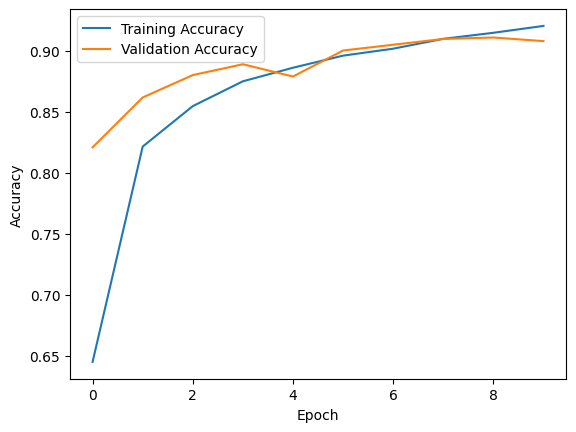

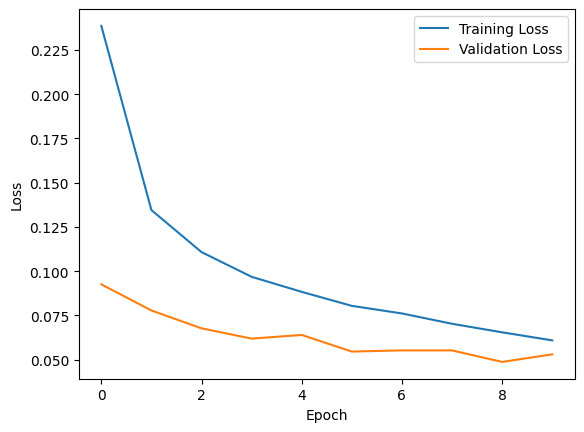

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


avoiding overfitting problem

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier with Dropout and L2 regularization
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Calculate class weights
class_weights = {0: 1.0, 1: 2.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 2.0, 7: 1.0, 8: 1.0}

# Compile the model with class weights
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# Fine-tune the model with class weights and regularization
history = model.fit(datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(valX, valY),
                    epochs=10,
                    callbacks=[early_stopping],
                    class_weight=class_weights)



Epoch 1/10
422/422 [==============================] - 70s 42ms/step - loss: 0.8923 - accuracy: 0.6342 - val_loss: 0.7159 - val_accuracy: 0.7919
Epoch 2/10
422/422 [==============================] - 20s 47ms/step - loss: 0.7182 - accuracy: 0.8094 - val_loss: 0.6278 - val_accuracy: 0.8441
Epoch 3/10
422/422 [==============================] - 18s 42ms/step - loss: 0.6339 - accuracy: 0.8559 - val_loss: 0.5625 - val_accuracy: 0.8749
Epoch 4/10
422/422 [==============================] - 18s 42ms/step - loss: 0.5694 - accuracy: 0.8716 - val_loss: 0.5110 - val_accuracy: 0.8797
Epoch 5/10
422/422 [==============================] - 17s 41ms/step - loss: 0.5149 - accuracy: 0.8817 - val_loss: 0.4679 - val_accuracy: 0.8921
Epoch 6/10
422/422 [==============================] - 18s 43ms/step - loss: 0.4689 - accuracy: 0.8921 - val_loss: 0.4272 - val_accuracy: 0.8856
Epoch 7/10
422/422 [==============================] - 17s 41ms/step - loss: 0.4279 - accuracy: 0.9023 - val_loss: 0.3948 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.3138 - accuracy: 0.9087
Validation Loss: 0.3137619197368622
Validation Accuracy: 0.908713698387146
Test loss: 0.31037193536758423
Test accuracy: 0.9158768057823181
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.98      0.99        83
     Dresses       0.68      0.84      0.75        57
       Jeans       0.96      0.89      0.92        54
      Kurtas       0.93      0.91      0.92       194
      Shirts       0.95      0.95      0.95       315
      Shorts       0.94      0.96      0.95        46
        Tops       0.76      0.68      0.72       165
    Trousers       0.90      0.90      0.90        50
     Tshirts       0.96      0.94      0.95       724

   micro avg       0.92      0.91      0.91      1688
   macro avg       0.90      0.89      0.89      1688
weighted avg       0.92      0.91      0.91      1688
 samples avg    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


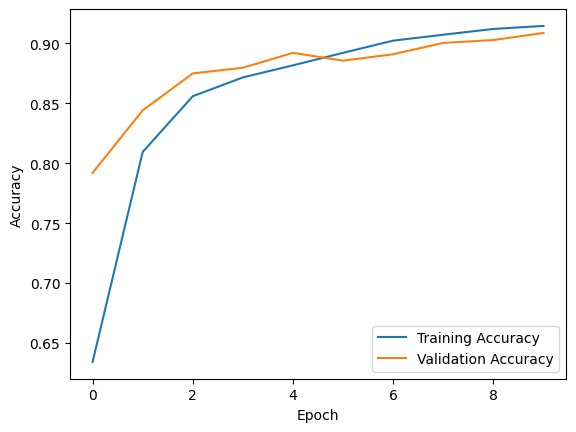

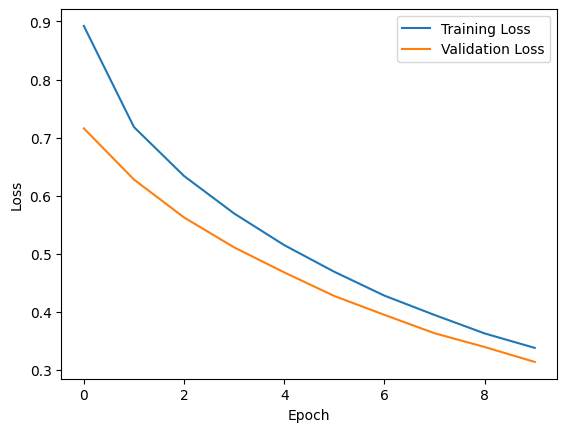

In [ ]:

# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Further improve the accuracy of Dresses and Tops types

In [ ]:
import time
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import tensorflow.keras as keras

In [ ]:
start_time = time.time()

# Define the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Define the custom classifier with Dropout and L2 regularization
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Combine the base model and the classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Calculate class weights
class_weights = {0: 1.0, 1: 2.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 2.0, 7: 1.0, 8: 1.0}

# Compile the model with class weights
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# Customize Data Augmentation for Dresses and Tops
dresses_tops_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Mask for Dresses and Tops
dresses_tops_mask = (trainY[:, 1] == 1) | (trainY[:, 6] == 1)

# Extract Dresses and Tops from the training data
dresses_tops_X = trainX[dresses_tops_mask]
dresses_tops_Y = trainY[dresses_tops_mask]

# Fine-tune the model with class weights and regularization
history = model.fit(datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(valX, valY),
                    epochs=10,
                    callbacks=[early_stopping],
                    class_weight=class_weights)



Epoch 1/10
422/422 [==============================] - 25s 49ms/step - loss: 0.8816 - accuracy: 0.6485 - val_loss: 0.7092 - val_accuracy: 0.8109
Epoch 2/10
422/422 [==============================] - 17s 41ms/step - loss: 0.7138 - accuracy: 0.8283 - val_loss: 0.6287 - val_accuracy: 0.8660
Epoch 3/10
422/422 [==============================] - 18s 42ms/step - loss: 0.6364 - accuracy: 0.8634 - val_loss: 0.5725 - val_accuracy: 0.8838
Epoch 4/10
422/422 [==============================] - 18s 42ms/step - loss: 0.5751 - accuracy: 0.8809 - val_loss: 0.5263 - val_accuracy: 0.8886
Epoch 5/10
422/422 [==============================] - 18s 42ms/step - loss: 0.5289 - accuracy: 0.8877 - val_loss: 0.4802 - val_accuracy: 0.8933
Epoch 6/10
422/422 [==============================] - 18s 42ms/step - loss: 0.4830 - accuracy: 0.9026 - val_loss: 0.4525 - val_accuracy: 0.8921
Epoch 7/10
422/422 [==============================] - 17s 41ms/step - loss: 0.4473 - accuracy: 0.9069 - val_loss: 0.4154 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 0s 7ms/step - loss: 0.3420 - accuracy: 0.9111
Validation Loss: 0.34202393889427185
Validation Accuracy: 0.911084771156311
Test loss: 0.3406754732131958
Test accuracy: 0.9158768057823181
53/53 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.81      0.77      0.79        57
       Jeans       0.96      0.80      0.87        54
      Kurtas       0.97      0.88      0.92       194
      Shirts       0.95      0.96      0.95       315
      Shorts       0.98      0.98      0.98        46
        Tops       0.67      0.81      0.73       165
    Trousers       0.84      0.94      0.89        50
     Tshirts       0.98      0.92      0.95       724

   micro avg       0.92      0.91      0.92      1688
   macro avg       0.91      0.89      0.90      1688
weighted avg       0.93      0.91      0.92      1688
 samples avg    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


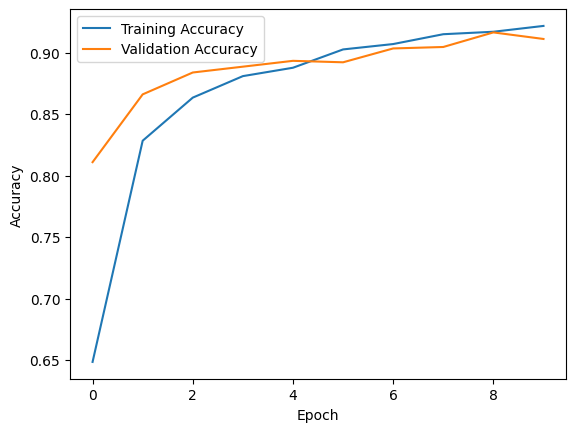

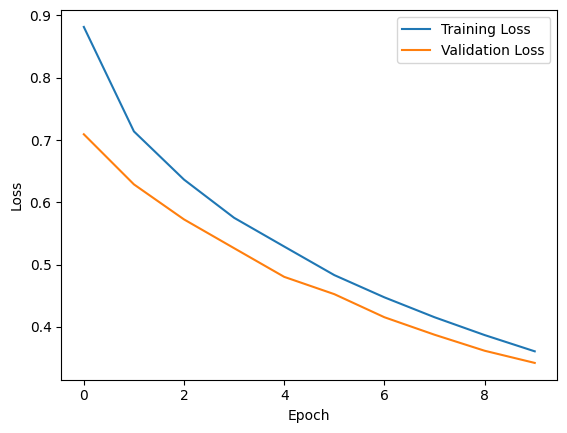

In [ ]:

# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.2 ResNet50

### 2.2.1 Model 1 - Baseline Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D


In [ ]:

start_time = time.time()

num_classes = 9

base_model = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(base_model)
model.add(Dense(num_classes, activation='softmax'))

# Ensure that the base model's layers are not trainable
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=10, batch_size=32)

score = model.evaluate(testX, testY)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/10
422/422 [==============================] - 10s 15ms/step - loss: 1.4368 - accuracy: 0.4510 - val_loss: 1.2475 - val_accuracy: 0.5050
Epoch 2/10
422/422 [==============================] - 5s 11ms/step - loss: 1.1590 - accuracy: 0.5456 - val_loss: 1.0974 - val_accuracy: 0.6040
Epoch 3/10
422/422 [==============================] - 5s 11ms/step - loss: 1.0516 - accuracy: 0.6048 - val_loss: 1.0152 - val_accuracy: 0.6337
Epoch 4/10
422/422 [==============================] - 5s 11ms/step - loss: 0.9865 - accuracy: 0.6311 - val_loss: 0.9664 - val_accuracy: 0.6503
Epoch 5/10
422/422 [==============================] - 5s 11ms/step - loss: 0.9425 - accuracy: 0.6517 - val_loss: 0.9288 - val_accuracy: 0.6698
Epoch 6/10
422/422 [==============================] - 5s 11ms/step - loss: 0.9081 - accuracy: 0.6678 - val_loss: 0.8927 - val_accuracy: 0.6823
Epoch 7/10
422/422 [==============================] - 5s 11ms/step - loss: 0

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 11ms/step - loss: 0.8219 - accuracy: 0.6977
Validation Loss: 0.8219243884086609
Validation Accuracy: 0.6976882219314575
Test loss: 0.8350037932395935
Test accuracy: 0.6836493015289307
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       0.97      0.89      0.93        83
     Dresses       0.00      0.00      0.00        57
       Jeans       0.76      0.81      0.79        54
      Kurtas       0.74      0.59      0.66       194
      Shirts       0.78      0.51      0.62       315
      Shorts       0.88      0.15      0.26        46
        Tops       0.40      0.02      0.05       165
    Trousers       1.00      0.38      0.55        50
     Tshirts       0.82      0.69      0.75       724

   micro avg       0.81      0.55      0.65      1688
   macro avg       0.70      0.45      0.51      1688
weighted avg       0.75      0.55      0.61      1688
 samples avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


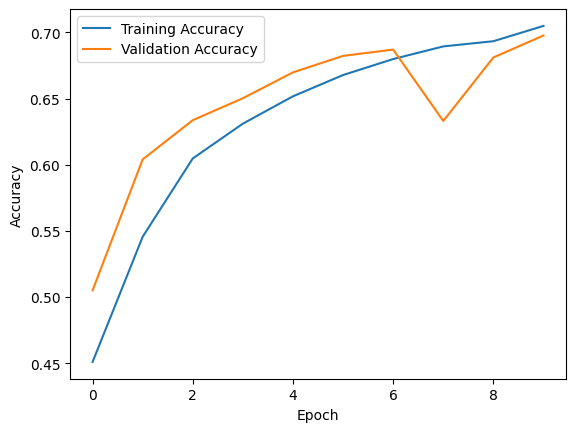

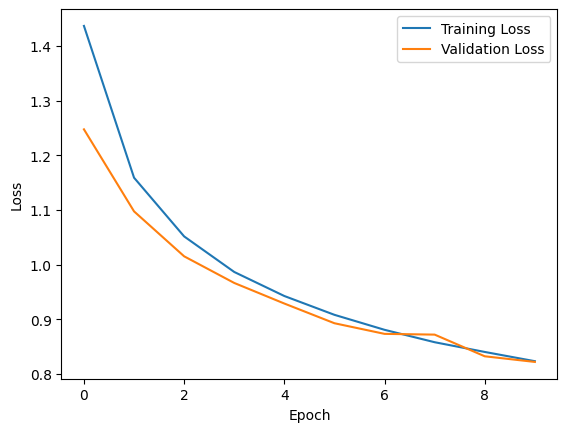

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.2.2 Model 2 - Add classification layers on top of the base model

In [ ]:

start_time = time.time()
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)


# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model and train for more epochs
history = model.fit(
    trainX, trainY,
    batch_size=8,
    epochs=10,  # Train for more epochs
    validation_data=(valX, valY)
)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/10
1688/1688 [==============================] - 24s 11ms/step - loss: 0.2118 - accuracy: 0.5548 - val_loss: 0.1803 - val_accuracy: 0.6331
Epoch 2/10
1688/1688 [==============================] - 16s 10ms/step - loss: 0.1693 - accuracy: 0.6562 - val_loss: 0.1646 - val_accuracy: 0.6645
Epoch 3/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.1533 - accuracy: 0.7002 - val_loss: 0.1469 - val_accuracy: 0.7054
Epoch 4/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.1440 - accuracy: 0.7213 - val_loss: 0.1387 - val_accuracy: 0.7220
Epoch 5/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.1366 - accuracy: 0.7345 - val_loss: 0.1431 - val_accuracy: 0.7078
Epoch 6/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.1326 - accuracy: 0.7430 - val_loss: 0.1329 - val_accuracy: 0.7392
Epoch 7/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.1270 - accuracy: 0.7542 - val_loss: 0.1260 - val_

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 11ms/step - loss: 0.1221 - accuracy: 0.7534
Validation Loss: 0.1221446692943573
Validation Accuracy: 0.7534084320068359
Test loss: 0.12503927946090698
Test accuracy: 0.7553317546844482
53/53 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

      Briefs       0.93      0.98      0.95        83
     Dresses       1.00      0.04      0.07        57
       Jeans       0.91      0.78      0.84        54
      Kurtas       0.83      0.74      0.78       194
      Shirts       0.92      0.55      0.69       315
      Shorts       0.58      0.85      0.69        46
        Tops       0.53      0.32      0.40       165
    Trousers       0.80      0.66      0.73        50
     Tshirts       0.78      0.87      0.82       724

   micro avg       0.79      0.71      0.75      1688
   macro avg       0.81      0.64      0.66      1688
weighted avg       0.80      0.71      0.73      1688
 samples avg 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2.3 Model 3 - add more epoches

In [ ]:

start_time = time.time()

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IY, IX, 3))

# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add classification layers on top of it
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])  # smaller learning rate

# Fit the model
history = model.fit(
    trainX, trainY,
    batch_size=32,
    epochs=30,
    validation_data=(valX, valY)
)




Epoch 1/30
422/422 [==============================] - 10s 15ms/step - loss: 0.1855 - accuracy: 0.6422 - val_loss: 0.2000 - val_accuracy: 0.6740
Epoch 2/30
422/422 [==============================] - 5s 12ms/step - loss: 0.1330 - accuracy: 0.7486 - val_loss: 0.1490 - val_accuracy: 0.6983
Epoch 3/30
422/422 [==============================] - 5s 12ms/step - loss: 0.1208 - accuracy: 0.7733 - val_loss: 0.1615 - val_accuracy: 0.6698
Epoch 4/30
422/422 [==============================] - 5s 12ms/step - loss: 0.1116 - accuracy: 0.7936 - val_loss: 0.1301 - val_accuracy: 0.7564
Epoch 5/30
422/422 [==============================] - 5s 12ms/step - loss: 0.1065 - accuracy: 0.8046 - val_loss: 0.1593 - val_accuracy: 0.6900
Epoch 6/30
422/422 [==============================] - 5s 12ms/step - loss: 0.1015 - accuracy: 0.8113 - val_loss: 0.1333 - val_accuracy: 0.7528
Epoch 7/30
422/422 [==============================] - 5s 12ms/step - loss: 0.0971 - accuracy: 0.8214 - val_loss: 0.1420 - val_accuracy: 0.723

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 10ms/step - loss: 0.1395 - accuracy: 0.7664
Validation Loss: 0.13950221240520477
Validation Accuracy: 0.7664493322372437
Test loss: 0.1374489814043045
Test accuracy: 0.7701421976089478
53/53 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

      Briefs       0.99      0.94      0.96        83
     Dresses       0.90      0.16      0.27        57
       Jeans       0.97      0.67      0.79        54
      Kurtas       0.90      0.80      0.85       194
      Shirts       0.98      0.45      0.61       315
      Shorts       0.70      0.87      0.78        46
        Tops       0.56      0.42      0.48       165
    Trousers       0.89      0.78      0.83        50
     Tshirts       0.75      0.93      0.83       724

   micro avg       0.80      0.74      0.76      1688
   macro avg       0.85      0.67      0.71      1688
weighted avg       0.82      0.74      0.74      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2.4 Model 4 - Add additional dense layers

In [ ]:



start_time = time.time()
# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Fit the model with data augmentation and early stopping
history = model.fit(
    trainX, trainY,
    epochs=30,
    validation_data=(valX, valY),
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/30
422/422 [==============================] - 12s 15ms/step - loss: 0.0528 - accuracy: 0.9118 - val_loss: 0.1079 - val_accuracy: 0.8210
Epoch 2/30
422/422 [==============================] - 5s 13ms/step - loss: 0.0508 - accuracy: 0.9176 - val_loss: 0.1244 - val_accuracy: 0.7979
Epoch 3/30
422/422 [==============================] - 5s 12ms/step - loss: 0.0495 - accuracy: 0.9190 - val_loss: 0.1351 - val_accuracy: 0.7765
Epoch 4/30
53/53 [==============================] - 1s 10ms/step - loss: 0.1531 - accuracy: 0.7789
Validation Loss: 0.15313315391540527
Validation Accuracy: 0.7788974642753601


In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 9ms/step - loss: 0.1531 - accuracy: 0.7789
Validation Loss: 0.15313315391540527
Validation Accuracy: 0.7788974642753601
Test loss: 0.14535073935985565
Test accuracy: 0.7766587734222412
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       0.99      0.95      0.97        83
     Dresses       0.93      0.23      0.37        57
       Jeans       0.82      0.87      0.85        54
      Kurtas       0.55      0.97      0.70       194
      Shirts       0.82      0.84      0.83       315
      Shorts       0.81      0.63      0.71        46
        Tops       0.60      0.09      0.16       165
    Trousers       0.97      0.64      0.77        50
     Tshirts       0.90      0.80      0.85       724

   micro avg       0.80      0.74      0.77      1688
   macro avg       0.82      0.67      0.69      1688
weighted avg       0.82      0.74      0.75      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2.5 Model 5 - Unfreeze more layers

In [ ]:


start_time = time.time()
# Unfreeze more layers
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Fit the model with data augmentation and early stopping
history = model.fit(
    trainX, trainY,
    epochs=30,
    validation_data=(valX, valY),
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/30
422/422 [==============================] - 12s 17ms/step - loss: 0.1430 - accuracy: 0.7318 - val_loss: 0.1213 - val_accuracy: 0.7641
Epoch 2/30
422/422 [==============================] - 6s 14ms/step - loss: 0.1060 - accuracy: 0.7922 - val_loss: 0.1177 - val_accuracy: 0.7694
Epoch 3/30
422/422 [==============================] - 6s 14ms/step - loss: 0.0978 - accuracy: 0.8117 - val_loss: 0.1345 - val_accuracy: 0.7327
Epoch 4/30
422/422 [==============================] - 6s 13ms/step - loss: 0.0916 - accuracy: 0.8253 - val_loss: 0.1169 - val_accuracy: 0.7825
Epoch 5/30
422/422 [==============================] - 6s 14ms/step - loss: 0.0879 - accuracy: 0.8342 - val_loss: 0.1146 - val_accuracy: 0.7718
Epoch 6/30
422/422 [==============================] - 6s 13ms/step - loss: 0.0842 - accuracy: 0.8401 - val_loss: 0.0950 - val_accuracy: 0.8192
Epoch 7/30
422/422 [==============================] - 6s 13ms/step - loss: 0.0799 - accuracy: 0.8480 - val_loss: 0.1017 - val_accuracy: 0.805

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 9ms/step - loss: 0.1075 - accuracy: 0.8222
Validation Loss: 0.10747651755809784
Validation Accuracy: 0.8221695423126221
Test loss: 0.10810115188360214
Test accuracy: 0.8104265332221985
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       0.95      0.99      0.97        83
     Dresses       0.65      0.53      0.58        57
       Jeans       0.94      0.89      0.91        54
      Kurtas       0.84      0.87      0.85       194
      Shirts       0.95      0.68      0.79       315
      Shorts       0.83      0.76      0.80        46
        Tops       0.65      0.39      0.49       165
    Trousers       0.88      0.76      0.82        50
     Tshirts       0.84      0.85      0.85       724

   micro avg       0.85      0.77      0.81      1688
   macro avg       0.84      0.75      0.78      1688
weighted avg       0.85      0.77      0.80      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2.6 Model 6 - add data augmentation

In [ ]:


start_time = time.time()
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# Unfreeze more layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

# Fit the model with data augmentation
history = model.fit(
    datagen.flow(trainX, trainY, batch_size=32),
    epochs=30,
    validation_data=(valX, valY)
)



Epoch 1/30
422/422 [==============================] - 26s 50ms/step - loss: 0.2245 - accuracy: 0.5582 - val_loss: 0.0948 - val_accuracy: 0.8275
Epoch 2/30
422/422 [==============================] - 19s 46ms/step - loss: 0.1880 - accuracy: 0.6145 - val_loss: 0.0947 - val_accuracy: 0.8281
Epoch 3/30
422/422 [==============================] - 18s 42ms/step - loss: 0.1781 - accuracy: 0.6409 - val_loss: 0.0941 - val_accuracy: 0.8263
Epoch 4/30
422/422 [==============================] - 18s 42ms/step - loss: 0.1713 - accuracy: 0.6508 - val_loss: 0.0937 - val_accuracy: 0.8204
Epoch 5/30
422/422 [==============================] - 18s 42ms/step - loss: 0.1666 - accuracy: 0.6637 - val_loss: 0.0925 - val_accuracy: 0.8239
Epoch 6/30
422/422 [==============================] - 18s 43ms/step - loss: 0.1615 - accuracy: 0.6708 - val_loss: 0.0919 - val_accuracy: 0.8287
Epoch 7/30
422/422 [==============================] - 18s 42ms/step - loss: 0.1584 - accuracy: 0.6825 - val_loss: 0.0922 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 10ms/step - loss: 0.0872 - accuracy: 0.8411
Validation Loss: 0.08718877285718918
Validation Accuracy: 0.8411381244659424
Test loss: 0.08590716123580933
Test accuracy: 0.8323459625244141
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.98      0.99        83
     Dresses       0.81      0.30      0.44        57
       Jeans       0.90      0.70      0.79        54
      Kurtas       0.85      0.86      0.86       194
      Shirts       0.93      0.80      0.86       315
      Shorts       0.90      0.76      0.82        46
        Tops       0.62      0.39      0.48       165
    Trousers       0.77      0.72      0.74        50
     Tshirts       0.86      0.92      0.89       724

   micro avg       0.86      0.80      0.83      1688
   macro avg       0.85      0.71      0.76      1688
weighted avg       0.85      0.80      0.82      1688
 samples avg 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2.7 BEST - Model 7 - Fine-tuning on the best trained ResNet50

In [ ]:



start_time = time.time()
# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

# Fit the model with data augmentation and early stopping
history = model.fit(
    trainX, trainY,
    epochs=50,
    validation_data=(valX, valY),
    callbacks=[early_stopping]
)



Epoch 1/50
422/422 [==============================] - 11s 15ms/step - loss: 0.0586 - accuracy: 0.8938 - val_loss: 0.0773 - val_accuracy: 0.8637
Epoch 2/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0483 - accuracy: 0.9164 - val_loss: 0.0763 - val_accuracy: 0.8672
Epoch 3/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0432 - accuracy: 0.9250 - val_loss: 0.0766 - val_accuracy: 0.8708
Epoch 4/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0391 - accuracy: 0.9330 - val_loss: 0.0790 - val_accuracy: 0.8625
Epoch 5/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0364 - accuracy: 0.9390 - val_loss: 0.0779 - val_accuracy: 0.8684


In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 10ms/step - loss: 0.0779 - accuracy: 0.8684
Validation Loss: 0.07792912423610687
Validation Accuracy: 0.8684054613113403
Test loss: 0.07333119213581085
Test accuracy: 0.8720378875732422
53/53 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.70      0.56      0.62        57
       Jeans       0.93      0.94      0.94        54
      Kurtas       0.91      0.89      0.90       194
      Shirts       0.93      0.87      0.90       315
      Shorts       0.95      0.89      0.92        46
        Tops       0.63      0.53      0.58       165
    Trousers       0.85      0.82      0.84        50
     Tshirts       0.90      0.91      0.91       724

   micro avg       0.88      0.85      0.87      1688
   macro avg       0.87      0.82      0.84      1688
weighted avg       0.88      0.85      0.86      1688
 samples avg 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


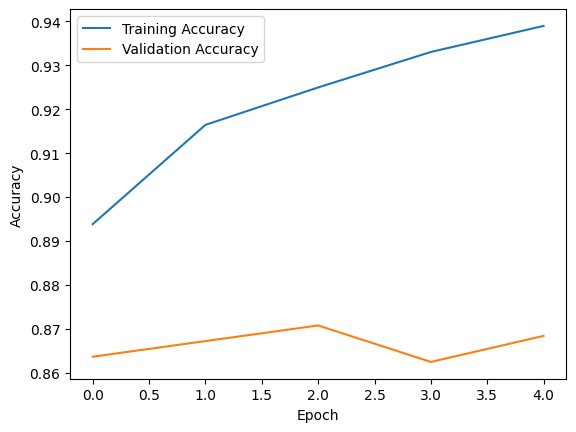

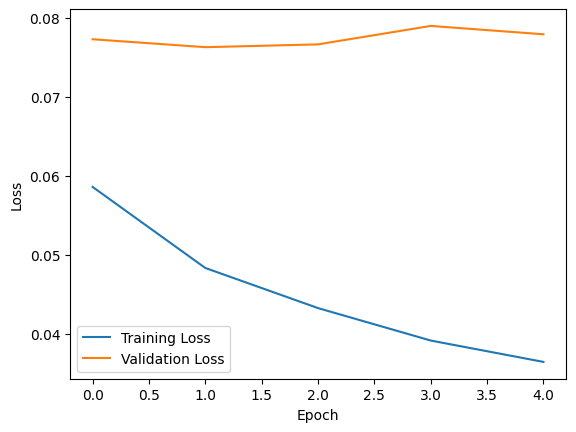

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:


start_time = time.time()

# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

# Fit the model with early stopping
history = model.fit(
    trainX, trainY,
    epochs=50,
    validation_data=(valX, valY),
    callbacks=[early_stopping]
)


Epoch 1/50
422/422 [==============================] - 11s 15ms/step - loss: 0.0324 - accuracy: 0.9483 - val_loss: 0.0795 - val_accuracy: 0.8720
Epoch 2/50
422/422 [==============================] - 5s 13ms/step - loss: 0.0298 - accuracy: 0.9537 - val_loss: 0.0819 - val_accuracy: 0.8684
Epoch 3/50
422/422 [==============================] - 6s 13ms/step - loss: 0.0278 - accuracy: 0.9584 - val_loss: 0.0820 - val_accuracy: 0.8755
Epoch 4/50
422/422 [==============================] - 7s 17ms/step - loss: 0.0261 - accuracy: 0.9601 - val_loss: 0.0832 - val_accuracy: 0.8743


In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 10ms/step - loss: 0.0832 - accuracy: 0.8743
Validation Loss: 0.08319200575351715
Validation Accuracy: 0.8743331432342529
Test loss: 0.07791070640087128
Test accuracy: 0.8732227683067322
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00        83
     Dresses       0.65      0.56      0.60        57
       Jeans       0.96      0.89      0.92        54
      Kurtas       0.93      0.87      0.90       194
      Shirts       0.92      0.89      0.91       315
      Shorts       0.91      0.89      0.90        46
        Tops       0.62      0.53      0.57       165
    Trousers       0.84      0.86      0.85        50
     Tshirts       0.90      0.92      0.91       724

   micro avg       0.88      0.86      0.87      1688
   macro avg       0.86      0.82      0.84      1688
weighted avg       0.88      0.86      0.87      1688
 samples avg 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


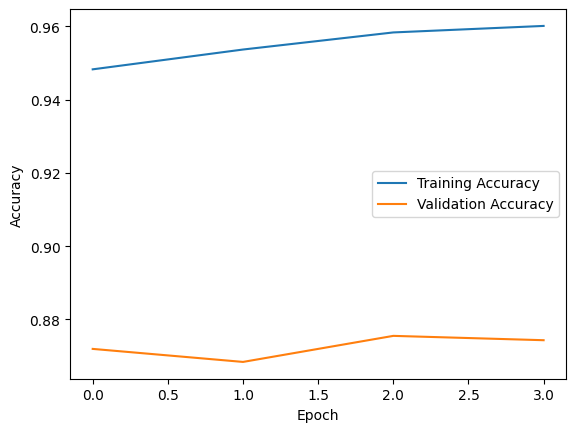

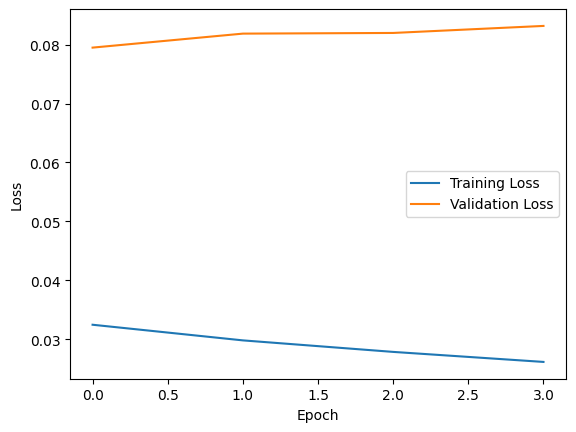

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.2.8 Model 8 - Apply random search

In [ ]:

def build_model(hp):
    # Unfreeze the last few layers in the base model
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    # Add additional dense layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(hp.Int('dense_units', min_value=256, max_value=512, step=128), activation='relu')(x)  # tunable dense layer
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

    # Compile the model with a tunable learning rate
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # number of different hyperparameter combinations to try
    executions_per_trial=3,  # number of times to test each combination, to reduce results' variance
    directory='random_search',
    project_name='apparel_classification'
)

tuner.search_space_summary()

tuner.search(trainX, trainY, epochs=50, validation_data=(valX, valY), callbacks=[early_stopping])

tuner.results_summary()


Trial 5 Complete [00h 07m 43s]
val_accuracy: 0.8610946536064148

Best val_accuracy So Far: 0.861687421798706
Total elapsed time: 00h 25m 59s
Results summary
Results in random_search/apparel_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
dense_units: 512
learning_rate: 0.0001
Score: 0.861687421798706

Trial 4 summary
Hyperparameters:
dense_units: 256
learning_rate: 0.0001
Score: 0.8610946536064148

Trial 0 summary
Hyperparameters:
dense_units: 512
learning_rate: 0.001
Score: 0.8537838459014893

Trial 2 summary
Hyperparameters:
dense_units: 256
learning_rate: 0.01
Score: 0.8506224155426025

Trial 1 summary
Hyperparameters:
dense_units: 512
learning_rate: 0.01
Score: 0.8452875018119812


In [ ]:

IX = 80
IY = 60

# Build the ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IY, IX, 3))
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)


In [ ]:
# Train the model
start_time = time.time()
history = model.fit(trainX, trainY, epochs=50, validation_data=(valX, valY))
end_time = time.time()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(valX, valY)
score = model.evaluate(testX, testY)


Epoch 1/50
422/422 [==============================] - 17s 26ms/step - loss: 0.7704 - accuracy: 0.4378 - val_loss: 0.5106 - val_accuracy: 0.6651
Epoch 2/50
422/422 [==============================] - 8s 20ms/step - loss: 0.5563 - accuracy: 0.5768 - val_loss: 0.3567 - val_accuracy: 0.6787
Epoch 3/50
422/422 [==============================] - 9s 21ms/step - loss: 0.3907 - accuracy: 0.6409 - val_loss: 0.2434 - val_accuracy: 0.7279
Epoch 4/50
422/422 [==============================] - 8s 20ms/step - loss: 0.2709 - accuracy: 0.6830 - val_loss: 0.2116 - val_accuracy: 0.6603
Epoch 5/50
422/422 [==============================] - 8s 20ms/step - loss: 0.2090 - accuracy: 0.7102 - val_loss: 0.1447 - val_accuracy: 0.7546
Epoch 6/50
422/422 [==============================] - 9s 20ms/step - loss: 0.1769 - accuracy: 0.7308 - val_loss: 0.1667 - val_accuracy: 0.6876
Epoch 7/50
422/422 [==============================] - 8s 20ms/step - loss: 0.1609 - accuracy: 0.7455 - val_loss: 0.1341 - val_accuracy: 0.751

In [ ]:
# Predict the classes for the test set
y_pred = model.predict(testX)
y_pred_classes = (y_pred > 0.5).astype(int)


# Generate the classification report
classification_rep = classification_report(testY, y_pred_classes, target_names=class_names)
print(classification_rep)

53/53 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

      Briefs       0.99      0.95      0.97        83
     Dresses       0.94      0.30      0.45        57
       Jeans       0.80      0.96      0.87        54
      Kurtas       0.91      0.87      0.89       194
      Shirts       0.54      0.95      0.69       315
      Shorts       0.82      0.80      0.81        46
        Tops       0.50      0.65      0.57       165
    Trousers       0.83      0.70      0.76        50
     Tshirts       0.96      0.54      0.69       724

   micro avg       0.74      0.70      0.72      1688
   macro avg       0.81      0.75      0.75      1688
weighted avg       0.82      0.70      0.72      1688
 samples avg       0.70      0.70      0.70      1688



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print the time taken, validation loss, and accuracy
print(f"Time taken: {end_time - start_time} seconds")
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])

# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Time taken: 431.8066391944885 seconds
Validation Loss: 0.16305367648601532
Validation Accuracy: 0.7338470816612244
Test loss: 0.15842197835445404


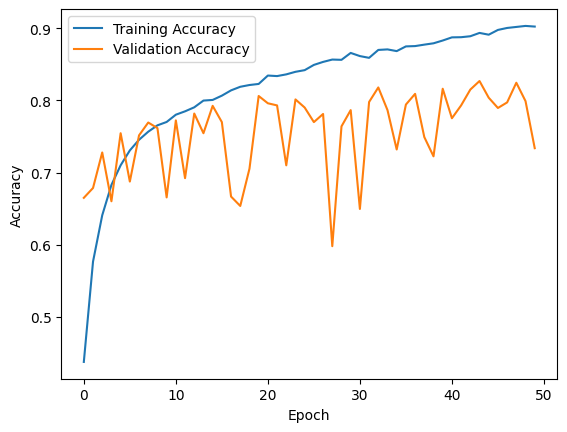

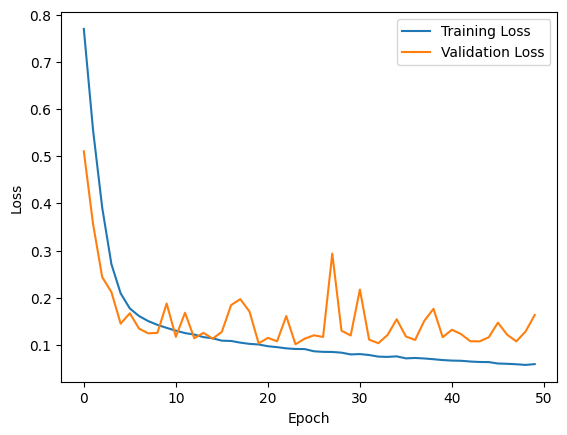

In [ ]:
# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The random search did not manage to get a higher accuracy, so we still fine-tuning on the best model.

### 2.2.9 Model 9 - adding additional dense layers

In [ ]:
from keras import regularizers
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
!pip install keras-tuner
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:


start_time = time.time()

# Unfreeze the last 20 layers in the base model
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

# Fit the model with early stopping
history = model.fit(
    trainX, trainY,
    epochs=50,
    validation_data=(valX, valY),
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/50
422/422 [==============================] - 21s 32ms/step - loss: 0.1321 - accuracy: 0.7414 - val_loss: 0.1227 - val_accuracy: 0.7635
Epoch 2/50
422/422 [==============================] - 12s 29ms/step - loss: 0.1029 - accuracy: 0.7996 - val_loss: 0.1043 - val_accuracy: 0.8056
Epoch 3/50
422/422 [==============================] - 12s 28ms/step - loss: 0.0934 - accuracy: 0.8178 - val_loss: 0.1130 - val_accuracy: 0.7759
Epoch 4/50
422/422 [==============================] - 12s 28ms/step - loss: 0.0881 - accuracy: 0.8284 - val_loss: 0.1363 - val_accuracy: 0.7481
Epoch 5/50
422/422 [==============================] - 12s 28ms/step - loss: 0.0826 - accuracy: 0.8433 - val_loss: 0.0996 - val_accuracy: 0.7996
Epoch 6/50
422/422 [==============================] - 12s 28ms/step - loss: 0.0784 - accuracy: 0.8515 - val_loss: 0.0855 - val_accuracy: 0.8417
Epoch 7/50
422/422 [==============================] - 12s 28ms/step - loss: 0.0745 - accuracy: 0.8571 - val_loss: 0.0900 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

### 2.2.10 Avoid overfitting and improve accuracy of the two types

In [ ]:


start_time = time.time()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

# Fit the model with early stopping, learning rate reduction, and data augmentation
history = model.fit(
    datagen.flow(trainX, trainY, batch_size=50),
    epochs=50,
    validation_data=(valX, valY),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
270/270 [==============================] - 24s 73ms/step - loss: 0.1357 - accuracy: 0.7589 - val_loss: 0.0788 - val_accuracy: 0.8660 - lr: 5.0000e-05
Epoch 2/50
270/270 [==============================] - 17s 61ms/step - loss: 0.1169 - accuracy: 0.7763 - val_loss: 0.0786 - val_accuracy: 0.8583 - lr: 5.0000e-05
Epoch 3/50
270/270 [==============================] - 17s 62ms/step - loss: 0.1111 - accuracy: 0.7872 - val_loss: 0.0766 - val_accuracy: 0.8607 - lr: 5.0000e-05
Epoch 4/50
270/270 [==============================] - 16s 61ms/step - loss: 0.1081 - accuracy: 0.7917 - val_loss: 0.0765 - val_accuracy: 0.8589 - lr: 5.0000e-05
Epoch 5/50
270/270 [==============================] - 16s 61ms/step - loss: 0.1066 - accuracy: 0.7912 - val_loss: 0.0768 - val_accuracy: 0.8577 - lr: 5.0000e-05
Epoch 6/50
270/270 [==============================] - 16s 61ms/step - loss: 0.1064 - accuracy: 0.7953 - val_loss: 0.0774 - val_accuracy: 0.8571 - lr: 5.0000e-05
Epoch 7/50
270/270 [==============

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 9ms/step - loss: 0.0736 - accuracy: 0.8648
Validation Loss: 0.07357114553451538
Validation Accuracy: 0.8648488521575928
Test loss: 0.07240590453147888
Test accuracy: 0.8655213117599487
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.80      0.42      0.55        57
       Jeans       0.93      0.93      0.93        54
      Kurtas       0.89      0.88      0.88       194
      Shirts       0.93      0.84      0.88       315
      Shorts       0.87      0.85      0.86        46
        Tops       0.65      0.50      0.56       165
    Trousers       0.87      0.80      0.83        50
     Tshirts       0.91      0.92      0.91       724

   micro avg       0.89      0.84      0.86      1688
   macro avg       0.87      0.79      0.82      1688
weighted avg       0.88      0.84      0.86      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


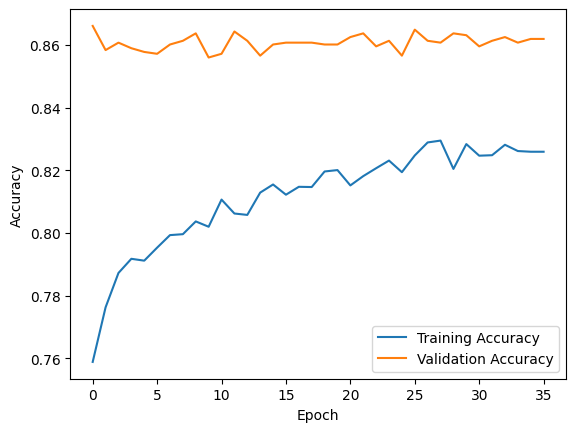

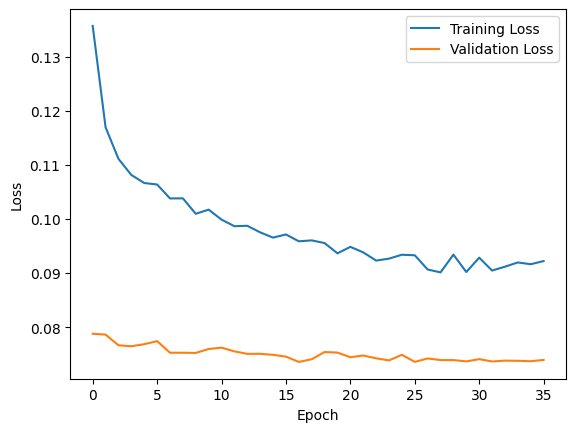

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.2.11 Less overfitting

In [ ]:
start_time = time.time()

# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

# Fit the model with early stopping
history = model.fit(
    trainX, trainY,
    batch_size=32,
    epochs=10,
    validation_data=(valX, valY),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
422/422 [==============================] - 49s 16ms/step - loss: 0.0350 - accuracy: 0.9458 - val_loss: 0.0737 - val_accuracy: 0.8714 - lr: 5.0000e-05
Epoch 2/10
422/422 [==============================] - 5s 12ms/step - loss: 0.0276 - accuracy: 0.9584 - val_loss: 0.0770 - val_accuracy: 0.8690 - lr: 5.0000e-05
Epoch 3/10
422/422 [==============================] - 5s 12ms/step - loss: 0.0244 - accuracy: 0.9678 - val_loss: 0.0783 - val_accuracy: 0.8791 - lr: 5.0000e-05
Epoch 4/10
422/422 [==============================] - 5s 12ms/step - loss: 0.0223 - accuracy: 0.9694 - val_loss: 0.0805 - val_accuracy: 0.8803 - lr: 5.0000e-05
Epoch 5/10
422/422 [==============================] - 5s 12ms/step - loss: 0.0201 - accuracy: 0.9745 - val_loss: 0.0817 - val_accuracy: 0.8779 - lr: 5.0000e-05
Epoch 6/10
422/422 [==============================] - 5s 12ms/step - loss: 0.0187 - accuracy: 0.9767 - val_loss: 0.0849 - val_accuracy: 0.8773 - lr: 5.0000e-05
Epoch 7/10
422/422 [===================

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 9ms/step - loss: 0.0871 - accuracy: 0.8755
Validation Loss: 0.08708477765321732
Validation Accuracy: 0.8755186796188354
Test loss: 0.08253353089094162
Test accuracy: 0.875
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00        83
     Dresses       0.70      0.54      0.61        57
       Jeans       0.96      0.94      0.95        54
      Kurtas       0.91      0.89      0.90       194
      Shirts       0.92      0.89      0.91       315
      Shorts       0.93      0.93      0.93        46
        Tops       0.63      0.59      0.61       165
    Trousers       0.88      0.86      0.87        50
     Tshirts       0.92      0.90      0.91       724

   micro avg       0.89      0.86      0.88      1688
   macro avg       0.87      0.84      0.85      1688
weighted avg       0.89      0.86      0.87      1688
 samples avg       0.86    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


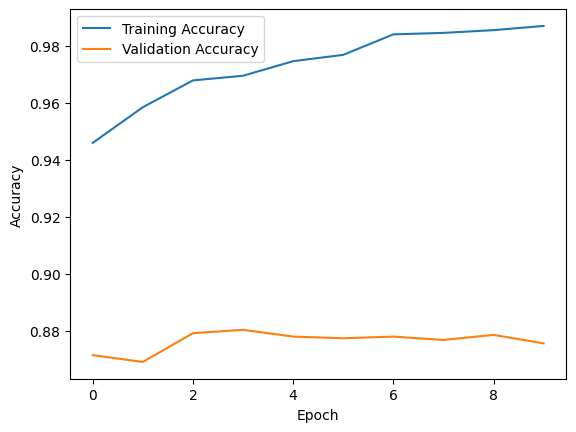

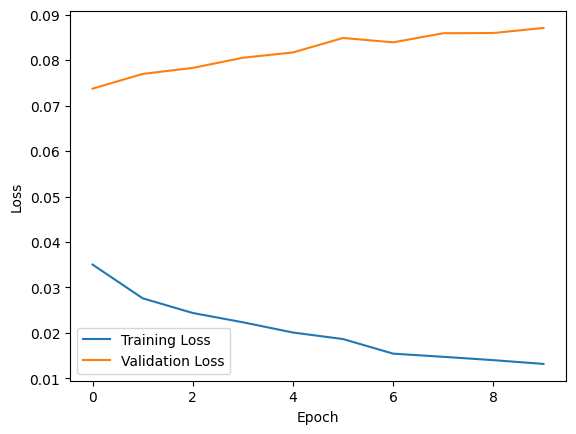

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras import regularizers


In [ ]:
start_time = time.time()

# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.7)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model with early stopping and data augmentation
history = model.fit(
    datagen.flow(trainX, trainY, batch_size=32),
    epochs=10,
    validation_data=(valX, valY),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
422/422 [==============================] - 24s 46ms/step - loss: 0.1979 - accuracy: 0.6803 - val_loss: 0.0864 - val_accuracy: 0.8714 - lr: 1.0000e-05
Epoch 2/10
422/422 [==============================] - 18s 42ms/step - loss: 0.1675 - accuracy: 0.7076 - val_loss: 0.0816 - val_accuracy: 0.8726 - lr: 1.0000e-05
Epoch 3/10
422/422 [==============================] - 18s 42ms/step - loss: 0.1541 - accuracy: 0.7138 - val_loss: 0.0786 - val_accuracy: 0.8708 - lr: 1.0000e-05
Epoch 4/10
422/422 [==============================] - 18s 44ms/step - loss: 0.1498 - accuracy: 0.7163 - val_loss: 0.0761 - val_accuracy: 0.8726 - lr: 1.0000e-05
Epoch 5/10
422/422 [==============================] - 18s 42ms/step - loss: 0.1446 - accuracy: 0.7170 - val_loss: 0.0753 - val_accuracy: 0.8726 - lr: 1.0000e-05
Epoch 6/10
422/422 [==============================] - 18s 42ms/step - loss: 0.1400 - accuracy: 0.7252 - val_loss: 0.0747 - val_accuracy: 0.8714 - lr: 1.0000e-05
Epoch 7/10
422/422 [==============

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 9ms/step - loss: 0.0746 - accuracy: 0.8690
Validation Loss: 0.07461996376514435
Validation Accuracy: 0.8689982295036316
Test loss: 0.07474785298109055
Test accuracy: 0.8631516695022583
53/53 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.99      0.99        83
     Dresses       0.85      0.40      0.55        57
       Jeans       0.93      0.93      0.93        54
      Kurtas       0.87      0.87      0.87       194
      Shirts       0.95      0.85      0.90       315
      Shorts       0.87      0.85      0.86        46
        Tops       0.62      0.44      0.52       165
    Trousers       0.81      0.76      0.78        50
     Tshirts       0.91      0.90      0.90       724

   micro avg       0.89      0.82      0.85      1688
   macro avg       0.87      0.78      0.81      1688
weighted avg       0.88      0.82      0.85      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


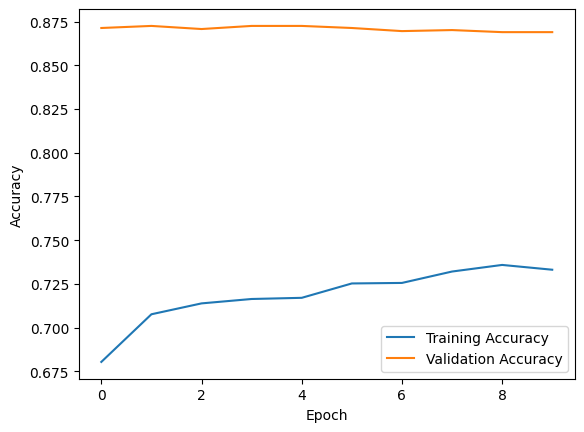

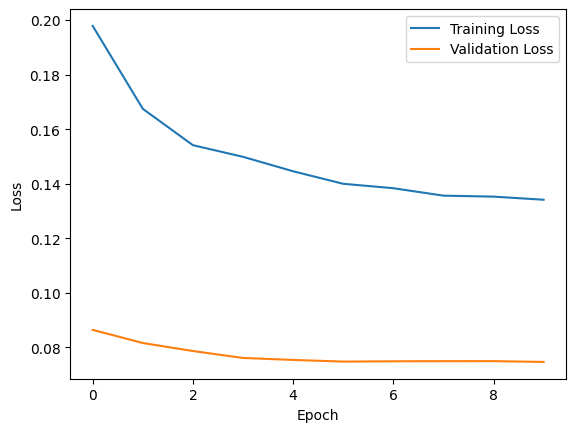

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.2.12 Add additional dense layers and Data augmentation

In [ ]:


start_time = time.time()

# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.8)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model with early stopping and data augmentation
history = model.fit(
    datagen.flow(trainX, trainY, batch_size=32),
    epochs=50,
    validation_data=(valX, valY),
    callbacks=[early_stopping, reduce_lr]
)


422/422 [==============================] - 24s 46ms/step - loss: 0.1875 - accuracy: 0.6272 - val_loss: 0.0772 - val_accuracy: 0.8672 - lr: 1.0000e-05
Epoch 2/50
422/422 [==============================] - 18s 42ms/step - loss: 0.1819 - accuracy: 0.6365 - val_loss: 0.0778 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 3/50
422/422 [==============================] - 18s 43ms/step - loss: 0.1787 - accuracy: 0.6420 - val_loss: 0.0781 - val_accuracy: 0.8613 - lr: 1.0000e-05
Epoch 4/50
422/422 [==============================] - 18s 42ms/step - loss: 0.1775 - accuracy: 0.6391 - val_loss: 0.0789 - val_accuracy: 0.8625 - lr: 1.0000e-05
Epoch 5/50
422/422 [==============================] - 18s 42ms/step - loss: 0.1742 - accuracy: 0.6472 - val_loss: 0.0789 - val_accuracy: 0.8607 - lr: 5.0000e-06
Epoch 6/50
422/422 [==============================] - 18s 43ms/step - loss: 0.1738 - accuracy: 0.6529 - val_loss: 0.0786 - val_accuracy: 0.8613 - lr: 5.0000e-06


In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 9ms/step - loss: 0.0772 - accuracy: 0.8672
Validation Loss: 0.07717662304639816
Validation Accuracy: 0.8672199249267578
Test loss: 0.07764797657728195
Test accuracy: 0.8513033390045166
53/53 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.96      0.98        83
     Dresses       0.84      0.37      0.51        57
       Jeans       0.91      0.91      0.91        54
      Kurtas       0.89      0.83      0.86       194
      Shirts       0.92      0.83      0.88       315
      Shorts       0.97      0.85      0.91        46
        Tops       0.59      0.36      0.45       165
    Trousers       0.81      0.76      0.78        50
     Tshirts       0.90      0.89      0.89       724

   micro avg       0.89      0.80      0.84      1688
   macro avg       0.87      0.75      0.80      1688
weighted avg       0.88      0.80      0.83      1688
 samples avg  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


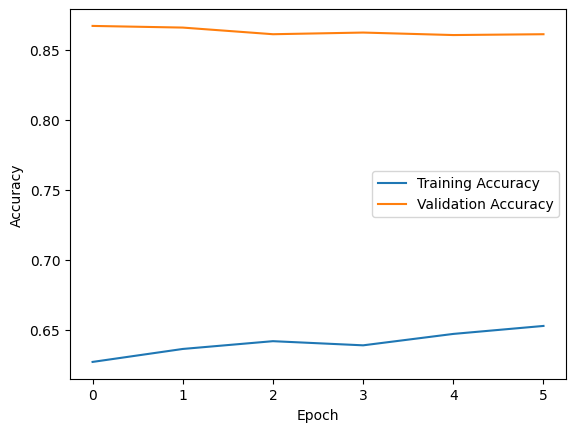

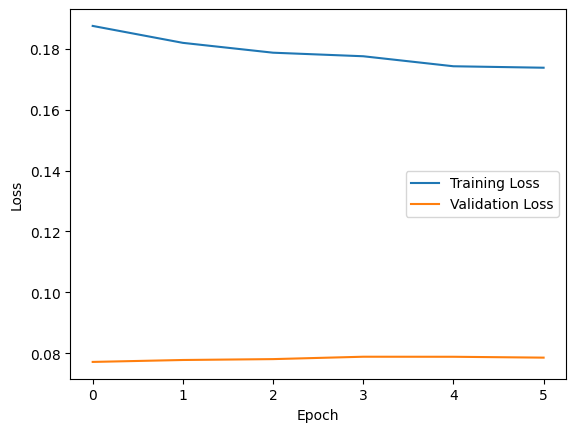

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:


start_time = time.time()

# Unfreeze the last few layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add additional dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
x = Dropout(0.9)(x)
predictions = Dense(len(mlb.classes_), activation='sigmoid')(x)

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model with early stopping and data augmentation
history = model.fit(
    datagen.flow(trainX, trainY, batch_size=32),
    epochs=50,
    validation_data=(valX, valY),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
422/422 [==============================] - 24s 47ms/step - loss: 0.1832 - accuracy: 0.6282 - val_loss: 0.0779 - val_accuracy: 0.8595 - lr: 1.0000e-05
Epoch 2/50
422/422 [==============================] - 18s 43ms/step - loss: 0.1781 - accuracy: 0.6402 - val_loss: 0.0776 - val_accuracy: 0.8607 - lr: 1.0000e-05
Epoch 3/50
422/422 [==============================] - 18s 43ms/step - loss: 0.1772 - accuracy: 0.6388 - val_loss: 0.0775 - val_accuracy: 0.8619 - lr: 1.0000e-05
Epoch 4/50
422/422 [==============================] - 18s 43ms/step - loss: 0.1735 - accuracy: 0.6494 - val_loss: 0.0790 - val_accuracy: 0.8554 - lr: 1.0000e-05
Epoch 5/50
422/422 [==============================] - 18s 43ms/step - loss: 0.1738 - accuracy: 0.6517 - val_loss: 0.0781 - val_accuracy: 0.8554 - lr: 1.0000e-05
Epoch 6/50
422/422 [==============================] - 18s 42ms/step - loss: 0.1737 - accuracy: 0.6480 - val_loss: 0.0783 - val_accuracy: 0.8566 - lr: 1.0000e-05
Epoch 7/50
422/422 [==============

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=mlb.classes_)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 9ms/step - loss: 0.0775 - accuracy: 0.8619
Validation Loss: 0.07746659964323044
Validation Accuracy: 0.8618850111961365
Test loss: 0.07883524894714355
Test accuracy: 0.850710928440094
53/53 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

      Briefs       1.00      0.98      0.99        83
     Dresses       0.82      0.32      0.46        57
       Jeans       0.89      0.89      0.89        54
      Kurtas       0.88      0.84      0.86       194
      Shirts       0.94      0.83      0.88       315
      Shorts       0.97      0.83      0.89        46
        Tops       0.63      0.38      0.47       165
    Trousers       0.84      0.72      0.77        50
     Tshirts       0.91      0.88      0.90       724

   micro avg       0.89      0.80      0.84      1688
   macro avg       0.87      0.74      0.79      1688
weighted avg       0.88      0.80      0.83      1688
 samples avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


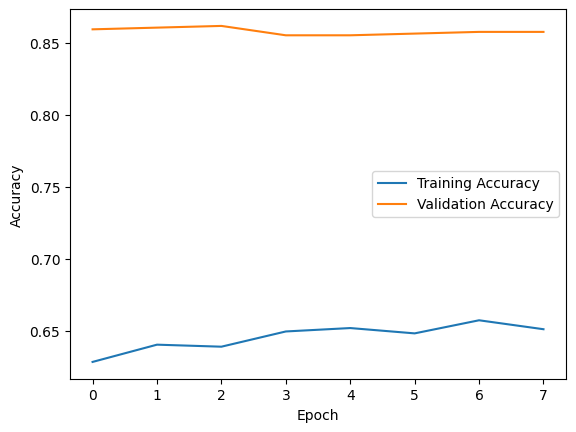

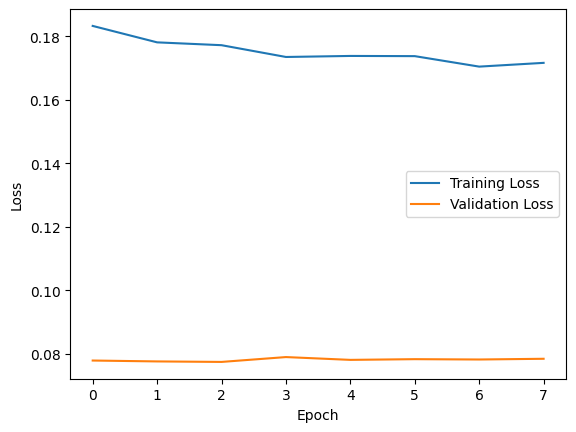

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Assume your labels are already one-hot encoded
one_hot_labels = labels

# Define your class names
class_names = ["Briefs", "Dresses", "Jeans", "Kurtas", "Shirts", "Shorts", "Tops", "Trousers", "Tshirts"]

# Display class names for the first sample
print([class_name for class_name, label in zip(class_names, one_hot_labels[0]) if label == 1])


['Shirts']


### 2.2.13 Bayasian Search

In [ ]:
# Check the shapes
print("Shape of valX:", valX.shape)
print("Shape of valY:", valY.shape)

# Check the data type
print("Data type of valX:", valX.dtype)
print("Data type of valY:", valY.dtype)

# Check the range of values in valX (should be between 0 and 1 if normalized)
print("Min and Max values in valX:", valX.min(), valX.max())

# Check the encoding in valY (should be binary 0s and 1s)
print("Unique values in valY:", np.unique(valY))


Shape of valX: (1687, 60, 80, 3)
Shape of valY: (1687, 9)
Data type of valX: float32
Data type of valY: int64
Min and Max values in valX: 0.0 1.0
Unique values in valY: [0 1]


In [ ]:
valX = valX.astype(np.float32)


In [ ]:
from keras.optimizers import Adam
import optuna
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(f'Shape of trainX: {trainX.shape}')
print(f'Shape of trainY: {trainY.shape}')


Shape of trainX: (13498, 60, 80, 3)
Shape of trainY: (13498, 9)


In [ ]:
IX = 80
IY = 60

In [ ]:
def objective(trial):
    # Define data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

    # Define Keras model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(60, 80, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Unfreeze last few layers
    for layer in base_model.layers[:-trial.suggest_int("unfreeze_layers", 4, 10)]:
        layer.trainable = False

    # Add additional layers
    num_dense_layers = trial.suggest_int("num_dense_layers", 1, 3)
    for i in range(num_dense_layers):
        num_units = trial.suggest_int("num_units_l{}".format(i), 128, 512, log=True)
        dropout_rate = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        x = Dense(num_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    # 9 output classes
    predictions = Dense(9, activation='softmax')(x)

    # Compile the model
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Fit the model with data augmentation and early stopping
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(datagen.flow(trainX, trainY, batch_size=32),
                        epochs=50,
                        validation_data=(valX, valY),
                        callbacks=[early_stopping],
                        verbose=0)

    # Evaluate
    loss, accuracy = model.evaluate(valX, valY, verbose=0)
    return accuracy

# Note: You must also ensure that valX and valY are correctly shaped and prepared validation data


In [ ]:
# Define Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # Increase n_trials for more extensive search


[I 2023-06-14 16:25:57,653] A new study created in memory with name: no-name-e8a0e6dc-ab0b-4eaf-a289-144e4c46c1f5
[I 2023-06-14 16:29:29,886] Trial 0 finished with value: 0.6567872166633606 and parameters: {'unfreeze_layers': 4, 'num_dense_layers': 1, 'num_units_l0': 218, 'dropout_l0': 0.16481437982314784, 'learning_rate': 0.0011264367045614127}. Best is trial 0 with value: 0.6567872166633606.
[I 2023-06-14 16:30:45,636] Trial 1 finished with value: 0.2874926030635834 and parameters: {'unfreeze_layers': 8, 'num_dense_layers': 1, 'num_units_l0': 213, 'dropout_l0': 0.4141046070745581, 'learning_rate': 0.00635252660059581}. Best is trial 0 with value: 0.6567872166633606.
[I 2023-06-14 16:34:00,446] Trial 2 finished with value: 0.5471251010894775 and parameters: {'unfreeze_layers': 7, 'num_dense_layers': 1, 'num_units_l0': 370, 'dropout_l0': 0.3358241863145489, 'learning_rate': 0.0016239099710383983}. Best is trial 0 with value: 0.6567872166633606.
[I 2023-06-14 16:40:37,547] Trial 3 finis

In [ ]:
best_params = study.best_params
print("Best hyperparameters:", best_params)


NameError: ignored

In [ ]:
# Display the best hyperparameters
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:


NameError: ignored

In [ ]:
print(trainX.shape, trainY.shape, valX.shape, valY.shape)


(13498, 60, 80, 3) (13498, 9) (1687, 60, 80, 3) (1687, 9)


In [ ]:
# Check the data type of the first element in trainY and valY
print("Data type of the first element in trainY:", type(trainY[0]))
print("Data type of the first element in valY:", type(valY[0]))

# Check the unique values in trainY and valY
print("Unique values in trainY:", np.unique(trainY))
print("Unique values in valY:", np.unique(valY))


Data type of the first element in trainY: <class 'numpy.ndarray'>
Data type of the first element in valY: <class 'numpy.ndarray'>
Unique values in trainY: [0 1]
Unique values in valY: [0 1]


In [ ]:
# Define the model architecture
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output

# Add custom layers
x = GlobalAveragePooling2D()(x)
x = Dense(505, activation='relu')(x)
x = Dropout(0.3750402503087238)(x)
x = Dense(133, activation='relu')(x)
x = Dropout(0.10781367339787225)(x)
x = Dense(502, activation='relu')(x)
x = Dropout(0.10964437032406854)(x)

# Final output layer
predictions = Dense(9, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze layers
for layer in model.layers[:10]:
    layer.trainable = False
for layer in model.layers[10:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=1.0891812703920868e-05),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Train the model
start_time = time.time()
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(valX, valY))  # Adjust epochs and batch_size if necessary
end_time = time.time()

Epoch 1/10
422/422 [==============================] - 65s 65ms/step - loss: 1.3938 - accuracy: 0.5184 - val_loss: 81.9772 - val_accuracy: 0.4090
Epoch 2/10
422/422 [==============================] - 25s 59ms/step - loss: 0.7057 - accuracy: 0.7721 - val_loss: 7.6951 - val_accuracy: 0.2087
Epoch 3/10
422/422 [==============================] - 25s 58ms/step - loss: 0.4492 - accuracy: 0.8519 - val_loss: 1.1323 - val_accuracy: 0.6574
Epoch 4/10
422/422 [==============================] - 25s 58ms/step - loss: 0.3332 - accuracy: 0.8868 - val_loss: 0.6288 - val_accuracy: 0.7890
Epoch 5/10
422/422 [==============================] - 25s 58ms/step - loss: 0.2574 - accuracy: 0.9142 - val_loss: 0.8193 - val_accuracy: 0.7172
Epoch 6/10
422/422 [==============================] - 25s 58ms/step - loss: 0.1900 - accuracy: 0.9385 - val_loss: 1.1966 - val_accuracy: 0.6449
Epoch 7/10
422/422 [==============================] - 25s 58ms/step - loss: 0.1456 - accuracy: 0.9521 - val_loss: 2.8329 - val_accuracy

In [ ]:
# Evaluate the model
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)

print(f"Training time: {end_time - start_time} seconds")

# Define your class names
class_names = ["Briefs", "Dresses", "Jeans", "Kurtas", "Shirts", "Shorts", "Tops", "Trousers", "Tshirts"]

# Convert predictions from probabilities to binary values
binary_predictions = np.round(y_pred)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=class_names)

# Print classification report
print("Classification Report:")
# Print the classification report
print(report)

53/53 [==============================] - 1s 17ms/step
Training time: 288.6046829223633 seconds
Classification Report:
              precision    recall  f1-score   support

      Briefs       0.95      0.90      0.93        83
     Dresses       0.00      0.00      0.00        57
       Jeans       0.00      0.00      0.00        54
      Kurtas       1.00      0.01      0.02       194
      Shirts       1.00      0.08      0.14       315
      Shorts       1.00      0.02      0.04        46
        Tops       0.33      0.11      0.16       165
    Trousers       0.00      0.00      0.00        50
     Tshirts       0.48      0.99      0.64       724

   micro avg       0.50      0.49      0.50      1688
   macro avg       0.53      0.23      0.22      1688
weighted avg       0.61      0.49      0.37      1688
 samples avg       0.49      0.49      0.49      1688



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53/53 [==============================] - 1s 15ms/step


<Figure size 1500x4000 with 0 Axes>

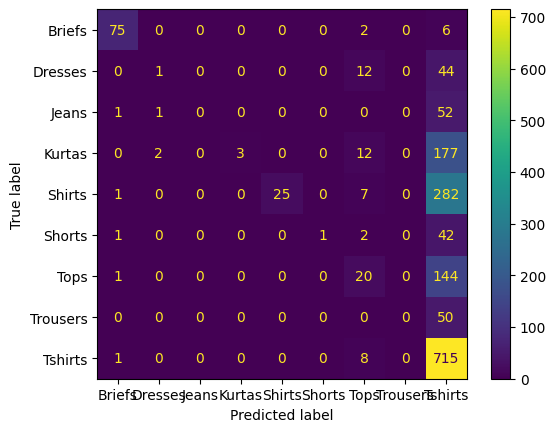

Classification Report:
              precision    recall  f1-score   support

      Briefs       0.94      0.90      0.92        83
     Dresses       0.25      0.02      0.03        57
       Jeans       0.00      0.00      0.00        54
      Kurtas       1.00      0.02      0.03       194
      Shirts       1.00      0.08      0.15       315
      Shorts       1.00      0.02      0.04        46
        Tops       0.32      0.12      0.18       165
    Trousers       0.00      0.00      0.00        50
     Tshirts       0.47      0.99      0.64       724

    accuracy                           0.50      1688
   macro avg       0.55      0.24      0.22      1688
weighted avg       0.62      0.50      0.37      1688



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:


# Assuming that testY is one-hot encoded, convert it to class indices
testY_classes = np.argmax(testY, axis=1)

# Predict the probabilities
y_pred = model.predict(testX)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(testY_classes, y_pred_classes)

# Set the figure size
plt.figure(figsize=(15, 40))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis')
plt.show()

# Generate the classification report
report = classification_report(testY_classes, y_pred_classes, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)


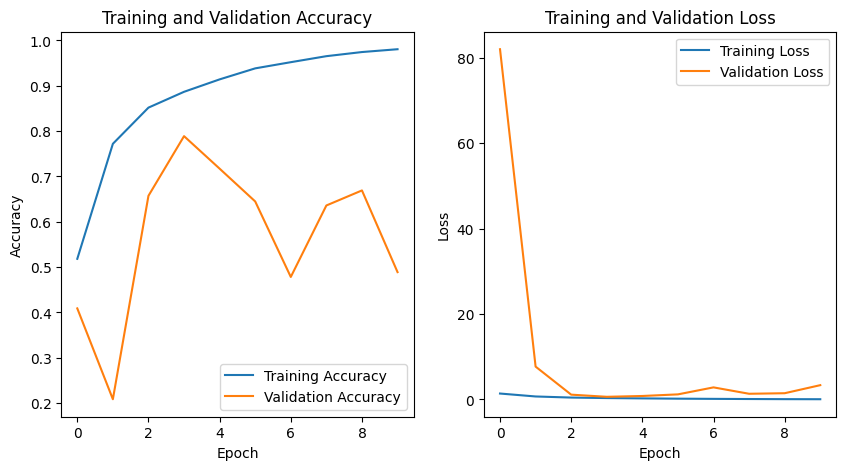

In [ ]:
# Assuming your model is trained as follows:
# history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=num_epochs, ...)

# Extracting accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting the accuracy curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting the loss curves
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Show the plot
plt.show()


### 2.2.14 sample_weights

In [ ]:
# When fitting the model, add class weights

start_time = time.time()
# L2 regularization
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)


# Define the early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Calculate class weights
sample_weights = compute_sample_weight(class_weight='balanced', y=np.argmax(trainY, axis=1))

# Add class weights to the model fitting
history = model.fit(
    trainX, trainY,
    epochs=50,
    validation_data=(valX, valY),
    callbacks=[early_stopping],
    sample_weight=sample_weights
)

Epoch 1/50
422/422 [==============================] - 30s 59ms/step - loss: 0.0852 - accuracy: 0.9787 - val_loss: 1.0134 - val_accuracy: 0.7629
Epoch 2/50
422/422 [==============================] - 25s 58ms/step - loss: 0.0631 - accuracy: 0.9812 - val_loss: 1.2577 - val_accuracy: 0.7659
Epoch 3/50
422/422 [==============================] - 25s 59ms/step - loss: 0.0554 - accuracy: 0.9853 - val_loss: 4.4211 - val_accuracy: 0.4724
Epoch 4/50
422/422 [==============================] - 25s 60ms/step - loss: 0.0489 - accuracy: 0.9858 - val_loss: 0.5887 - val_accuracy: 0.8494
Epoch 5/50
422/422 [==============================] - 27s 64ms/step - loss: 0.0357 - accuracy: 0.9890 - val_loss: 1.5546 - val_accuracy: 0.6165
Epoch 6/50
422/422 [==============================] - 25s 59ms/step - loss: 0.0404 - accuracy: 0.9871 - val_loss: 1.3818 - val_accuracy: 0.7113
Epoch 7/50
422/422 [==============================] - 25s 58ms/step - loss: 0.0313 - accuracy: 0.9894 - val_loss: 0.9355 - val_accuracy:

In [ ]:
score = model.evaluate(testX, testY)

# Evaluate the model
loss, accuracy = model.evaluate(valX, valY)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test data
predictions = model.predict(testX)

# Convert predictions from probabilities to binary values
binary_predictions = np.round(predictions)

# Generate the classification report
report = classification_report(testY, binary_predictions, target_names=class_names)

# Print the classification report
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 17ms/step - loss: 0.5887 - accuracy: 0.8494
Validation Loss: 0.588712751865387
Validation Accuracy: 0.84943687915802
Test loss: 0.5809798240661621
Test accuracy: 0.8542653918266296
53/53 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

      Briefs       0.98      0.98      0.98        83
     Dresses       0.87      0.47      0.61        57
       Jeans       0.96      0.80      0.87        54
      Kurtas       0.87      0.89      0.88       194
      Shirts       0.89      0.87      0.88       315
      Shorts       0.98      0.89      0.93        46
        Tops       0.57      0.62      0.60       165
    Trousers       0.77      0.96      0.86        50
     Tshirts       0.92      0.88      0.90       724

   micro avg       0.87      0.85      0.86      1688
   macro avg       0.87      0.82      0.83      1688
weighted avg       0.87      0.85      0.86      1688
 samples avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


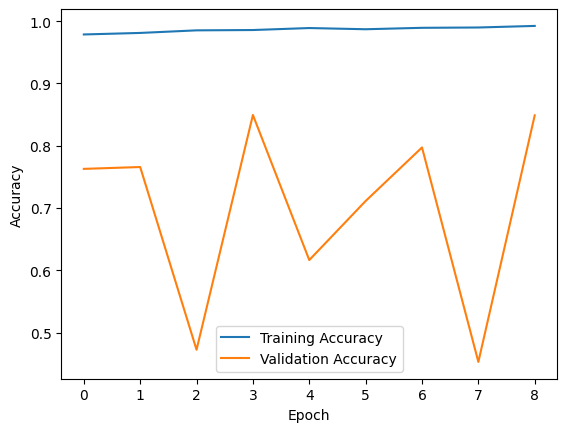

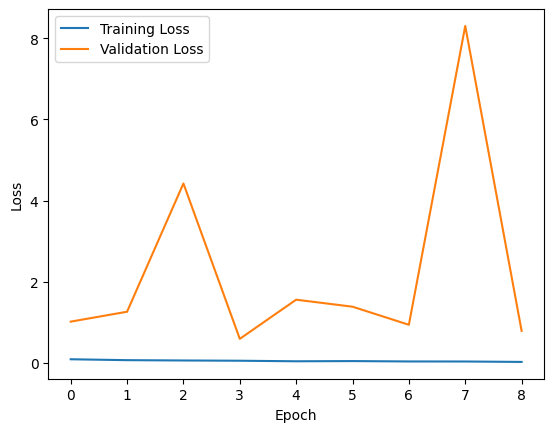

In [ ]:
# Get the accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.3 SVM

In [ ]:
# name a train_images t store images for training the model
train_images = np.stack(data_svm.image.values,axis=0)
print(train_images.shape)


(16884,)


### 2.3.1 baseline model

In [ ]:
print("Shape of data_flattened:", data_flattened.shape)
print("Shape of labels:", labels.shape)


Shape of data_flattened: (16873, 14400)
Shape of labels: (44441, 3)


In [ ]:
start_time = time.time()

# Flatten the image data
data_flattened = data.reshape((data.shape[0], -1))

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data_flattened, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [ ]:
# Train an SVM model on the training data
print("Training SVM...")
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train.argmax(axis=1))



Training SVM...


SVC(kernel='linear', probability=True)

In [ ]:
# Evaluate the model on the validation set
print("Evaluating on validation set...")
y_val_pred = svm.predict(X_val)
print(classification_report(y_val.argmax(axis=1), y_val_pred))

# Test the model on the test set
print("Testing on test set...")
y_test_pred = svm.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_test_pred))

# Calculate the time elapsed and RAM usage
end_time = time.time()


Evaluating on validation set...
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       124
           1       0.55      0.63      0.59        81
           2       0.86      0.82      0.84        94
           3       0.87      0.83      0.85       277
           4       0.73      0.78      0.76       467
           5       0.87      0.86      0.86        78
           6       0.57      0.60      0.58       265
           7       0.79      0.85      0.82        79
           8       0.85      0.82      0.83      1066

    accuracy                           0.79      2531
   macro avg       0.78      0.80      0.79      2531
weighted avg       0.80      0.79      0.79      2531

Testing on test set...
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       122
           1       0.59      0.62      0.60        76
           2       0.87      0.87      0.87        99
           3       0.86

In [ ]:
# Convert one-hot encoded labels back to class labels
y_train_labels = np.argmax(y_train, axis=1)

# Get training predictions
train_predictions = svm.predict(X_train)

# Get training accuracy
train_accuracy = accuracy_score(y_train_labels, train_predictions)

# Output the training accuracy
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.9999153331639996


In [ ]:
# Assuming y_test is also one-hot encoded, convert it back to class labels
y_test_labels = np.argmax(y_test, axis=1)


In [ ]:
# Get test predictions
test_predictions = svm.predict(X_test)

# Get test accuracy
test_accuracy = accuracy_score(y_test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7921770051363097


In [ ]:
# Check for overfitting
if train_accuracy > test_accuracy + 0.05:
    print("The model may be overfitting")
else:
    print("The model is not overfitting")

The model may be overfitting


In [ ]:
memory_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
# Output the time and memory
print("Time taken: {:.2f} seconds".format(end_time - start_time))
print("Memory used: {:.2f} MB".format(memory_usage))

Time taken: 2161.01 seconds
Memory used: 10147.70 MB


### 2.3.2 Feature Extraction

In [ ]:
# Assuming 'data' contains the 'image' attribute
train_images = np.stack(data, axis=0)
print(train_images.shape)





(16873, 60, 80, 3)


### 2.3.3 Model build using HOG

In [ ]:
hog_images = []
hog_features = []
for i in train_images:
    fd, hog_image = hog(i, orientations=9,
                        pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                        block_norm='L2', visualize=True, channel_axis=-1)

    hog_images.append(hog_image)
    hog_features.append(fd)

hog_features = np.array(hog_features)
hog_features.shape

(16873, 1944)

In [ ]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(hog_features, labels, stratify=labels,
                                                    test_size=.2, shuffle=True)

print(x_train.shape)
print(x_test.shape)

# Convert multilabel-indicator targets to multiclass targets
y_train_multiclass = np.argmax(y_train, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)


(13498, 1944)
(3375, 1944)


In [ ]:

# SVM
start = time.perf_counter()
# Validation
svm = SVC()
cv = StratifiedKFold(n_splits=10)
validation = cross_val_score(svm, x_train, y_train_multiclass, cv=cv, scoring='accuracy', n_jobs=-1)

# Training
svm = SVC(probability=True)
svm.fit(x_train, y_train_multiclass)
y_pred_train = svm.predict(x_train)
y_pred_test = svm.predict(x_test)    # Testing

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 980.328 seconds.


In [ ]:
print('Accuracy_Val : {:.4f}\n'.format(validation.mean()))

# Convert multilabel-indicator targets to multiclass targets
y_test_multiclass = np.argmax(y_test, axis=1)

print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test_multiclass, y_pred_test)),
      'Precision_test : {:.4f}'.format(precision_score(y_test_multiclass, y_pred_test, average='macro')),
      'Recall_test : {:.4f}'.format(recall_score(y_test_multiclass, y_pred_test, average='macro')),
      'F1-Score : {:.4f}'.format(f1_score(y_test_multiclass, y_pred_test, average='macro')))

# Classification report
from sklearn.metrics import classification_report

print('\nclassification report testing : \n', classification_report(y_test_multiclass, y_pred_test, target_names=category_names))

print('Elapsed %.3f seconds.' % elapsed)

Accuracy_Val : 0.8929

Accuracy_test : 0.8892 Precision_test : 0.8575 Recall_test : 0.8295 F1-Score : 0.8374

classification report testing : 
               precision    recall  f1-score   support

      Briefs       0.99      0.99      0.99       169
     Dresses       0.71      0.42      0.53        93
       Jeans       0.76      0.92      0.83       120
      Kurtas       0.87      0.93      0.90       369
      Shirts       0.94      0.91      0.92       643
      Shorts       0.96      0.86      0.91       109
        Tops       0.68      0.74      0.71       353
    Trousers       0.88      0.75      0.81       106
     Tshirts       0.93      0.93      0.93      1413

    accuracy                           0.89      3375
   macro avg       0.86      0.83      0.84      3375
weighted avg       0.89      0.89      0.89      3375

Elapsed 980.328 seconds.


In [ ]:
# Predict probabilities
y_pred_train_proba = svm.predict_proba(x_train)
y_pred_test_proba = svm.predict_proba(x_test)

# Calculate the validation loss
val_loss = log_loss(y_train_multiclass, y_pred_train_proba)

# Calculate the test loss
test_loss = log_loss(y_test_multiclass, y_pred_test_proba)

# Print the validation loss and test loss
print("Validation Loss:", val_loss)
print("Test Loss:", test_loss)

Validation Loss: 0.13591123089472743
Test Loss: 0.29520428719831127


### 2.3.4 Model oversampling

In [ ]:

# Assuming your one-hot encoded target variable is `y_train_multiclass`
class_labels = np.argmax(y_train, axis=1)
unique_labels = np.unique(class_labels)
print(unique_labels)

[0 1 2 3 4 5 6 7 8]


In [ ]:
# Oversampling using RandomOverSampler

# Define the desired oversampling factor for each class
desired_oversampling_factor = {
    unique_labels[1]: 464,   # Dresses
    unique_labels[6]: 1762   # Tops
}

# Create a dictionary to map class names to their corresponding indices
class_indices = {
    "Dresses": unique_labels[1],
    "Tops": unique_labels[6]
}

# Initialize the oversampler with the desired oversampling factors
oversampler = RandomOverSampler(sampling_strategy=desired_oversampling_factor)

# Reshape the input data
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)

# Perform oversampling on the specified classes
x_train_oversampled, y_train_oversampled = oversampler.fit_resample(x_train_reshaped, y_train_multiclass)

# Convert the oversampled target variable back to one-hot encoded format
y_train_oversampled = np.eye(len(unique_labels))[y_train_oversampled]

# Print the shape of the oversampled data
print("Oversampled Data Shape:", x_train_oversampled.shape)
print("Oversampled Target Shape:", y_train_oversampled.shape)


Oversampled Data Shape: (13944, 1944)
Oversampled Target Shape: (13944, 9)


spent 7minutes

In [ ]:
# Convert the one-hot encoded target variable to class labels
y_train_oversampled_labels = np.argmax(y_train_oversampled, axis=1)

# Training
svm = SVC(probability=True)
svm.fit(x_train_oversampled, y_train_oversampled_labels)

# Testing
y_pred_test = svm.predict(x_test)
y_test_multiclass = np.argmax(y_test, axis=1)


In [ ]:
# Performance metrics
accuracy = accuracy_score(y_test_multiclass, y_pred_test)
precision = precision_score(y_test_multiclass, y_pred_test, average='macro')
recall = recall_score(y_test_multiclass, y_pred_test, average='macro')
f1 = f1_score(y_test_multiclass, y_pred_test, average='macro')
classification_report = classification_report(y_test_multiclass, y_pred_test, target_names=class_names)

print('Oversampling - SVM Model Performance:')
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-Score: {:.4f}'.format(f1))
print('\nClassification Report:')
print(classification_report)

Oversampling - SVM Model Performance:
Accuracy: 0.8933
Precision: 0.8595
Recall: 0.8374
F1-Score: 0.8440

Classification Report:
              precision    recall  f1-score   support

      Briefs       0.99      0.99      0.99       169
     Dresses       0.67      0.43      0.52        93
       Jeans       0.79      0.92      0.85       120
      Kurtas       0.86      0.92      0.89       369
      Shirts       0.95      0.92      0.93       643
      Shorts       0.94      0.93      0.94       109
        Tops       0.68      0.75      0.71       353
    Trousers       0.91      0.75      0.82       106
     Tshirts       0.94      0.94      0.94      1413

    accuracy                           0.89      3375
   macro avg       0.86      0.84      0.84      3375
weighted avg       0.89      0.89      0.89      3375



### 2.4.5 using class weights

In [ ]:
# Convert multilabel-indicator targets to multiclass targets
y_train_multiclass = np.argmax(y_train, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

In [ ]:

# Reshape the y_train array to have two dimensions
y_train_reshaped = y_train.reshape(-1, 1)

# Split the data into training and validation sets
x_train, x_val, y_train_reshaped, y_val = train_test_split(x_train, y_train_reshaped, test_size=0.2, random_state=42)

# Calculate class frequencies
class_counts = np.bincount(y_train_reshaped.flatten())
total_samples = np.sum(class_counts)

# Calculate class weights based on class frequencies
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights_dict = dict(enumerate(class_weights))

# Training with class weights
svm = SVC(probability=True, class_weight=class_weights_dict)
svm.fit(x_train, y_train_reshaped)

# Testing
y_pred_test = svm.predict(x_test)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.metrics import classification_report

# Calculate accuracy and loss on the validation set
val_loss = svm.score(x_val, y_val)
val_accuracy = svm.score(x_val, y_val)

# Calculate accuracy and loss on the test set
test_loss = svm.score(x_test, y_test_multiclass)
test_accuracy = svm.score(x_test, y_test_multiclass)

# Calculate accuracy and loss on the training set
train_loss = svm.score(x_train, y_train_reshaped)
train_accuracy = svm.score(x_train, y_train_reshaped)

# Print the loss and accuracy for each set
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generate the classification report on the test set
report = classification_report(y_test_multiclass, y_pred_test)
print("Classification Report:\n", report)


Training Loss: 0.9205834683954619
Training Accuracy: 0.9205834683954619
Validation Loss: 0.8606481481481482
Validation Accuracy: 0.8606481481481482
Test Loss: 0.8642962962962963
Test Accuracy: 0.8642962962962963
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       169
           1       0.58      0.57      0.57        93
           2       0.81      0.87      0.84       120
           3       0.89      0.90      0.89       369
           4       0.92      0.89      0.91       643
           5       0.92      0.93      0.92       109
           6       0.56      0.88      0.69       353
           7       0.84      0.80      0.82       106
           8       0.97      0.84      0.90      1413

    accuracy                           0.86      3375
   macro avg       0.83      0.85      0.84      3375
weighted avg       0.89      0.86      0.87      3375



### 2.3.6 Using class weight 2.0

In [ ]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(hog_features, labels, stratify=labels,
                                                    test_size=.2, shuffle=True)

print(x_train.shape)
print(x_test.shape)

# Convert multilabel-indicator targets to multiclass targets
y_train_multiclass = np.argmax(y_train, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)


(13498, 1944)
(3375, 1944)


In [ ]:


# SVM
start = time.perf_counter()

# Define the class weights
class_weights = {0: 1.0, 1: 5.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 5.0, 7: 1.0, 8: 1.0}

# Training with class weights
svm = SVC(probability=True, class_weight=class_weights)
svm.fit(x_train, y_train_multiclass)


elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 414.945 seconds.


In [ ]:
# Validation
y_pred_val = svm.predict(x_val)

# Evaluate validation accuracy
val_accuracy = (y_pred_val == y_val).mean()

# Testing
y_pred_test = svm.predict(x_test)

# Evaluate test accuracy
test_accuracy = (y_pred_test == y_test_multiclass).mean()

# Generate classification report for validation set
classification_report_val = classification_report(y_val, y_pred_val,target_names=class_names)

# Generate classification report for test set
classification_report_test = classification_report(y_test_multiclass, y_pred_test,target_names=class_names)

# Print the validation accuracy and classification report
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("Classification Report (Validation Set):")
print(classification_report_val)
print("Classification Report (Test Set):")
print(classification_report_test)


Validation Accuracy: 0.23942558299039782
Test Accuracy: 0.8942222222222223
Classification Report (Validation Set):
              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00       102
     Dresses       0.92      0.95      0.94        61
       Jeans       0.89      0.96      0.92        76
      Kurtas       0.99      0.94      0.96       214
      Shirts       0.99      0.92      0.96       452
      Shorts       0.97      0.98      0.98        61
        Tops       0.75      0.97      0.85       230
    Trousers       0.95      0.84      0.89        63
     Tshirts       0.98      0.95      0.97       901

    accuracy                           0.95      2160
   macro avg       0.94      0.95      0.94      2160
weighted avg       0.95      0.95      0.95      2160

Classification Report (Test Set):
              precision    recall  f1-score   support

      Briefs       1.00      0.99      1.00       169
     Dresses       0.64      0.68    

## 2.4 Random Forest

### 2.4.1 Baseline Model

In [ ]:

def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert image to grayscale if it's a color image
        if len(image.shape) == 3:
            image = color.rgb2gray(image)

        # The HOG parameters can be tweaked for different results
        features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

hog_features = extract_hog_features(data) # data is your list of images


In [ ]:
# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# Step 3: Train a Random Forest Classifier on the training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 4: Evaluate the model using the test data
y_pred = rf.predict(X_test)

# Step 5: Generate a classification report
category_names = mlb.classes_  # mlb is your MultiLabelBinarizer
print(classification_report(y_test, y_pred, target_names=category_names))

              precision    recall  f1-score   support

      Briefs       1.00      0.95      0.97       177
     Dresses       1.00      0.05      0.10       112
       Jeans       0.92      0.61      0.74       127
      Kurtas       0.92      0.63      0.75       357
      Shirts       0.97      0.74      0.84       644
      Shorts       0.98      0.57      0.72       100
        Tops       0.86      0.18      0.29       334
    Trousers       0.90      0.63      0.74       110
     Tshirts       0.94      0.89      0.91      1414

   micro avg       0.94      0.71      0.81      3375
   macro avg       0.94      0.58      0.67      3375
weighted avg       0.94      0.71      0.78      3375
 samples avg       0.71      0.71      0.71      3375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.2 Combine HOG feature with color feature

In [ ]:


def extract_hog_features(images):
    hog_features = []
    color_histograms = []

    for image in images:
        # Convert image to grayscale for HOG
        if len(image.shape) == 3:
            gray_image = sk_color.rgb2gray(image)
        else:
            gray_image = image

        # Extract HOG features
        features = feature.hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)

        # Extract color histogram
        # Note that we multiply the channels by 255 to get the original range
        chans = cv2.split(np.uint8(image * 255)) # split the channels (R, G, B)
        colors = ("r", "g", "b")
        hist_features = []
        for (chan, color) in zip(chans, colors):
            hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
            hist_features.extend(hist.flatten())
        color_histograms.append(hist_features)

    hog_features = np.array(hog_features)
    color_histograms = np.array(color_histograms)

    # Concatenate HOG features and color histogram features
    combined_features = np.hstack((hog_features, color_histograms))

    return combined_features

# Example usage:
combined_features = extract_hog_features(data) # data is your list of images


In [ ]:
# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# Step 3: Train a Random Forest Classifier on the training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 4: Evaluate the model using the test data
y_pred = rf.predict(X_test)

# Step 5: Generate a classification report
category_names = mlb.classes_  # mlb is your MultiLabelBinarizer
print(classification_report(y_test, y_pred, target_names=category_names))

              precision    recall  f1-score   support

      Briefs       1.00      0.97      0.98       177
     Dresses       1.00      0.05      0.10       112
       Jeans       0.96      0.61      0.74       127
      Kurtas       0.91      0.66      0.76       357
      Shirts       0.97      0.73      0.84       644
      Shorts       1.00      0.53      0.69       100
        Tops       0.91      0.19      0.31       334
    Trousers       0.95      0.64      0.76       110
     Tshirts       0.93      0.88      0.91      1414

   micro avg       0.94      0.71      0.81      3375
   macro avg       0.96      0.58      0.68      3375
weighted avg       0.94      0.71      0.78      3375
 samples avg       0.71      0.71      0.71      3375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4.2.3 Feature Scaling and Data augmentation

In [ ]:

# Assuming `data` is your original images in the form of a numpy array
# with shape (number of samples, image width, image height, number of channels)
# and `labels` are the corresponding labels



# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

augmented_images = []
augmented_labels = []

# Using just one round of augmentation for illustration.
# In practice, you might want to generate more augmented data.
for X_batch, y_batch in datagen.flow(trainX, trainY, batch_size=len(trainX)):
    augmented_images.extend(X_batch)
    augmented_labels.extend(y_batch)
    break

# Extract features from the augmented images
train_features = extract_hog_features(augmented_images)  # extract_hog_features from your previous code
val_features = extract_hog_features(valX)
test_features = extract_hog_features(testX)

# Feature scaling
scaler = StandardScaler().fit(train_features)
train_scaled = scaler.transform(train_features)
val_scaled = scaler.transform(val_features)
test_scaled = scaler.transform(test_features)

# Training a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_scaled, augmented_labels)

# Predicting on the validation set
val_pred = model.predict(val_scaled)

# Generating the classification report for the validation set
print("Validation Set:")
print(classification_report(valY, val_pred))

# Predicting on the test set
test_pred = model.predict(test_scaled)

# Generating the classification report for the test set
print("Test Set:")
print(classification_report(testY, test_pred))


Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        94
           1       0.00      0.00      0.00        55
           2       1.00      0.18      0.30        73
           3       0.88      0.09      0.16       163
           4       0.96      0.33      0.49       329
           5       0.00      0.00      0.00        54
           6       0.00      0.00      0.00       169
           7       0.73      0.13      0.23        60
           8       0.79      0.87      0.83       690

   micro avg       0.83      0.48      0.61      1687
   macro avg       0.60      0.26      0.32      1687
weighted avg       0.72      0.48      0.52      1687
 samples avg       0.48      0.48      0.48      1687

Test Set:
              precision    recall  f1-score   support

           0       1.00      0.69      0.81        83
           1       0.00      0.00      0.00        57
           2       1.00      0.09      0.17        5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### 2.4.4 adding hyparameters on the model using the HOG feature(the same as baseline model)

In [ ]:


# Assuming `data` is your original images in the form of a numpy array
# with shape (number of samples, image width, image height, number of channels)
# and `labels` are the corresponding labels

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data, labels, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

# Extract HOG features from the images
train_features = extract_hog_features(trainX)  # Assuming you have your original extract_hog_features function
val_features = extract_hog_features(valX)
test_features = extract_hog_features(testX)

# Feature scaling
scaler = StandardScaler().fit(train_features)
train_scaled = scaler.transform(train_features)
val_scaled = scaler.transform(val_features)
test_scaled = scaler.transform(test_features)

# Define parameter grid for Random Forest
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
 'max_features': ['auto', 'sqrt', 'log2']
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# n_iter controls the number of different combinations to try, and cv is the number of folds to use for cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=10, cv=3, n_jobs=-1)
random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

# Print the best parameters
print("Best Parameters: ", random_search.best_params_)

# Predicting on the validation set
val_pred = random_search.predict(val_scaled)

# Generating the classification report for the validation set
print("Validation Set:")
print(classification_report(valY, val_pred))

# Predicting on the test set
test_pred = random_search.predict(test_scaled)

# Generating the classification report for the test set
print("Test Set:")
print(classification_report(testY, test_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters:  {'n_estimators': 200, 'max_features': 'auto', 'max_depth': 20}
Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        94
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       163
           4       0.00      0.00      0.00       329
           5       1.00      0.04      0.07        54
           6       0.00      0.00      0.00       169
           7       0.00      0.00      0.00        60
           8       1.00      0.01      0.01       690

   micro avg       1.00      0.02      0.05      1687
   macro avg       0.33      0.04      0.07      1687
weighted avg       0.50      0.02      0.04      1687
 samples avg       0.02      0.02      0.02      1687



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set:
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        83
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00       194
           4       0.00      0.00      0.00       315
           5       1.00      0.07      0.12        46
           6       0.00      0.00      0.00       165
           7       0.00      0.00      0.00        50
           8       1.00      0.00      0.01       724

   micro avg       1.00      0.03      0.05      1688
   macro avg       0.33      0.06      0.08      1688
weighted avg       0.51      0.03      0.04      1688
 samples avg       0.03      0.03      0.03      1688



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.5 slight change on baseline model

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier with modified parameters
rf = RandomForestClassifier(n_estimators=150, max_depth=30, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model using the test data
y_pred = rf.predict(X_test)

# Generate a classification report
category_names = mlb.classes_  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(y_test, y_pred, target_names=category_names))

              precision    recall  f1-score   support

      Briefs       1.00      0.96      0.98       177
     Dresses       1.00      0.05      0.10       112
       Jeans       0.94      0.61      0.74       127
      Kurtas       0.92      0.64      0.75       357
      Shirts       0.97      0.75      0.85       644
      Shorts       0.98      0.54      0.70       100
        Tops       0.85      0.19      0.31       334
    Trousers       0.91      0.63      0.74       110
     Tshirts       0.93      0.89      0.91      1414

   micro avg       0.94      0.71      0.81      3375
   macro avg       0.95      0.58      0.68      3375
weighted avg       0.94      0.71      0.78      3375
 samples avg       0.71      0.71      0.71      3375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.6 class weights

In [ ]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# Define class weights
class_weights = [
    {0: 1, 1: 5, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1},
    {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
]

# Train a Random Forest Classifier with modified parameters
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=10,
    class_weight=class_weights,
    bootstrap=False,
    random_state=42
)
rf.fit(X_train, y_train)

# Evaluate the model using the test data
y_pred = rf.predict(X_test)

# Generate a classification report
category_names = mlb.classes_  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(y_test, y_pred, target_names=category_names))


              precision    recall  f1-score   support

      Briefs       1.00      0.98      0.99       177
     Dresses       1.00      0.06      0.12       112
       Jeans       0.95      0.62      0.75       127
      Kurtas       0.91      0.65      0.76       357
      Shirts       0.97      0.76      0.85       644
      Shorts       0.98      0.60      0.75       100
        Tops       0.87      0.23      0.36       334
    Trousers       0.91      0.64      0.75       110
     Tshirts       0.93      0.89      0.91      1414

   micro avg       0.94      0.73      0.82      3375
   macro avg       0.95      0.60      0.69      3375
weighted avg       0.94      0.73      0.79      3375
 samples avg       0.73      0.73      0.73      3375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.7 Random Forest Classifier with modified parameters

In [ ]:


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier with modified parameters
rf = OneVsRestClassifier(
    RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=42)
)
rf.fit(X_train, y_train)

# Evaluate the model using the test data
y_pred = rf.predict(X_test)

# Generate a classification report
category_names = mlb.classes_  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(y_test, y_pred, target_names=category_names))


              precision    recall  f1-score   support

      Briefs       0.99      0.97      0.98       177
     Dresses       1.00      0.05      0.10       112
       Jeans       0.94      0.64      0.76       127
      Kurtas       0.90      0.66      0.76       357
      Shirts       0.97      0.74      0.84       644
      Shorts       0.98      0.59      0.74       100
        Tops       0.82      0.24      0.37       334
    Trousers       0.94      0.60      0.73       110
     Tshirts       0.93      0.90      0.91      1414

   micro avg       0.94      0.73      0.82      3375
   macro avg       0.94      0.60      0.69      3375
weighted avg       0.93      0.73      0.79      3375
 samples avg       0.72      0.73      0.72      3375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.8 hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV

# Instantiate the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Reshape the data
n_samples, x, y, z = data.shape
data_2d = data.reshape((n_samples, x * y * z))

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data_2d, labels, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt'] # 'auto' is deprecated in the version of the used scikit-learn, so here I drop this out
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=36, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(trainX, trainY)

# Use the best parameters from the random search
rf_best = rf_random.best_estimator_
y_pred = rf_best.predict(testX)




Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


NameError: ignored

In [ ]:
# Generate a classification report
category_names = mlb.classes_  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(testY, y_pred, target_names=category_names))


              precision    recall  f1-score   support

      Briefs       1.00      0.95      0.98        83
     Dresses       0.91      0.18      0.29        57
       Jeans       0.98      0.80      0.88        54
      Kurtas       0.95      0.76      0.84       194
      Shirts       0.95      0.66      0.78       315
      Shorts       1.00      0.76      0.86        46
        Tops       0.82      0.22      0.35       165
    Trousers       0.93      0.74      0.82        50
     Tshirts       0.91      0.82      0.86       724

   micro avg       0.93      0.71      0.80      1688
   macro avg       0.94      0.65      0.74      1688
weighted avg       0.92      0.71      0.78      1688
 samples avg       0.71      0.71      0.71      1688



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.9 RandomizedSearchCV

In [ ]:


# Instantiate the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Reshape the data
n_samples, x, y, z = data.shape
data_2d = data.reshape((n_samples, x * y * z))

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data_2d, labels, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

# Define the parameters to search
param_dist = {
    'n_estimators': [100, 200],         # Reduced number of trees
    'max_depth': [10, None],            # Reduced max depth
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}




In [ ]:
# Instantiate RandomizedSearchCV with a smaller number of iterations
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=8, cv=3, verbose=2, random_state=42, n_jobs=1)
rf_random.fit(trainX, trainY)

# Use the best parameters from the random search
rf_best = rf_random.best_estimator_

# Predict on the test set
y_pred = rf_best.predict(testX)

# Print the classification report
print(classification_report(testY, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  51.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  43.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  42.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  41.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  41.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  41.8s
[CV] END max_depth=10, max_features=sqrt

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.10 PCA

In [ ]:


# Instantiate the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Reshape the data
n_samples, x, y, z = data.shape
data_2d = data.reshape((n_samples, x * y * z))

# Use PCA to reduce dimensionality
pca = PCA(n_components=100) # Using 100 components as an example
data_pca = pca.fit_transform(data_2d)

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data_pca, labels, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}


In [ ]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=18, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(trainX, trainY)

# Use the best parameters from the random search
rf_best = rf_random.best_estimator_
y_pred = rf_best.predict(testX)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
# Generate a classification report
category_names = mlb.classes_  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(testY, y_pred, target_names=category_names))

              precision    recall  f1-score   support

      Briefs       1.00      0.87      0.93        83
     Dresses       0.83      0.09      0.16        57
       Jeans       0.97      0.57      0.72        54
      Kurtas       0.93      0.60      0.73       194
      Shirts       0.98      0.55      0.71       315
      Shorts       1.00      0.39      0.56        46
        Tops       0.95      0.12      0.22       165
    Trousers       0.97      0.60      0.74        50
     Tshirts       0.88      0.80      0.84       724

   micro avg       0.92      0.62      0.74      1688
   macro avg       0.95      0.51      0.62      1688
weighted avg       0.92      0.62      0.71      1688
 samples avg       0.62      0.62      0.62      1688



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4.11 OverSampling + PCA

In [ ]:


# Before PCA, Oversampling the minority class
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data_2d, labels)

# Use PCA on resampled data
data_pca = pca.fit_transform(data_resampled)

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data_pca, labels_resampled, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}


In [ ]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=18, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(trainX, trainY)

# Use the best parameters from the random search
rf_best = rf_random.best_estimator_
y_pred = rf_best.predict(testX)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Generate a classification report
category_names = mlb.classes_  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(testY, y_pred, target_names=category_names))

              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00       703
     Dresses       1.00      1.00      1.00       732
       Jeans       1.00      1.00      1.00       678
      Kurtas       1.00      0.98      0.99       747
      Shirts       0.97      0.93      0.95       695
      Shorts       1.00      1.00      1.00       708
        Tops       0.99      0.98      0.99       697
    Trousers       1.00      1.00      1.00       692
     Tshirts       0.96      0.70      0.81       707

   micro avg       0.99      0.95      0.97      6359
   macro avg       0.99      0.95      0.97      6359
weighted avg       0.99      0.95      0.97      6359
 samples avg       0.95      0.95      0.95      6359



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The lower performance on the "Tshirts" class, despite having more data, may be due to several reasons:

More variance within the class: The "Tshirts" class might have more variations within the class compared to other classes. For example, the Tshirts might come in different styles, colors, patterns, etc., making it more challenging for the model to generalize.

Confusion with other classes: The model might be confusing "Tshirts" with other similar classes like "Shirts" or "Tops".

Impact of oversampling: While oversampling helps to balance the classes, it might introduce some noise if not done correctly. For instance, if the oversampling method creates very similar or near-duplicate samples, it could lead the model to overfit.

Feature extraction method: PCA is a linear dimensionality reduction method, which might not capture the complex patterns in the image data well.

In [ ]:
# Predict on the training set
y_train_pred = rf_best.predict(trainX)

# Generate a classification report for the training set
print("Classification Report for Training Set:")
print(classification_report(trainY, y_train_pred, target_names=category_names))

# Predict on the test set
y_test_pred = rf_best.predict(testX)

# Generate a classification report for the test set
print("Classification Report for Test Set:")
print(classification_report(testY, y_test_pred, target_names=category_names))


NameError: ignored

### if the model 2.4.11 is overfitting

The min_samples_split and min_samples_leaf parameters control the size of the trees in the Random Forest. Larger values for these parameters will create smaller trees which can help in regularizing the model and reducing overfitting.

In [ ]:
# Start timer
start_time = time.time()

# Reshape the data
n_samples, x, y, z = data.shape
data_2d = data.reshape((n_samples, x * y * z))

# Before PCA, Oversampling the minority class
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data_2d, labels)

# Use PCA to reduce dimensionality
pca = PCA(n_components=100) # Using 100 components as an example
data_pca = pca.fit_transform(data_2d)


# Use PCA on resampled data
data_pca = pca.fit_transform(data_resampled)

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data_pca, labels_resampled, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

# Parameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 10],
    'bootstrap': [True],
    'max_features': ['sqrt']
}


In [ ]:
# Perform RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=81, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(trainX, trainY)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=81, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 30, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [ ]:
# Use the best parameters from the random search
rf_best = rf_random.best_estimator_
y_pred = rf_best.predict(testX)

# End timer and print time taken
end_time = time.time()

# Calculate validation accuracy and loss
val_pred = rf_best.predict(valX)
val_accuracy = accuracy_score(valY, val_pred)
val_loss = log_loss(valY, val_pred)

# Calculate test accuracy and loss
test_pred = rf_best.predict(testX)
test_accuracy = accuracy_score(testY, test_pred)
test_loss = log_loss(testY, test_pred)

# Generate a classification report
category_names = mlb.classes_  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(testY, y_pred, target_names=category_names))

# Print validation and test accuracy and loss
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("Validation Loss:", val_loss)
print("Test Loss:", test_loss)


print(f"Time taken: {end_time - start_time} seconds")

              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00       703
     Dresses       1.00      1.00      1.00       732
       Jeans       1.00      1.00      1.00       678
      Kurtas       1.00      0.98      0.99       747
      Shirts       0.96      0.91      0.94       695
      Shorts       1.00      1.00      1.00       708
        Tops       0.99      0.97      0.98       697
    Trousers       1.00      1.00      1.00       692
     Tshirts       0.97      0.66      0.79       707

   micro avg       0.99      0.95      0.97      6359
   macro avg       0.99      0.95      0.97      6359
weighted avg       0.99      0.95      0.97      6359
 samples avg       0.95      0.95      0.95      6359

Time taken: 6185.522314310074 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Start timer
start_time = time.time()

# Reshape the data
n_samples, x, y, z = data.shape
data_2d = data.reshape((n_samples, x * y * z))

# Before PCA, Oversampling the minority class
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data_2d, labels)

# Use PCA to reduce dimensionality
pca = PCA(n_components=100) # Using 100 components as an example
data_pca = pca.fit_transform(data_2d)


# Use PCA on resampled data
data_pca = pca.fit_transform(data_resampled)

# Split the data into training set and temporary set using 80-20 split
trainX, tempX, trainY, tempY = train_test_split(data_pca, labels_resampled, test_size=0.2, random_state=42)

# Split the temporary set into validation set and test set using 50-50 split
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

# Parameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 10],
    'bootstrap': [True],
    'max_features': ['sqrt']
}


In [ ]:
# Perform RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=81, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(trainX, trainY)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=81, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 30, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [ ]:
# Use the best parameters from the random search
rf_best = rf_random.best_estimator_
y_pred = rf_best.predict(testX)

# End timer and print time taken
end_time = time.time()

# Calculate validation accuracy and loss
val_pred = rf_best.predict(valX)
val_accuracy = accuracy_score(valY, val_pred)
val_loss = log_loss(valY, val_pred)

# Calculate test accuracy and loss
test_pred = rf_best.predict(testX)
test_accuracy = accuracy_score(testY, test_pred)
test_loss = log_loss(testY, test_pred)

# Generate a classification report
category_names = class_names  # Assuming mlb is your MultiLabelBinarizer
print(classification_report(testY, y_pred, target_names=category_names))

# Print validation and test accuracy and loss
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("Validation Loss:", val_loss)
print("Test Loss:", test_loss)


print(f"Time taken: {end_time - start_time} seconds")

              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00       703
     Dresses       1.00      1.00      1.00       732
       Jeans       1.00      1.00      1.00       678
      Kurtas       1.00      0.98      0.99       747
      Shirts       0.97      0.91      0.94       695
      Shorts       1.00      1.00      1.00       708
        Tops       0.99      0.97      0.98       697
    Trousers       1.00      1.00      1.00       692
     Tshirts       0.96      0.68      0.79       707

   micro avg       0.99      0.95      0.97      6359
   macro avg       0.99      0.95      0.97      6359
weighted avg       0.99      0.95      0.97      6359
 samples avg       0.95      0.95      0.95      6359

Validation Accuracy: 0.9498269896193772
Test Accuracy: 0.9482623053939299
Validation Loss: 0.3125320753409783
Test Loss: 0.35851904564955966
Time taken: 7828.052777290344 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Generate a classification report
print(classification_report(testY, y_pred, target_names=category_names))

# Predict on the training set
y_train_pred = rf_best.predict(trainX)

# Generate a classification report for the training set
print("Classification Report for Training Set:")
print(classification_report(trainY, y_train_pred, target_names=category_names))

# Predict on the test set
y_test_pred = rf_best.predict(testX)

# Generate a classification report for the test set
print("Classification Report for Test Set:")
print(classification_report(testY, y_test_pred, target_names=category_names))



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00       703
     Dresses       1.00      1.00      1.00       732
       Jeans       1.00      1.00      1.00       678
      Kurtas       1.00      0.98      0.99       747
      Shirts       0.97      0.91      0.94       695
      Shorts       1.00      1.00      1.00       708
        Tops       0.99      0.97      0.98       697
    Trousers       1.00      1.00      1.00       692
     Tshirts       0.96      0.68      0.79       707

   micro avg       0.99      0.95      0.97      6359
   macro avg       0.99      0.95      0.97      6359
weighted avg       0.99      0.95      0.97      6359
 samples avg       0.95      0.95      0.95      6359

Classification Report for Training Set:
              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00      5690
     Dresses       1.00      1.00      1.00      5630
       Jeans       1.00      1.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Test Set:
              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00       703
     Dresses       1.00      1.00      1.00       732
       Jeans       1.00      1.00      1.00       678
      Kurtas       1.00      0.98      0.99       747
      Shirts       0.97      0.91      0.94       695
      Shorts       1.00      1.00      1.00       708
        Tops       0.99      0.97      0.98       697
    Trousers       1.00      1.00      1.00       692
     Tshirts       0.96      0.68      0.79       707

   micro avg       0.99      0.95      0.97      6359
   macro avg       0.99      0.95      0.97      6359
weighted avg       0.99      0.95      0.97      6359
 samples avg       0.95      0.95      0.95      6359



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2.5 Inception-ResNest V2

### 2.5.1 baseline model

In [ ]:
import time
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import time
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from keras.applications import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import layers
from keras.optimizers import Adam
from keras.regularizers import l2
import tensorflow as tf


In [ ]:


# Resize the images
trainX_resized = []
valX_resized = []
testX_resized = []

for img in trainX:
    img_resized = tf.image.resize(img, [75, 75])
    trainX_resized.append(img_resized.numpy())

for img in valX:
    img_resized = tf.image.resize(img, [75, 75])
    valX_resized.append(img_resized.numpy())

for img in testX:
    img_resized = tf.image.resize(img, [75, 75])
    testX_resized.append(img_resized.numpy())

trainX_resized = np.array(trainX_resized)
valX_resized = np.array(valX_resized)
testX_resized = np.array(testX_resized)

In [ ]:
trainX_resized = np.array(trainX_resized)
valX_resized = np.array(valX_resized)
testX_resized = np.array(testX_resized)

# Inception-ResNet-V2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
start_time = time.time()
history = model.fit(
    trainX_resized, trainY,
    epochs=10,
    validation_data=(valX_resized, valY),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

ValueError: ignored

In [ ]:


# Inception-ResNet-V1 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
start_time = time.time()
history = model.fit(
    trainX, trainY,
    epochs=10,
    validation_data=(valX, valY),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)



ValueError: ignored

In [ ]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=0)
val_loss, val_accuracy = model.evaluate(valX, valY, verbose=0)
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=0)

# Print the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")



Training Accuracy: 0.9781448841094971
Validation Accuracy: 0.8956727981567383
Test Accuracy: 0.8969194293022156


In [ ]:
# Make predictions on the test data
y_pred = model.predict(testX)

# Generate the classification report
report = classification_report(testY, np.round(y_pred), target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 5s 28ms/step
Classification Report:
              precision    recall  f1-score   support

      Briefs       1.00      1.00      1.00        83
     Dresses       0.79      0.47      0.59        57
       Jeans       0.98      0.87      0.92        54
      Kurtas       0.92      0.90      0.91       194
      Shirts       0.89      0.93      0.91       315
      Shorts       1.00      0.91      0.95        46
        Tops       0.69      0.67      0.68       165
    Trousers       0.89      0.94      0.91        50
     Tshirts       0.93      0.95      0.94       724

   micro avg       0.90      0.89      0.90      1688
   macro avg       0.90      0.85      0.87      1688
weighted avg       0.90      0.89      0.89      1688
 samples avg       0.89      0.89      0.89      1688

Time taken: 656.3854513168335 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.5.2 data augmentation

In [ ]:
# confirm class_names contains the names of the classes in the same order as one-hot encoding

# Example class names
class_names = ["Briefs", "Dresses", "Jeans", "Kurtas", "Shirts", "Shorts", "Tops", "Trousers", "Tshirts"]

# Assume that the original labels (before one-hot encoding) are in an array called 'original_labels'
# Fit the LabelBinarizer to the original labels
label_binarizer = LabelBinarizer()
label_binarizer.fit(class_names)

# Check the order
for class_name in class_names:
    one_hot = label_binarizer.transform([class_name])
    print(f"{class_name}: {one_hot}")


Briefs: [[1 0 0 0 0 0 0 0 0]]
Dresses: [[0 1 0 0 0 0 0 0 0]]
Jeans: [[0 0 1 0 0 0 0 0 0]]
Kurtas: [[0 0 0 1 0 0 0 0 0]]
Shirts: [[0 0 0 0 1 0 0 0 0]]
Shorts: [[0 0 0 0 0 1 0 0 0]]
Tops: [[0 0 0 0 0 0 1 0 0]]
Trousers: [[0 0 0 0 0 0 0 1 0]]
Tshirts: [[0 0 0 0 0 0 0 0 1]]


In [ ]:


class_weights_list = compute_class_weight('balanced', classes=range(len(class_names)),
                                          y=np.argmax(trainY, axis=1))

class_weight_dict = {i: weight for i, weight in enumerate(class_weights_list)}

In [ ]:
# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False

# Define new model on top
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
start_time = time.time()
# Training
batch_size = 32
history = model.fit(data_augmentation.flow(trainX, trainY, batch_size=batch_size),
                    steps_per_epoch=len(trainX) / batch_size, epochs=10,
                    validation_data=(valX, valY),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                    class_weight=class_weight_dict)  # Assuming you have computed class_weight_dict

# Fine-tuning: unfreeze some top layers from the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile the model (necessary after changing layer.trainable)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
history = model.fit(data_augmentation.flow(trainX, trainY, batch_size=batch_size),
                    steps_per_epoch=len(trainX) / batch_size, epochs=10,
                    validation_data=(valX, valY),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                    class_weight=class_weight_dict)

Epoch 1/10
421/421 [==============================] - 51s 91ms/step - loss: 7.8354 - accuracy: 0.2634 - val_loss: 6.6202 - val_accuracy: 0.6076
Epoch 2/10
421/421 [==============================] - 31s 73ms/step - loss: 6.5105 - accuracy: 0.4347 - val_loss: 5.6600 - val_accuracy: 0.6675
Epoch 3/10
421/421 [==============================] - 28s 66ms/step - loss: 5.6261 - accuracy: 0.5184 - val_loss: 4.8534 - val_accuracy: 0.7149
Epoch 4/10
421/421 [==============================] - 26s 62ms/step - loss: 4.8868 - accuracy: 0.5789 - val_loss: 4.2379 - val_accuracy: 0.7178
Epoch 5/10
421/421 [==============================] - 26s 62ms/step - loss: 4.3186 - accuracy: 0.6075 - val_loss: 3.7401 - val_accuracy: 0.7380
Epoch 6/10
421/421 [==============================] - 26s 61ms/step - loss: 3.8348 - accuracy: 0.6216 - val_loss: 3.2848 - val_accuracy: 0.7439
Epoch 7/10
421/421 [==============================] - 27s 63ms/step - loss: 3.4067 - accuracy: 0.6339 - val_loss: 2.9577 - val_accuracy:

In [ ]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=0)
val_loss, val_accuracy = model.evaluate(valX, valY, verbose=0)
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=0)

# Print the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")



Training Accuracy: 0.8641279935836792
Validation Accuracy: 0.8346176743507385
Test Accuracy: 0.8329383730888367


In [ ]:
# Make predictions on the test data
y_pred = model.predict(testX)

# Generate the classification report
report = classification_report(testY, np.round(y_pred), target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 5s 30ms/step
Classification Report:
              precision    recall  f1-score   support

      Briefs       0.96      0.99      0.98        83
     Dresses       0.51      0.68      0.59        57
       Jeans       0.86      0.70      0.78        54
      Kurtas       0.92      0.66      0.77       194
      Shirts       0.95      0.81      0.88       315
      Shorts       0.75      0.91      0.82        46
        Tops       0.52      0.66      0.58       165
    Trousers       0.83      0.76      0.79        50
     Tshirts       0.95      0.86      0.90       724

   micro avg       0.86      0.80      0.83      1688
   macro avg       0.81      0.78      0.79      1688
weighted avg       0.88      0.80      0.83      1688
 samples avg       0.80      0.80      0.80      1688

Time taken: 639.6235814094543 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

53/53 [==============================] - 2s 33ms/step


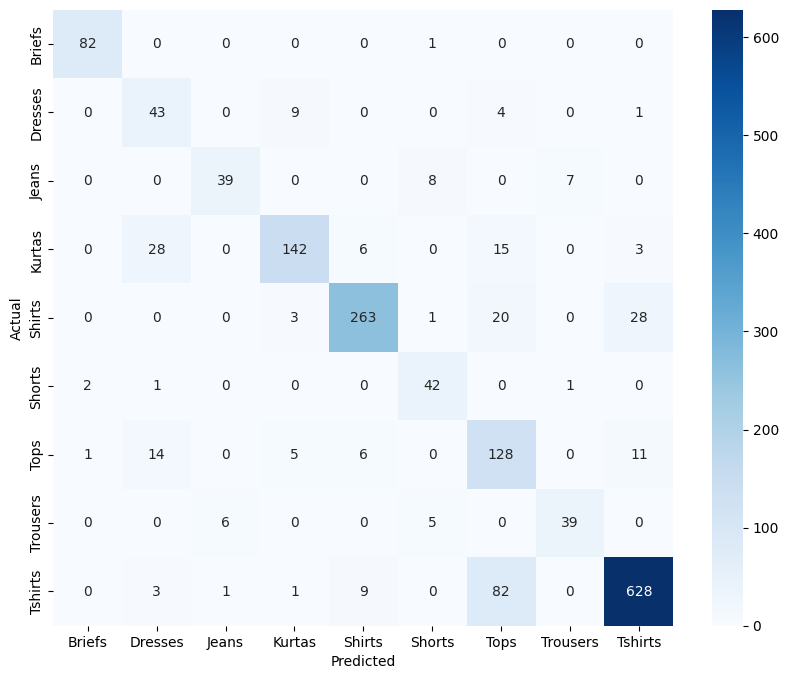

In [ ]:


# Make predictions on the test data
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


轴：y 轴（垂直）表示真实标签，而 x 轴（水平）表示模型预测的标签。矩阵中的每个单元格表示被分类为每个类别（预测标签）的特定类别（真实标签）的样本数。

对角线元素：矩阵的主对角线（从左上角到右下角）表示每个类别的正确预测数。理想情况下，您希望这些数字很高。

非对角线元素：非对角线元素表示错误分类。例如，如果第 2 行第 3 列中有一个数字 5，则表示属于第 2 类的 5 个样本被错误分类为第 3 类。

完美分类：在理想情况下，模型具有完美的分类精度，混淆矩阵将仅沿对角线具有非零值（意味着没有错误分类）。

颜色：通常，混淆矩阵采用颜色编码以便于阅读。对角线元素中的颜色越深意味着正确分类的数量越多，而非对角线元素中的颜色越深表示错误的数量越多。色标可帮助您快速查看模型在哪些类别中遇到困难。

现在让我们从矩阵中获取见解：

诊断错误分类：如果某些非对角线单元格具有高值，则意味着该模型经常将两个类别相互混淆。检查这些类可能会发现混淆模型的相似性，您可以考虑收集更多不同的数据或扩充这些类的数据。

识别弱类：如果某些类的对角线元素与其他类相比较低，则意味着该模型不擅长识别这些类。这可能是由于缺少这些类的训练数据，或者是因为这些特征不够独特。

类不平衡：如果某些类的实例明显多于其他类，并且模型有利于多数类，则可能意味着存在类不平衡问题。在这种情况下，您可能希望使用过采样、欠采样等技术，或使用不同的评估指标（如精度、召回率或 F1 分数）。

Focus Areas for Improvement：混淆矩阵可以指导您将精力集中在哪里来改进模型。通过识别哪些类被错误分类，您可以查看特定数据或模型调整，以提高模型在这些类上的性能。

### 2.5.3 Add focal loss

In [ ]:
# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False

# Define new model on top
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.keras.backend.sum(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.keras.backend.log(pt_1)) - tf.keras.backend.sum((1 - alpha) * tf.keras.backend.pow(pt_0, gamma) * tf.keras.backend.log(1. - pt_0))
    return focal_loss_fixed

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss=focal_loss(gamma=2., alpha=.25), metrics=['accuracy'])

In [ ]:
start_time = time.time()
# Training
batch_size = 32
history = model.fit(data_augmentation.flow(trainX, trainY, batch_size=batch_size),
                    steps_per_epoch=len(trainX) / batch_size, epochs=10,
                    validation_data=(valX, valY),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                    class_weight=class_weight_dict)  # Assuming you have computed class_weight_dict

# Fine-tuning: unfreeze some top layers from the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile the model (necessary after changing layer.trainable)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
history = model.fit(data_augmentation.flow(trainX, trainY, batch_size=batch_size),
                    steps_per_epoch=len(trainX) / batch_size, epochs=10,
                    validation_data=(valX, valY),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                    class_weight=class_weight_dict)

Epoch 1/10
421/421 [==============================] - 50s 87ms/step - loss: 33.7280 - accuracy: 0.1740 - val_loss: 17.9423 - val_accuracy: 0.4351
Epoch 2/10
421/421 [==============================] - 35s 82ms/step - loss: 24.2310 - accuracy: 0.2568 - val_loss: 16.4713 - val_accuracy: 0.4742
Epoch 3/10
421/421 [==============================] - 26s 61ms/step - loss: 20.9553 - accuracy: 0.2964 - val_loss: 15.7939 - val_accuracy: 0.4932
Epoch 4/10
421/421 [==============================] - 26s 61ms/step - loss: 19.3068 - accuracy: 0.3300 - val_loss: 15.3651 - val_accuracy: 0.5116
Epoch 5/10
421/421 [==============================] - 27s 63ms/step - loss: 18.1821 - accuracy: 0.3689 - val_loss: 15.0265 - val_accuracy: 0.5246
Epoch 6/10
421/421 [==============================] - 26s 62ms/step - loss: 17.6278 - accuracy: 0.3931 - val_loss: 14.6735 - val_accuracy: 0.5430
Epoch 7/10
421/421 [==============================] - 26s 61ms/step - loss: 16.8371 - accuracy: 0.4273 - val_loss: 14.3335 -

Monitor the learning process. If you see that validation performance stops improving (or gets worse) over epochs, it may be an indicator to stop training earlier or reduce the learning rate.

In [ ]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=0)
val_loss, val_accuracy = model.evaluate(valX, valY, verbose=0)
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=0)

# Print the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")



Training Accuracy: 0.8495332598686218
Validation Accuracy: 0.8269116878509521
Test Accuracy: 0.8270142078399658


In [ ]:
# Make predictions on the test data
y_pred = model.predict(testX)

# Generate the classification report
report = classification_report(testY, np.round(y_pred), target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 5s 31ms/step
Classification Report:
              precision    recall  f1-score   support

      Briefs       0.98      0.99      0.98        83
     Dresses       0.53      0.74      0.61        57
       Jeans       0.87      0.76      0.81        54
      Kurtas       0.88      0.65      0.75       194
      Shirts       0.89      0.85      0.87       315
      Shorts       0.80      0.96      0.87        46
        Tops       0.54      0.59      0.56       165
    Trousers       0.89      0.78      0.83        50
     Tshirts       0.96      0.83      0.89       724

   micro avg       0.86      0.80      0.83      1688
   macro avg       0.81      0.79      0.80      1688
weighted avg       0.87      0.80      0.83      1688
 samples avg       0.80      0.80      0.80      1688

Time taken: 641.3258793354034 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53/53 [==============================] - 2s 34ms/step


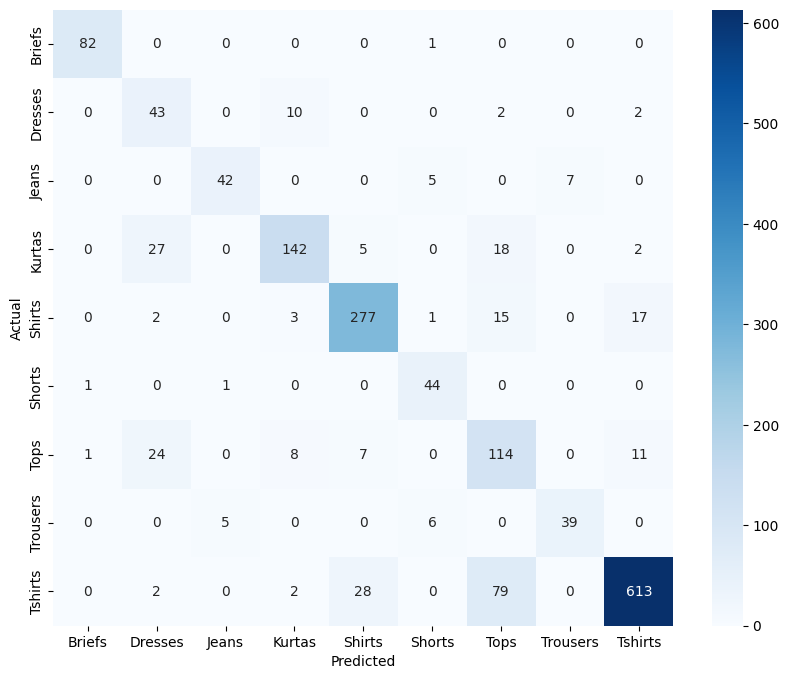

In [ ]:


# Make predictions on the test data
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


### 2.5.4 More Data Augmentation Specific to the Confusing Classes and Oversampling the Under-represented Classes

In [ ]:
# Oversampling specific classes
def oversample_data(trainX, trainY, class_indices, oversampling_factor=2):
    # Convert Tensors to Numpy arrays if they are not already
    if isinstance(trainX, tf.Tensor):
        trainX = trainX.numpy()
    if isinstance(trainY, tf.Tensor):
        trainY = trainY.numpy()

    X_oversampled = np.copy(trainX)
    Y_oversampled = np.copy(trainY)

    for class_index in class_indices:
        class_samples_X = trainX[np.argmax(trainY, axis=1) == class_index]
        class_samples_Y = trainY[np.argmax(trainY, axis=1) == class_index]

        for _ in range(oversampling_factor - 1):
            X_oversampled = np.concatenate([X_oversampled, class_samples_X])
            Y_oversampled = np.concatenate([Y_oversampled, class_samples_Y])

    return X_oversampled, Y_oversampled


# Assuming your class names are in the same order as the output of the neural network
index_dress = class_names.index('Dresses')
index_tops = class_names.index('Tops')

# Oversample data for 'Tops' and 'Dresses'
trainX_oversampled, trainY_oversampled = oversample_data(trainX, trainY, [index_dress, index_tops], oversampling_factor=3)

# Custom data augmentation for 'Tops' and 'Dresses'
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)




In [ ]:
start_time = time.time()
# Training
batch_size = 32
history = model.fit(data_augmentation.flow(trainX, trainY, batch_size=batch_size),
                    steps_per_epoch=len(trainX) / batch_size, epochs=10,
                    validation_data=(valX, valY),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])



Epoch 1/10
421/421 [==============================] - 38s 75ms/step - loss: 1.1277 - accuracy: 0.8349 - val_loss: 0.9948 - val_accuracy: 0.8560
Epoch 2/10
421/421 [==============================] - 27s 64ms/step - loss: 0.9944 - accuracy: 0.8393 - val_loss: 0.9153 - val_accuracy: 0.8512
Epoch 3/10
421/421 [==============================] - 26s 62ms/step - loss: 0.8968 - accuracy: 0.8398 - val_loss: 0.8259 - val_accuracy: 0.8542
Epoch 4/10
421/421 [==============================] - 26s 62ms/step - loss: 0.8017 - accuracy: 0.8463 - val_loss: 0.7752 - val_accuracy: 0.8536
Epoch 5/10
421/421 [==============================] - 26s 62ms/step - loss: 0.7260 - accuracy: 0.8492 - val_loss: 0.6651 - val_accuracy: 0.8601
Epoch 6/10
421/421 [==============================] - 26s 62ms/step - loss: 0.6752 - accuracy: 0.8495 - val_loss: 0.6551 - val_accuracy: 0.8506
Epoch 7/10
421/421 [==============================] - 26s 62ms/step - loss: 0.6204 - accuracy: 0.8549 - val_loss: 0.6274 - val_accuracy:

In [ ]:

# Evaluate the model
train_loss, train_accuracy = model.evaluate(trainX, trainY, verbose=0)
val_loss, val_accuracy = model.evaluate(valX, valY, verbose=0)
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=0)

# Print the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Training Accuracy: 0.8942065238952637
Validation Accuracy: 0.8500296473503113
Test Accuracy: 0.8524881601333618


In [ ]:
# Make predictions on the test data
y_pred = model.predict(testX)

# Generate the classification report
report = classification_report(testY, np.round(y_pred), target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

53/53 [==============================] - 1s 26ms/step
Classification Report:
              precision    recall  f1-score   support

      Briefs       0.99      0.99      0.99        83
     Dresses       0.79      0.46      0.58        57
       Jeans       0.88      0.80      0.83        54
      Kurtas       0.91      0.68      0.78       194
      Shirts       0.95      0.84      0.89       315
      Shorts       0.95      0.89      0.92        46
        Tops       0.55      0.66      0.60       165
    Trousers       0.84      0.86      0.85        50
     Tshirts       0.91      0.94      0.92       724

   micro avg       0.87      0.84      0.85      1688
   macro avg       0.86      0.79      0.82      1688
weighted avg       0.88      0.84      0.85      1688
 samples avg       0.84      0.84      0.84      1688

Time taken: 315.3501055240631 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


53/53 [==============================] - 1s 26ms/step


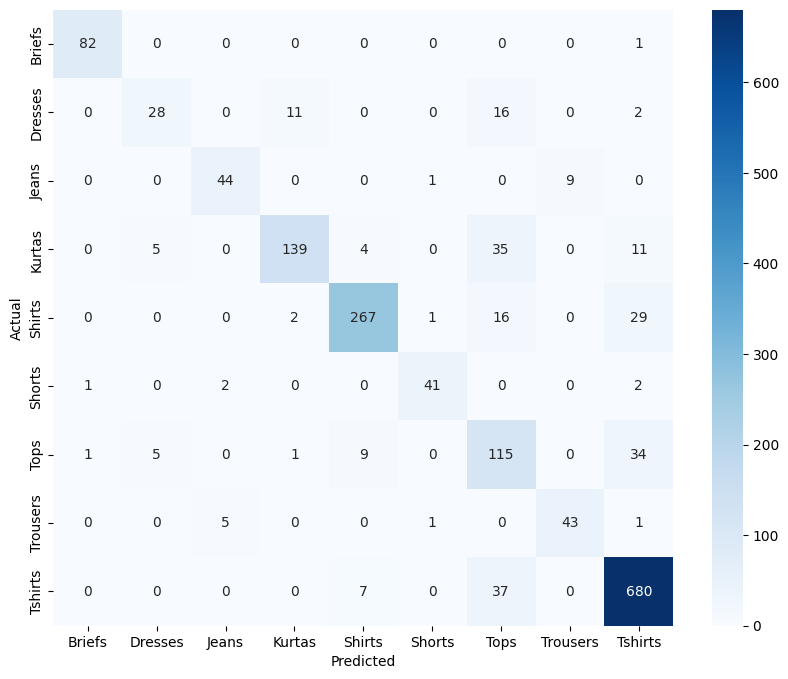

In [ ]:
# Make predictions on the test data
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


### 2.5.5  use random search to optimize both oversampling factors and data augmentation parameters.

In [ ]:
# Resize the images to meet the minimum requirement of InceptionResNetV2 (75x75)
trainX = tf.image.resize(trainX, [75, 75])
valX = tf.image.resize(valX, [75, 75])
testX = tf.image.resize(testX, [75, 75])

In [ ]:
def evaluate_model(trainX, trainY, valX, valY, oversampling_factor_tops, oversampling_factor_dresses, rotation_range, width_shift_range):
    trainX = np.array(trainX)
    trainY = np.array(trainY)
    indices = np.arange(len(trainX))
    ros = RandomOverSampler(sampling_strategy={6: int(oversampling_factor_tops * np.sum(trainY[:, 6])),
                                               1: int(oversampling_factor_dresses * np.sum(trainY[:, 1]))})
    indices_resampled, _ = ros.fit_resample(indices.reshape(-1, 1), trainY)
    indices_resampled = indices_resampled.flatten()
    trainX_resampled = trainX[indices_resampled]
    trainY_resampled = trainY[indices_resampled]
    data_augmentation = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    model = build_model()
    batch_size = 32
    history = model.fit(data_augmentation.flow(trainX_resampled, trainY_resampled, batch_size=batch_size),
                        steps_per_epoch=len(trainX_resampled) / batch_size, epochs=10,
                        validation_data=(valX, valY),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

    y_pred = model.predict(valX)
    y_pred_binarized = (y_pred >= 0.5).astype(int)

    score = custom_score(valY, y_pred_binarized)
    return score, history, y_pred_binarized


In [ ]:
def custom_score(y_true, y_pred_binarized):

    report = classification_report(y_true, y_pred_binarized, output_dict=True)
    f1_tops = report.get('6', {}).get('f1-score', 0)
    f1_dresses = report.get('1', {}).get('f1-score', 0)
    custom_score = (f1_tops + f1_dresses) / 2
    return custom_score


In [ ]:
def build_model():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
    base_model.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Define the parameter grid
param_grid = {
    'oversampling_factor_tops': [1, 2, 3, 4, 5],
    'oversampling_factor_dresses': [1, 2, 3, 4, 5],
    'rotation_range': [0, 15, 30],
    'width_shift_range': [0.1, 0.2, 0.3]
}

param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=0))

best_score = 0
best_params = None
for params in param_list:
    score = evaluate_model(trainX, trainY, valX, valY, **params)
    if score > best_score:
        best_score = score
        best_params = params

print("Best score:", best_score)
print("Best parameters:", best_params)

Epoch 1/10
533/533 [==============================] - 49s 69ms/step - loss: 7.1951 - accuracy: 0.3917 - val_loss: 5.8740 - val_accuracy: 0.5904
Epoch 2/10
533/533 [==============================] - 32s 61ms/step - loss: 5.4459 - accuracy: 0.5419 - val_loss: 4.5124 - val_accuracy: 0.6752
Epoch 3/10
533/533 [==============================] - 32s 61ms/step - loss: 4.2819 - accuracy: 0.6082 - val_loss: 3.5531 - val_accuracy: 0.7125
Epoch 4/10
533/533 [==============================] - 32s 60ms/step - loss: 3.4654 - accuracy: 0.6375 - val_loss: 2.9202 - val_accuracy: 0.7232
Epoch 5/10
533/533 [==============================] - 32s 61ms/step - loss: 2.8615 - accuracy: 0.6606 - val_loss: 2.3815 - val_accuracy: 0.7510
Epoch 6/10
533/533 [==============================] - 32s 61ms/step - loss: 2.4035 - accuracy: 0.6842 - val_loss: 1.9888 - val_accuracy: 0.7688
Epoch 7/10
533/533 [==============================] - 32s 60ms/step - loss: 2.0659 - accuracy: 0.6920 - val_loss: 1.7116 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
488/488 [==============================] - 45s 70ms/step - loss: 7.4631 - accuracy: 0.3644 - val_loss: 6.2328 - val_accuracy: 0.5531
Epoch 2/10
488/488 [==============================] - 30s 61ms/step - loss: 5.8910 - accuracy: 0.4985 - val_loss: 4.9898 - val_accuracy: 0.6372
Epoch 3/10
488/488 [==============================] - 30s 61ms/step - loss: 4.7964 - accuracy: 0.5562 - val_loss: 4.0107 - val_accuracy: 0.6947
Epoch 4/10
488/488 [==============================] - 29s 60ms/step - loss: 3.9633 - accuracy: 0.5991 - val_loss: 3.3377 - val_accuracy: 0.7007
Epoch 5/10
488/488 [==============================] - 29s 59ms/step - loss: 3.3074 - accuracy: 0.6271 - val_loss: 2.7911 - val_accuracy: 0.7285
Epoch 6/10
488/488 [==============================] - 29s 60ms/step - loss: 2.8198 - accuracy: 0.6487 - val_loss: 2.3937 - val_accuracy: 0.7232
Epoch 7/10
488/488 [==============================] - 30s 61ms/step - loss: 2.4448 - accuracy: 0.6597 - val_loss: 2.0544 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
510/510 [==============================] - 47s 68ms/step - loss: 7.5533 - accuracy: 0.3086 - val_loss: 6.2736 - val_accuracy: 0.5015
Epoch 2/10
510/510 [==============================] - 31s 62ms/step - loss: 5.9122 - accuracy: 0.4442 - val_loss: 4.9517 - val_accuracy: 0.6147
Epoch 3/10
510/510 [==============================] - 31s 61ms/step - loss: 4.7762 - accuracy: 0.5095 - val_loss: 3.9706 - val_accuracy: 0.6704
Epoch 4/10
510/510 [==============================] - 31s 60ms/step - loss: 3.9068 - accuracy: 0.5523 - val_loss: 3.2658 - val_accuracy: 0.6835
Epoch 5/10
510/510 [==============================] - 31s 62ms/step - loss: 3.2523 - accuracy: 0.5828 - val_loss: 2.7447 - val_accuracy: 0.6941
Epoch 6/10
510/510 [==============================] - 32s 63ms/step - loss: 2.7646 - accuracy: 0.6051 - val_loss: 2.3052 - val_accuracy: 0.7220
Epoch 7/10
510/510 [==============================] - 32s 62ms/step - loss: 2.4069 - accuracy: 0.6243 - val_loss: 2.0040 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
465/465 [==============================] - 45s 70ms/step - loss: 7.2830 - accuracy: 0.4197 - val_loss: 6.0225 - val_accuracy: 0.6260
Epoch 2/10
465/465 [==============================] - 29s 62ms/step - loss: 5.6764 - accuracy: 0.5578 - val_loss: 4.7581 - val_accuracy: 0.7001
Epoch 3/10
465/465 [==============================] - 28s 60ms/step - loss: 4.5598 - accuracy: 0.6165 - val_loss: 3.8855 - val_accuracy: 0.6995
Epoch 4/10
465/465 [==============================] - 28s 60ms/step - loss: 3.7231 - accuracy: 0.6556 - val_loss: 3.1802 - val_accuracy: 0.7315
Epoch 5/10
465/465 [==============================] - 28s 60ms/step - loss: 3.1039 - accuracy: 0.6750 - val_loss: 2.6296 - val_accuracy: 0.7469
Epoch 6/10
465/465 [==============================] - 28s 60ms/step - loss: 2.6194 - accuracy: 0.6909 - val_loss: 2.2424 - val_accuracy: 0.7528
Epoch 7/10
465/465 [==============================] - 28s 60ms/step - loss: 2.2513 - accuracy: 0.7047 - val_loss: 1.9281 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5712) in class 6 will be larger than the number of samples in the majority class (class #8 -> 5651)
  warnings.warn(


Epoch 1/10
566/566 [==============================] - 50s 68ms/step - loss: 6.9711 - accuracy: 0.4289 - val_loss: 5.6303 - val_accuracy: 0.5951
Epoch 2/10
566/566 [==============================] - 34s 60ms/step - loss: 5.1349 - accuracy: 0.5805 - val_loss: 4.2688 - val_accuracy: 0.6710
Epoch 3/10
566/566 [==============================] - 35s 61ms/step - loss: 3.9623 - accuracy: 0.6352 - val_loss: 3.3375 - val_accuracy: 0.6870
Epoch 4/10
566/566 [==============================] - 35s 62ms/step - loss: 3.1229 - accuracy: 0.6717 - val_loss: 2.6245 - val_accuracy: 0.7255
Epoch 5/10
566/566 [==============================] - 35s 61ms/step - loss: 2.5591 - accuracy: 0.6942 - val_loss: 2.1610 - val_accuracy: 0.7338
Epoch 6/10
566/566 [==============================] - 34s 59ms/step - loss: 2.1458 - accuracy: 0.7099 - val_loss: 1.8211 - val_accuracy: 0.7516
Epoch 7/10
566/566 [==============================] - 34s 60ms/step - loss: 1.8317 - accuracy: 0.7241 - val_loss: 1.5845 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
522/522 [==============================] - 47s 68ms/step - loss: 7.2875 - accuracy: 0.3697 - val_loss: 5.9153 - val_accuracy: 0.5880
Epoch 2/10
522/522 [==============================] - 31s 60ms/step - loss: 5.5179 - accuracy: 0.5348 - val_loss: 4.5451 - val_accuracy: 0.6598
Epoch 3/10
522/522 [==============================] - 32s 61ms/step - loss: 4.3275 - accuracy: 0.6016 - val_loss: 3.6043 - val_accuracy: 0.6941
Epoch 4/10
522/522 [==============================] - 31s 59ms/step - loss: 3.4918 - accuracy: 0.6373 - val_loss: 2.8937 - val_accuracy: 0.7315
Epoch 5/10
522/522 [==============================] - 31s 60ms/step - loss: 2.8838 - accuracy: 0.6590 - val_loss: 2.4502 - val_accuracy: 0.7238
Epoch 6/10
522/522 [==============================] - 32s 61ms/step - loss: 2.4415 - accuracy: 0.6765 - val_loss: 2.0636 - val_accuracy: 0.7457
Epoch 7/10
522/522 [==============================] - 31s 60ms/step - loss: 2.0981 - accuracy: 0.6978 - val_loss: 1.7736 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
499/499 [==============================] - 46s 71ms/step - loss: 7.2848 - accuracy: 0.3665 - val_loss: 5.8928 - val_accuracy: 0.5963
Epoch 2/10
499/499 [==============================] - 31s 61ms/step - loss: 5.5245 - accuracy: 0.5193 - val_loss: 4.5325 - val_accuracy: 0.6835
Epoch 3/10
499/499 [==============================] - 31s 61ms/step - loss: 4.3733 - accuracy: 0.5778 - val_loss: 3.6194 - val_accuracy: 0.7048
Epoch 4/10
499/499 [==============================] - 30s 61ms/step - loss: 3.5383 - accuracy: 0.6195 - val_loss: 2.9226 - val_accuracy: 0.7255
Epoch 5/10
499/499 [==============================] - 31s 63ms/step - loss: 2.9208 - accuracy: 0.6469 - val_loss: 2.4230 - val_accuracy: 0.7499
Epoch 6/10
499/499 [==============================] - 30s 60ms/step - loss: 2.4679 - accuracy: 0.6626 - val_loss: 2.0770 - val_accuracy: 0.7386
Epoch 7/10
499/499 [==============================] - 31s 62ms/step - loss: 2.1272 - accuracy: 0.6763 - val_loss: 1.7465 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
454/454 [==============================] - 44s 70ms/step - loss: 7.4672 - accuracy: 0.3778 - val_loss: 6.2210 - val_accuracy: 0.5809
Epoch 2/10
454/454 [==============================] - 29s 63ms/step - loss: 5.9609 - accuracy: 0.5212 - val_loss: 5.1100 - val_accuracy: 0.6479
Epoch 3/10
454/454 [==============================] - 28s 61ms/step - loss: 4.8910 - accuracy: 0.5877 - val_loss: 4.2090 - val_accuracy: 0.6775
Epoch 4/10
454/454 [==============================] - 28s 61ms/step - loss: 4.0671 - accuracy: 0.6189 - val_loss: 3.4563 - val_accuracy: 0.7220
Epoch 5/10
454/454 [==============================] - 28s 61ms/step - loss: 3.4213 - accuracy: 0.6441 - val_loss: 2.9370 - val_accuracy: 0.7208
Epoch 6/10
454/454 [==============================] - 28s 61ms/step - loss: 2.9121 - accuracy: 0.6626 - val_loss: 2.4991 - val_accuracy: 0.7404
Epoch 7/10
454/454 [==============================] - 28s 61ms/step - loss: 2.5055 - accuracy: 0.6775 - val_loss: 2.1475 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5712) in class 6 will be larger than the number of samples in the majority class (class #8 -> 5651)
  warnings.warn(


Epoch 1/10
599/599 [==============================] - 52s 66ms/step - loss: 6.9870 - accuracy: 0.4118 - val_loss: 5.5456 - val_accuracy: 0.6212
Epoch 2/10
599/599 [==============================] - 36s 59ms/step - loss: 5.1013 - accuracy: 0.5662 - val_loss: 4.1557 - val_accuracy: 0.6864
Epoch 3/10
599/599 [==============================] - 35s 59ms/step - loss: 3.9149 - accuracy: 0.6301 - val_loss: 3.2196 - val_accuracy: 0.7202
Epoch 4/10
599/599 [==============================] - 36s 61ms/step - loss: 3.0917 - accuracy: 0.6676 - val_loss: 2.5485 - val_accuracy: 0.7439
Epoch 5/10
599/599 [==============================] - 36s 60ms/step - loss: 2.5194 - accuracy: 0.6874 - val_loss: 2.0728 - val_accuracy: 0.7659
Epoch 6/10
599/599 [==============================] - 36s 59ms/step - loss: 2.0921 - accuracy: 0.7103 - val_loss: 1.7651 - val_accuracy: 0.7552
Epoch 7/10
599/599 [==============================] - 36s 60ms/step - loss: 1.8034 - accuracy: 0.7192 - val_loss: 1.5187 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5712) in class 6 will be larger than the number of samples in the majority class (class #8 -> 5651)
  warnings.warn(


Epoch 1/10
588/588 [==============================] - 52s 66ms/step - loss: 7.1473 - accuracy: 0.3630 - val_loss: 5.7787 - val_accuracy: 0.5744
Epoch 2/10
588/588 [==============================] - 35s 60ms/step - loss: 5.2693 - accuracy: 0.5254 - val_loss: 4.3416 - val_accuracy: 0.6366
Epoch 3/10
588/588 [==============================] - 36s 62ms/step - loss: 4.0589 - accuracy: 0.5842 - val_loss: 3.3791 - val_accuracy: 0.6758
Epoch 4/10
588/588 [==============================] - 35s 60ms/step - loss: 3.2295 - accuracy: 0.6218 - val_loss: 2.7325 - val_accuracy: 0.6882
Epoch 5/10
588/588 [==============================] - 35s 60ms/step - loss: 2.6443 - accuracy: 0.6456 - val_loss: 2.2180 - val_accuracy: 0.7226
Epoch 6/10
588/588 [==============================] - 35s 60ms/step - loss: 2.2327 - accuracy: 0.6616 - val_loss: 1.8625 - val_accuracy: 0.7303
Epoch 7/10
588/588 [==============================] - 36s 60ms/step - loss: 1.9336 - accuracy: 0.6775 - val_loss: 1.6849 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Use the best parameters obtained from the search
best_params = {'width_shift_range': 0.1, 'rotation_range': 0, 'oversampling_factor_tops': 4, 'oversampling_factor_dresses': 5}

# Evaluate the model with the best parameters
score, history, y_pred_binarized = evaluate_model(trainX, trainY, valX, valY, **best_params)

# Print training accuracy, validation accuracy and the classification report
print("Training accuracy: ", history.history['accuracy'][-1])
print("Validation accuracy: ", history.history['val_accuracy'][-1])
print("Classification Report:\n", classification_report(valY, y_pred_binarized))

# Print the custom score
print("Custom Score: ", score)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (5712) in class 6 will be larger than the number of samples in the majority class (class #8 -> 5651)
  warnings.warn(


Epoch 1/10
599/599 [==============================] - 52s 65ms/step - loss: 6.9933 - accuracy: 0.4103 - val_loss: 5.5246 - val_accuracy: 0.6070
Epoch 2/10
599/599 [==============================] - 36s 59ms/step - loss: 5.0525 - accuracy: 0.5702 - val_loss: 4.0901 - val_accuracy: 0.6775
Epoch 3/10
599/599 [==============================] - 36s 61ms/step - loss: 3.8435 - accuracy: 0.6286 - val_loss: 3.1220 - val_accuracy: 0.7427
Epoch 4/10
599/599 [==============================] - 35s 59ms/step - loss: 3.0272 - accuracy: 0.6686 - val_loss: 2.5289 - val_accuracy: 0.7297
Epoch 5/10
599/599 [==============================] - 36s 59ms/step - loss: 2.4601 - accuracy: 0.6888 - val_loss: 2.0539 - val_accuracy: 0.7481
Epoch 6/10
599/599 [==============================] - 36s 61ms/step - loss: 2.0711 - accuracy: 0.7058 - val_loss: 1.7092 - val_accuracy: 0.7623
Epoch 7/10
599/599 [==============================] - 36s 61ms/step - loss: 1.7701 - accuracy: 0.7176 - val_loss: 1.4735 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[ 93   0   0   0   0   0   1   0   0]
 [ 24  13   0   1   0   0  16   0   1]
 [ 25   0  36   0   0   0   0  12   0]
 [ 64   7   0  59   9   0  24   0   0]
 [ 26   0   0   0 268   0  13   0  22]
 [ 20   0   0   0   0  31   1   2   0]
 [ 26   0   0   2   3   0 120   0  18]
 [ 18   0   3   0   0   1   0  38   0]
 [ 46   0   0   0  15   0  77   0 552]]


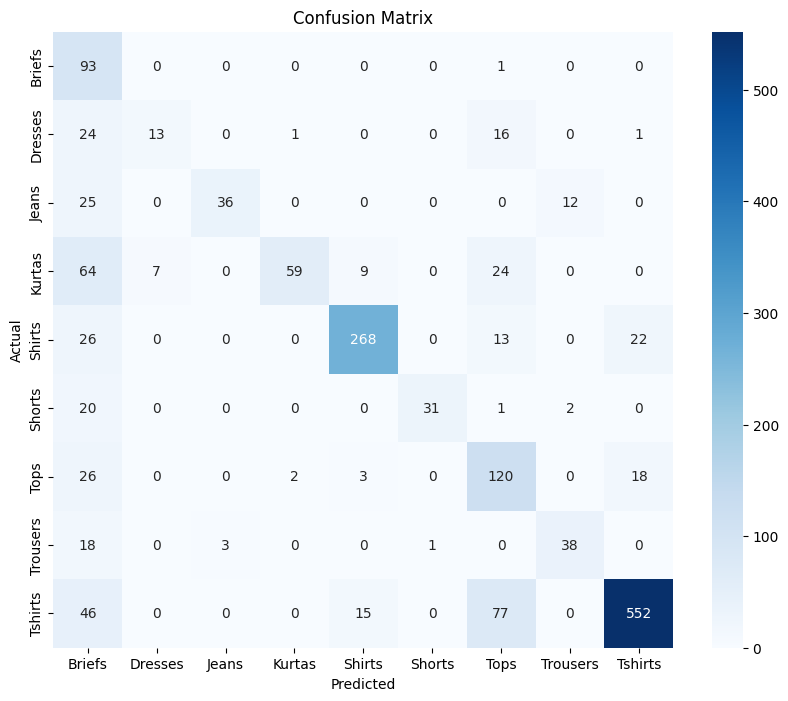

In [ ]:

# Print the confusion matrix
matrix = confusion_matrix(valY.argmax(axis=1), y_pred_binarized.argmax(axis=1))
print("Confusion Matrix:")
print(matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

### 2.5.6 Apply manual class weight and specific data augmentation

In [ ]:
def custom_data_generator(trainX, trainY, batch_size, data_augmentation):
    while True:
        # Indices for the batch
        idxs = np.random.randint(0, len(trainX), batch_size)

        # Create arrays for the batch
        batch_x = np.zeros((batch_size, 75, 75, 3))
        batch_y = np.zeros((batch_size, 9))

        # Temporary lists to store images and labels that need augmentation
        aug_images = []
        aug_labels = []

        # Fill arrays with a random batch of images and labels
        for i, idx in enumerate(idxs):
            image = trainX[idx]
            label = trainY[idx]

            # Apply data augmentation if the label is 'Tops' or 'Dresses'
            # 'Tops' is index 6 and 'Dresses' is index 1
            if np.argmax(label) == 6 or np.argmax(label) == 1:
                aug_images.append(image)
                aug_labels.append(label)
            else:
                batch_x[i] = image
                batch_y[i] = label

        # Apply data augmentation to images that need it
        if aug_images:
            augmented_data = next(data_augmentation.flow(np.array(aug_images), np.array(aug_labels), batch_size=len(aug_images)))
            j = 0
            for k, label in enumerate(batch_y):
                if np.argmax(label) == 6 or np.argmax(label) == 1:
                    batch_x[k] = augmented_data[0][j]
                    batch_y[k] = augmented_data[1][j]
                    j += 1

        yield (batch_x, batch_y)

# Keep the rest of the code same and execute


In [ ]:
def evaluate_model(trainX, trainY, valX, valY, testX, testY, class_weights):
    # Data augmentation
    data_augmentation = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Build a new model
    model = build_model()

    # Training
    batch_size = 32
    steps_per_epoch = len(trainX) / batch_size
    custom_gen = custom_data_generator(trainX, trainY, batch_size, data_augmentation)

    history = model.fit(
        custom_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=(valX, valY),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
        class_weight=class_weights
    )

    # Make predictions on the validation data
    y_pred = model.predict(valX)
    y_pred_binarized = (y_pred >= 0.5).astype(int)

    # Make predictions on the test data
    y_test_pred = model.predict(testX)
    y_test_pred_binarized = (y_test_pred >= 0.5).astype(int)

    # Print the reports
    print("Training accuracy: ", history.history['accuracy'][-1])
    print("Validation accuracy: ", history.history['val_accuracy'][-1])
    print("Classification Report (Validation Set):\n", classification_report(valY, y_pred_binarized))
    print("Test accuracy: ", np.mean(y_test_pred_binarized.argmax(axis=1) == testY.argmax(axis=1)))
    print("Classification Report (Test Set):\n", classification_report(testY, y_test_pred_binarized))


In [ ]:
# Execute the function
start_time = time.time()
# Define class weights
class_weights = {0: 1, 1: 4, 2: 1, 3: 1, 4: 1, 5: 1, 6: 5, 7: 1, 8: 1}
# Evaluate the model with class weights and specific data augmentation
evaluate_model(trainX, trainY, valX, valY, testX, testY, class_weights)
# Optional - additional information (remove if not needed)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Epoch 1/10
421/421 [==============================] - 43s 66ms/step - loss: 6.7120 - accuracy: 0.4950 - val_loss: 6.1322 - val_accuracy: 0.7054
Epoch 2/10
421/421 [==============================] - 21s 49ms/step - loss: 5.6759 - accuracy: 0.5899 - val_loss: 6.8423 - val_accuracy: 0.6900
Epoch 3/10
421/421 [==============================] - 20s 48ms/step - loss: 16.4976 - accuracy: 0.4681 - val_loss: 30.7354 - val_accuracy: 0.5489
Epoch 4/10
53/53 [==============================] - 2s 40ms/step
Training accuracy:  0.37922096252441406
Validation accuracy:  0.42916420102119446
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       1.00      0.02      0.04        94
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       163
           4       0.68      0.10      0.17       329
           5       0.00      0.00      0.00        54

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.5.7 random search

In [ ]:
def build_model(hp):
    base_model = keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Using hyperparameters in the first Dense layer
    x = keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=512, step=32),
        activation='relu'
    )(x)

    # Using hyperparameters in the dropout rate
    x = keras.layers.Dropout(hp.Float('dropout_1_rate', min_value=0.0, max_value=0.5, step=0.1))(x)

    # Additional Dense Layer with hyperparameters
    x = keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=32, max_value=512, step=32),
        activation='relu'
    )(x)

    # Using hyperparameters in the dropout rate for the second dropout layer
    x = keras.layers.Dropout(hp.Float('dropout_2_rate', min_value=0.0, max_value=0.5, step=0.1))(x)

    predictions = keras.layers.Dense(len(class_names), activation='softmax')(x)

    model = keras.Model(inputs=base_model.input, outputs=predictions)

    # Using hyperparameters in learning rate
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Assuming you have already computed class_weight_dict, and your data is loaded as trainX, trainY, valX, valY
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='random_search_directory',
    project_name='inception_resnetv2'
)

tuner.search(trainX, trainY, epochs=5, validation_data=(valX, valY), class_weight=class_weight_dict, verbose=1)


In [ ]:
print(tuner.search_space_summary())


Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
None


In [ ]:
# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3)
random_search.fit(trainX, trainY)

# Output the best hyperparameters
print("Best Hyperparameters:")
print(random_search.best_params_)

TypeError: ignored

In [ ]:
# Evaluate on test data with best hyperparameters
best_model = random_search.best_estimator_.model
test_loss, test_accuracy = best_model.evaluate(testX, testY, verbose=0)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Make predictions on the test data
y_pred = best_model.predict(testX)

# Generate the classification report
report = classification_report(testY, np.round(y_pred), target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")


### 2.5.8 Class Weights

In [ ]:
# Resize the input images to (224, 224) and convert to grayscale
x_train_resized = np.array([cv2.resize(img, (224, 224)) for img in x_train])
x_val_resized = np.array([cv2.resize(img, (224, 224)) for img in x_val])
x_test_resized = np.array([cv2.resize(img, (224, 224)) for img in x_test])

# Add channel dimension to grayscale images
x_train_resized = np.expand_dims(x_train_resized, axis=-1)
x_val_resized = np.expand_dims(x_val_resized, axis=-1)
x_test_resized = np.expand_dims(x_test_resized, axis=-1)

# Define the class weights
class_weights = {0: 1.0, 1: 5.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 5.0, 7: 1.0, 8: 1.0}

# Split the data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(hog_features, labels, stratify=labels,
                                                    test_size=0.2, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train,
                                                  test_size=0.25, shuffle=True)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
y_train_one_hot = tf.one_hot(y_train, num_classes)
y_val_one_hot = tf.one_hot(y_val, num_classes)
y_test_one_hot = tf.one_hot(y_test, num_classes)

# Convert one-hot encoded targets back to categorical labels
y_train_categorical = np.argmax(y_train_one_hot, axis=1)
y_val_categorical = np.argmax(y_val_one_hot, axis=1)

# Load the grayscale Inception-ResNetV2 model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 1))

# Add a global average pooling layer and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(x_train_resized, y_train_categorical, batch_size=32, epochs=10,
                    validation_data=(x_val_resized, y_val_categorical), class_weight=class_weights)